# Ports Notebook

The objective of this analysis is to examine the impact of the Red Sea Conflict on maritime trade statistics derived from AIS data.  

We process transit calls and estimated trade volume from the IMF's [PortWatch](https://portwatch.imf.org/) platform for key ports of interest. We then produce charts to inspect trends and calculate percentage changes from a historical baseline.

## Setup

Import libraries and define output paths to save graphs and tables.

In [1]:
import os
import sys
from os.path import join, exists

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import git
git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(join(git_root, "src", "red-sea-monitoring"))
from utils import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, comma_format
import plotnine

plotnine.options.figure_size = (10, 8)

output_dir = r"C:\Users\WB514197\WBG\Development Data Partnership - Red Sea Maritime Monitoring"
charts_dir = join(git_root, "reports")

## Data

### Ports

In [2]:
# ports = get_ports()
countries = ["Egypt", "Yemen", "Djibouti", "Jordan", "Saudi Arabia"]
# ports_sel = ports.loc[ports.country.isin(countries)].copy()
# ports_sel.sort_values("country", inplace=True)
# ports_sel.loc[:, "geometry"] = ports_sel.apply(lambda x: Point(x.lon, x.lat), axis=1)
# ports_gdf = gpd.GeoDataFrame(ports_sel, geometry="geometry", crs="EPSG:4326")
# ports_gdf.to_file(join(git_root, "data", "ports_sel.geojson"), driver='GeoJSON'))
ports_red_sea = gpd.read_file(
    join(git_root, "data", "red_sea_ports.geojson"), driver="GeoJSON"
)

In [3]:
ports_red_sea[["country", "portname", "portid"]]

country                         portname    portid
0       Djibouti                         Djibouti   port294
1          Egypt                       El-Adabiya   port321
2          Egypt                           Safaga   port191
3          Egypt            North Ain Sukhna Port   port828
4          Egypt                        As Suways    port71
5         Jordan                        Al Aqabah    port19
6   Saudi Arabia  Duba Bulk Plant Tanker Terminal   port305
7   Saudi Arabia                           Rabigh  port1081
8   Saudi Arabia                   King Fahd Port   port570
9   Saudi Arabia                             Duba   port304
10  Saudi Arabia                            Yanbu  port1408
11  Saudi Arabia                           Jiddah   port518
12  Saudi Arabia                       Jiddah Oil   port519
13         Yemen                       Al Mukalla    port27
14         Yemen                        Al Ahmadi    port18
15         Yemen                             Aden     port9

### Map of Ports

In [4]:
ports_red_sea[[
    'geometry', 'portname', 'country', 
    'vessel_count_total', 'vessel_count_container',
    'vessel_count_dry_bulk', 'vessel_count_general_cargo',
    'vessel_count_RoRo', 'vessel_count_tanker', 'industry_top1',
    'industry_top2', 'industry_top3', 'share_country_maritime_import',
       'share_country_maritime_export'
    ]].explore(
        column='country',
        cmap = 'Dark2',
        marker_kwds= {'radius': 7},
        tiles = 'Esri.WorldGrayCanvas',
        legend_kwds={'loc': 'upper right', 'caption': 'Ports'}
        # attribution = 'chec'
    )

### Trade Data

Pull trade data for selected locations.

In [6]:
ports = list(ports_red_sea.portid)
df_ports = get_port_data(ports)
df_ports.to_csv(join(output_dir, "data", "PortWatch-data", "ports_data_02_26_2024.csv"), index=False)

## Data Analysis

### Convert to Weekly

In [7]:
df = pd.read_csv(join(output_dir, "data", "PortWatch-data", "ports_data_02_26_2024.csv"))
df.date = pd.to_datetime(df.date)
df = df.loc[df.date >= "2019-01-01"].copy()

In [8]:
df.tail(2)

date  year  month  day portid portname country ISO3  \
29984 2024-02-16 19:00:00  2024      2   17  port9     Aden   Yemen  YEM   
29985 2024-02-17 19:00:00  2024      2   18  port9     Aden   Yemen  YEM   

       portcalls_cargo  portcalls_tanker  portcalls  import_cargo  \
29984                0                 2          2           0.0   
29985                1                 0          1           0.0   

       export_cargo  import_tanker  export_tanker       import  export  \
29984           0.0    8121.715443            0.0  8121.715443     0.0   
29985           0.0       0.000000            0.0     0.000000     0.0   

       ObjectId  
29984   2400143  
29985   2400144

Calculate weekly sums.

In [9]:
df = df[
    [
        "portname",
        "portcalls_cargo",
        "portcalls_tanker",
        "portcalls",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
        "date",
    ]
].copy()
df_raw = df.copy()

df = (
    df.groupby("portname")[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
            "date",
        ]
    ]
    .resample("W-Mon", on="date")
    .sum()
    .reset_index()
)

df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "w"] = df.date.dt.strftime("%W")

In [10]:
df.head(2)

portname       date  portcalls_cargo  portcalls_tanker  portcalls  \
0     Aden 2019-01-07                9                 1         10   
1     Aden 2019-01-14                9                 0          9   

   import_cargo  export_cargo  import_tanker  export_tanker        import  \
0  67364.559011    371.408892            0.0            0.0  67364.559011   
1  37879.939218      0.000000            0.0            0.0  37879.939218   

       export         ymd   w  
0  371.408892  2019-01-07  01  
1    0.000000  2019-01-14  02

### Plot Weekly Trade Volume

In [11]:
# start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [12]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()

In [13]:
charts_by_port_dir = join(charts_dir, "ports")
if not exists(charts_by_port_dir):
    os.makedirs(charts_by_port_dir, mode=0o777)

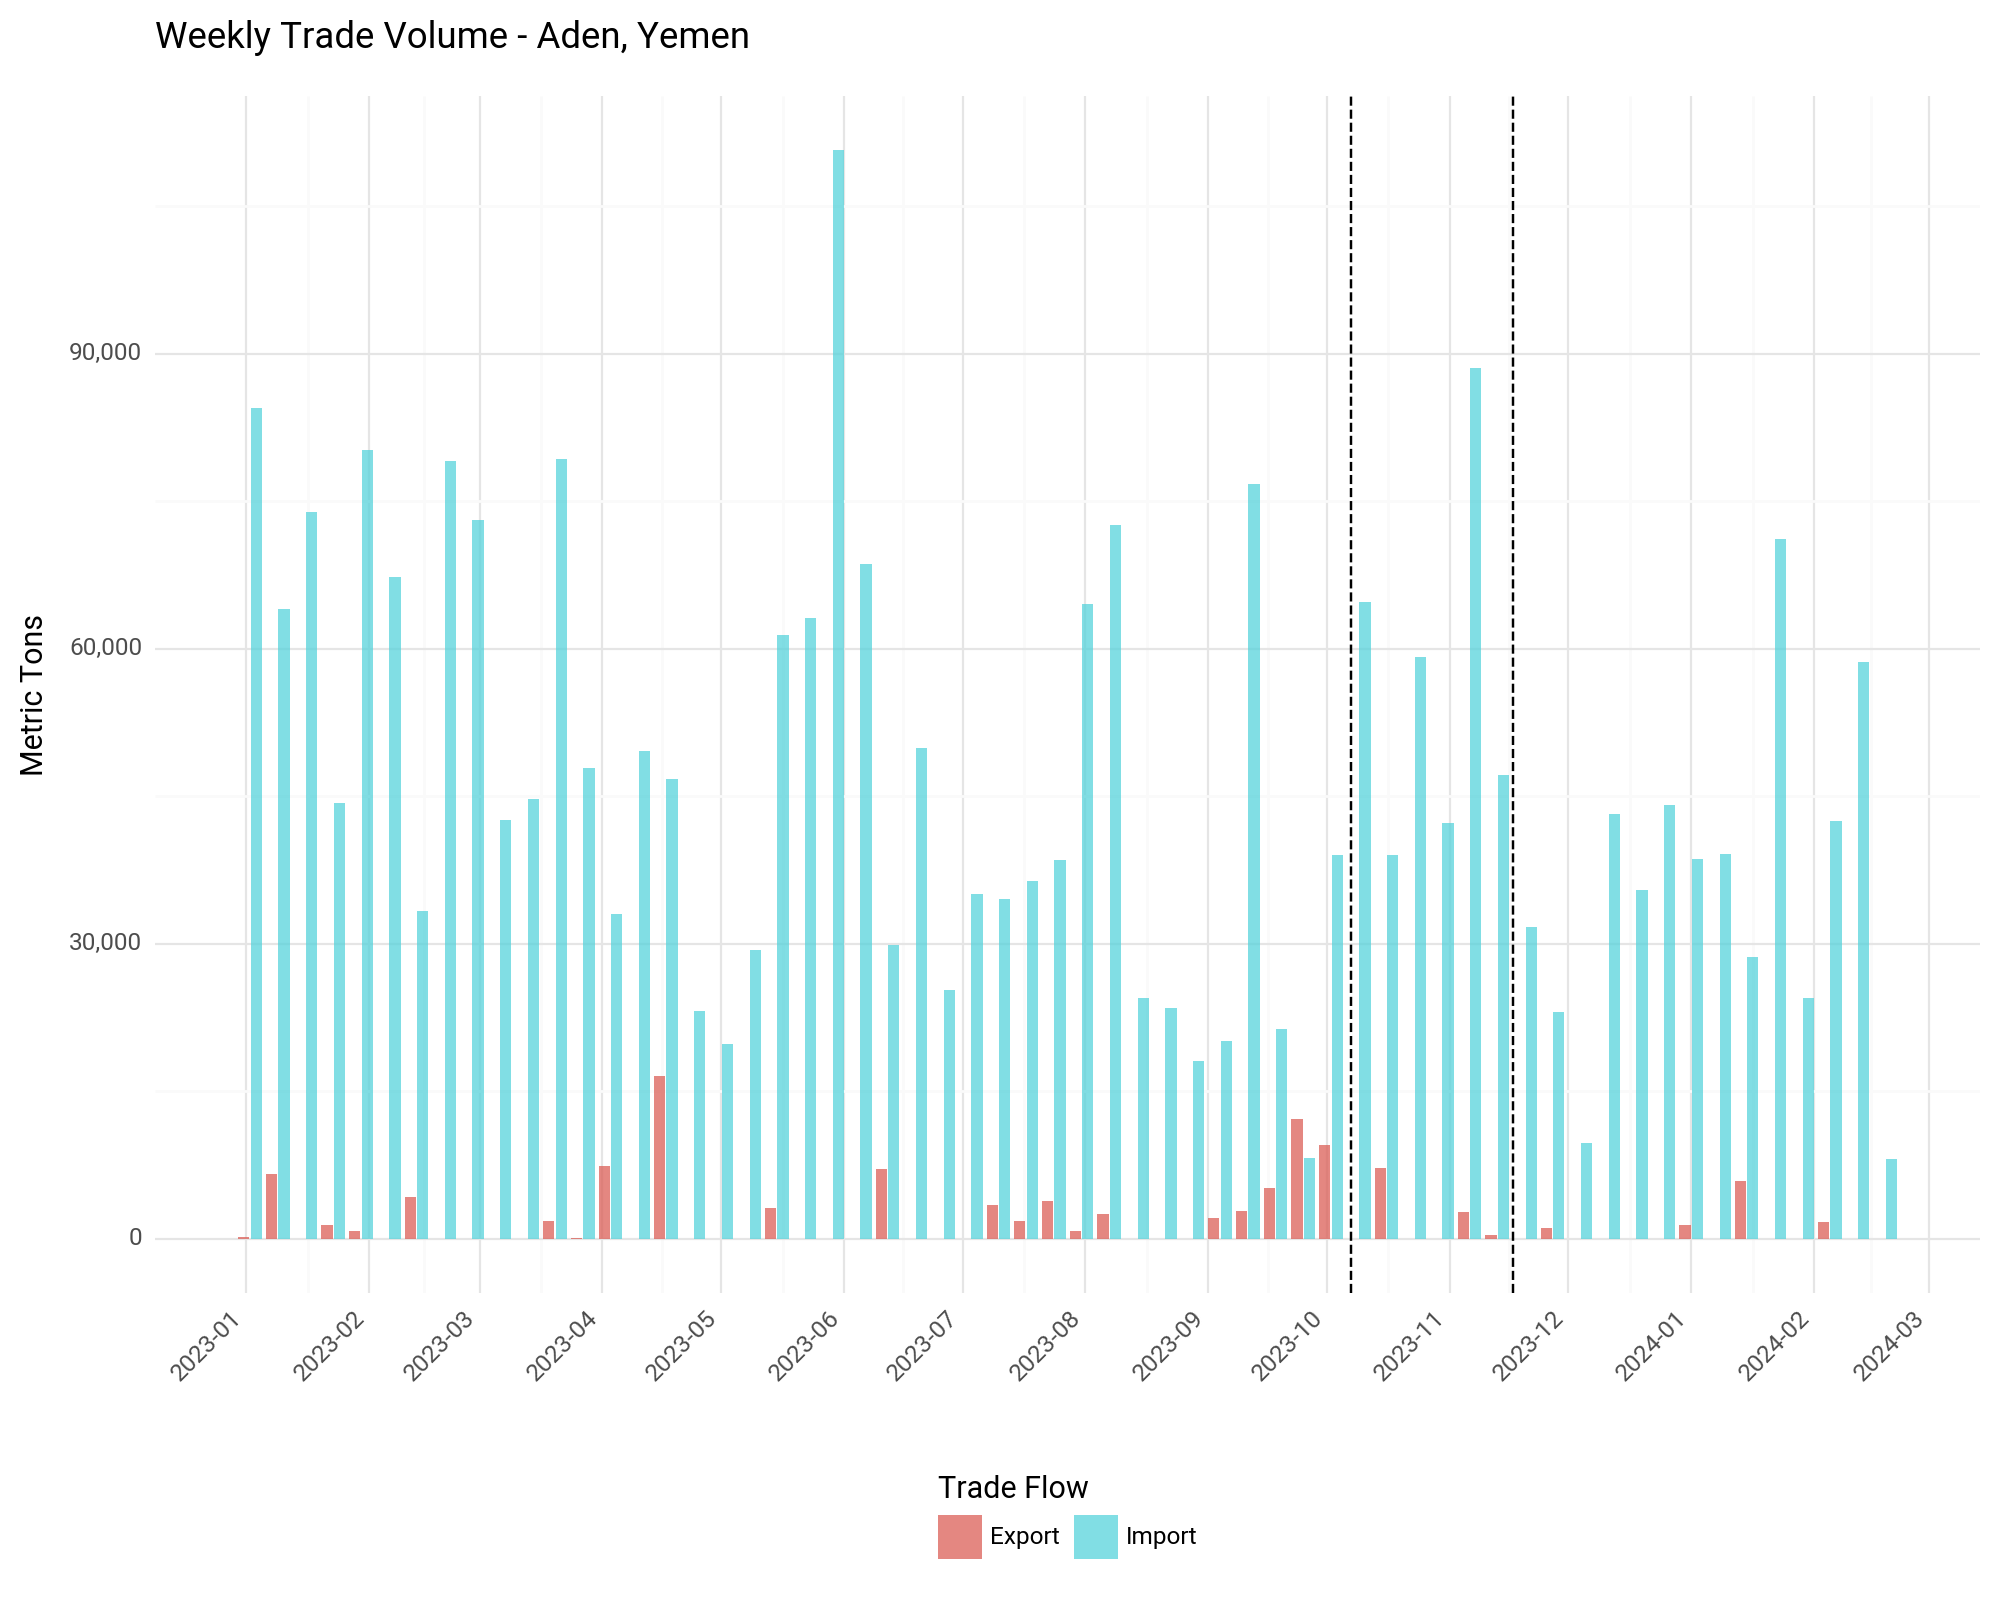

<Figure Size: (1000 x 800)>

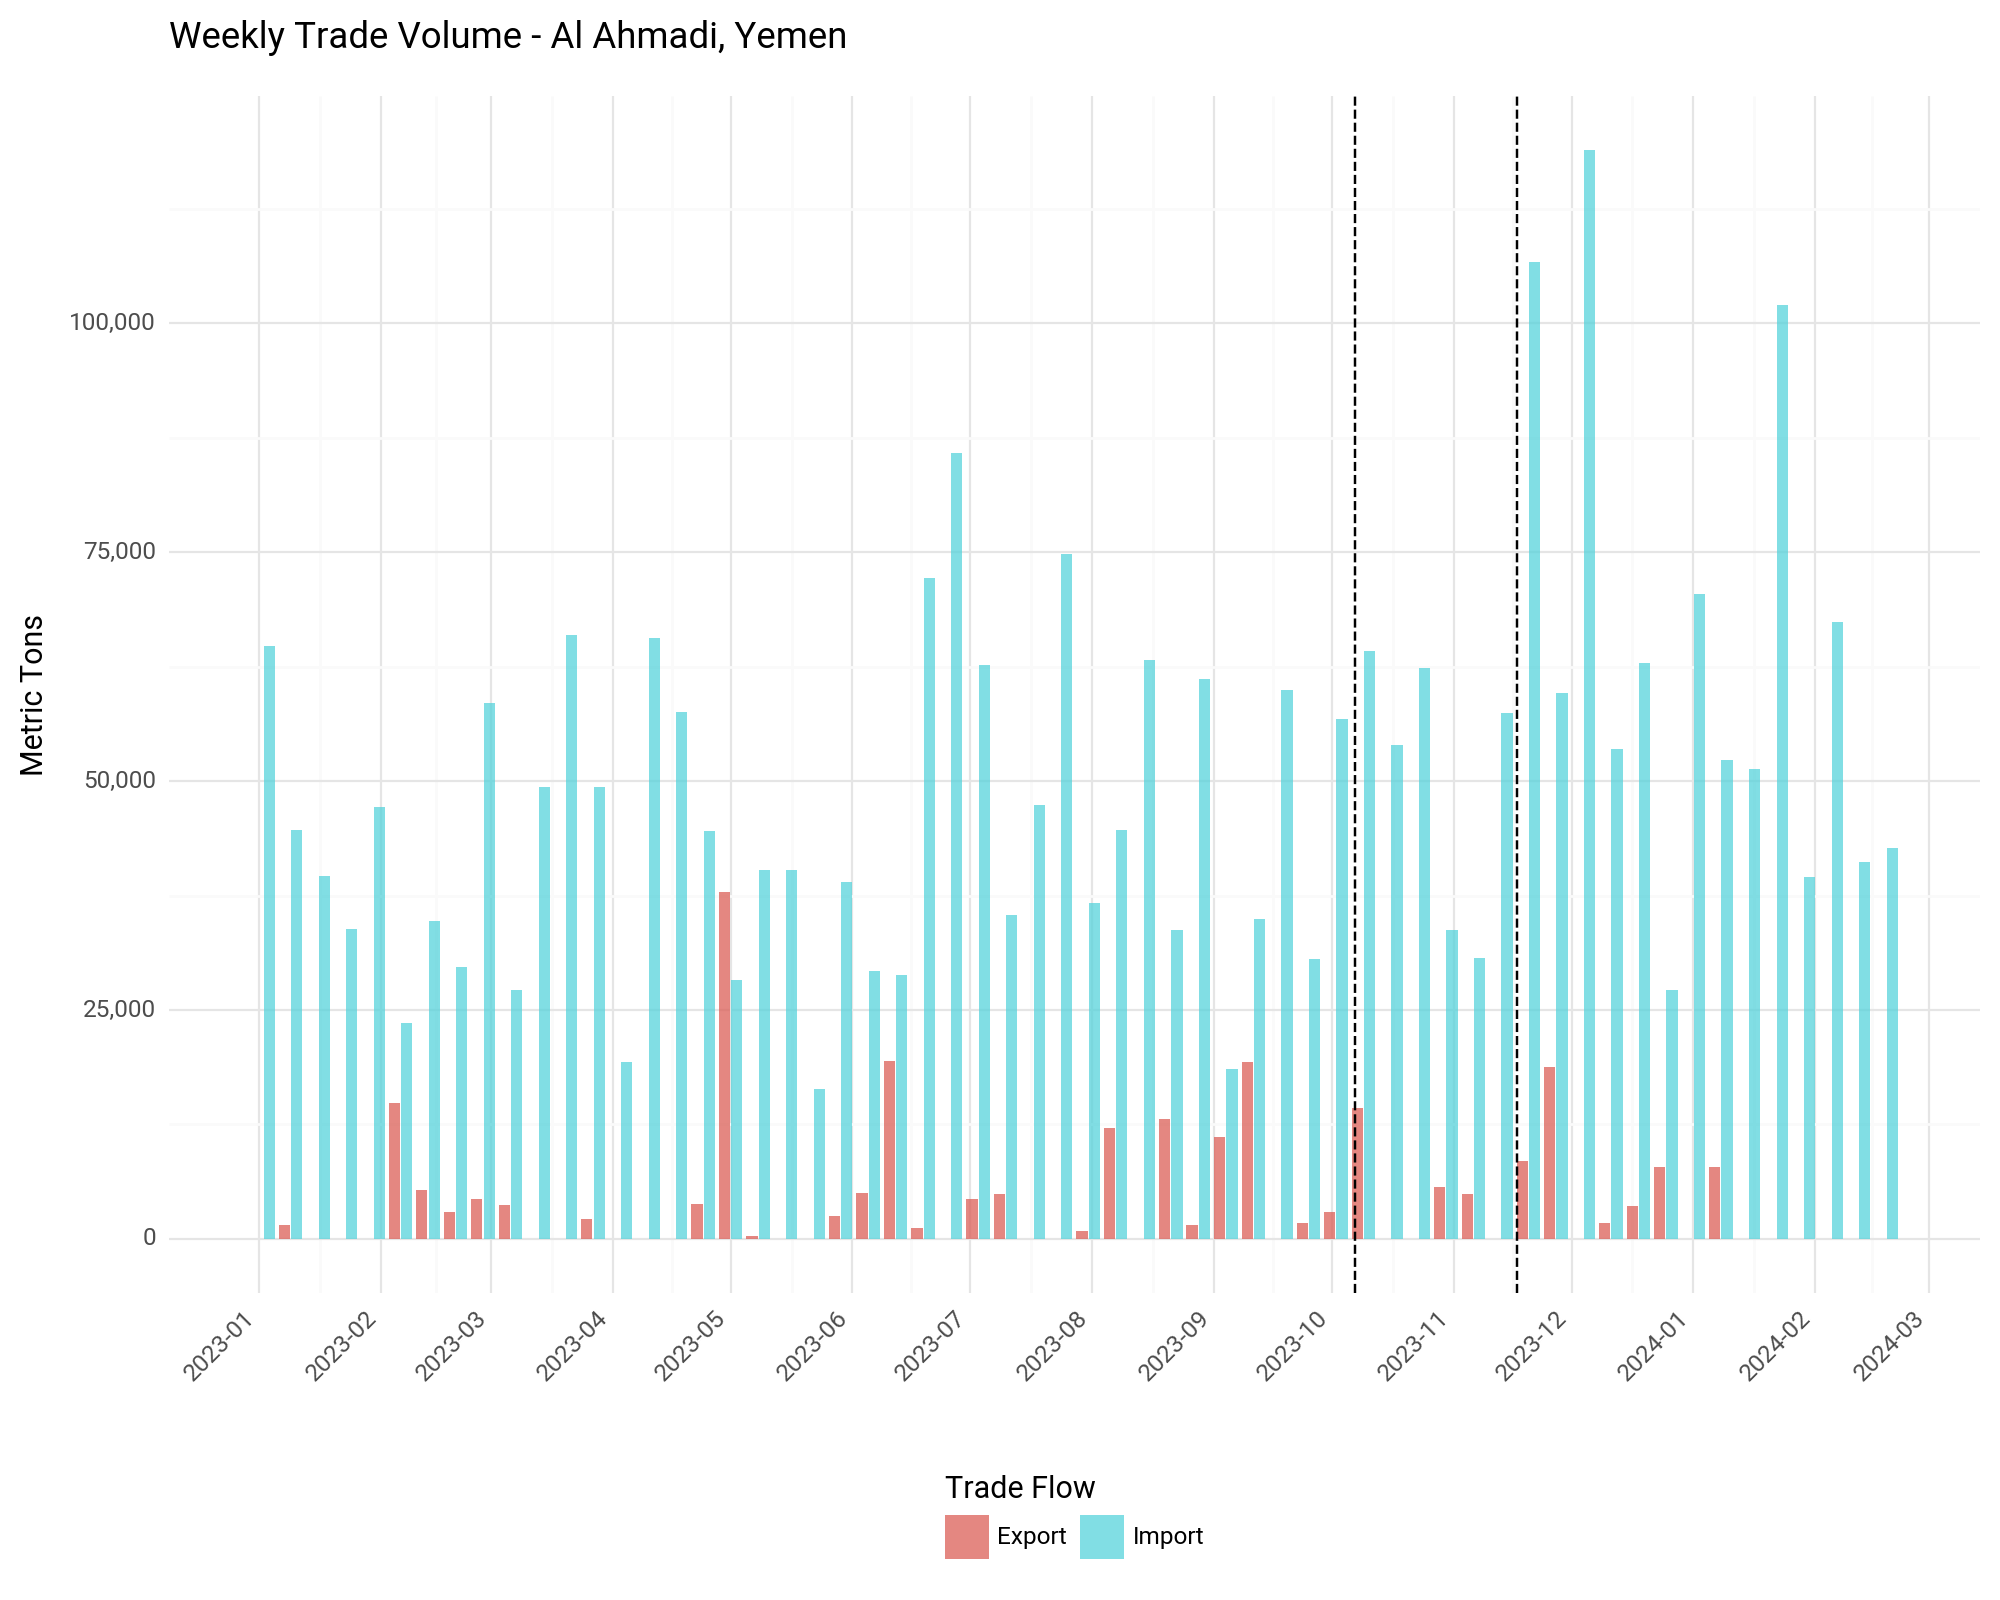

<Figure Size: (1000 x 800)>

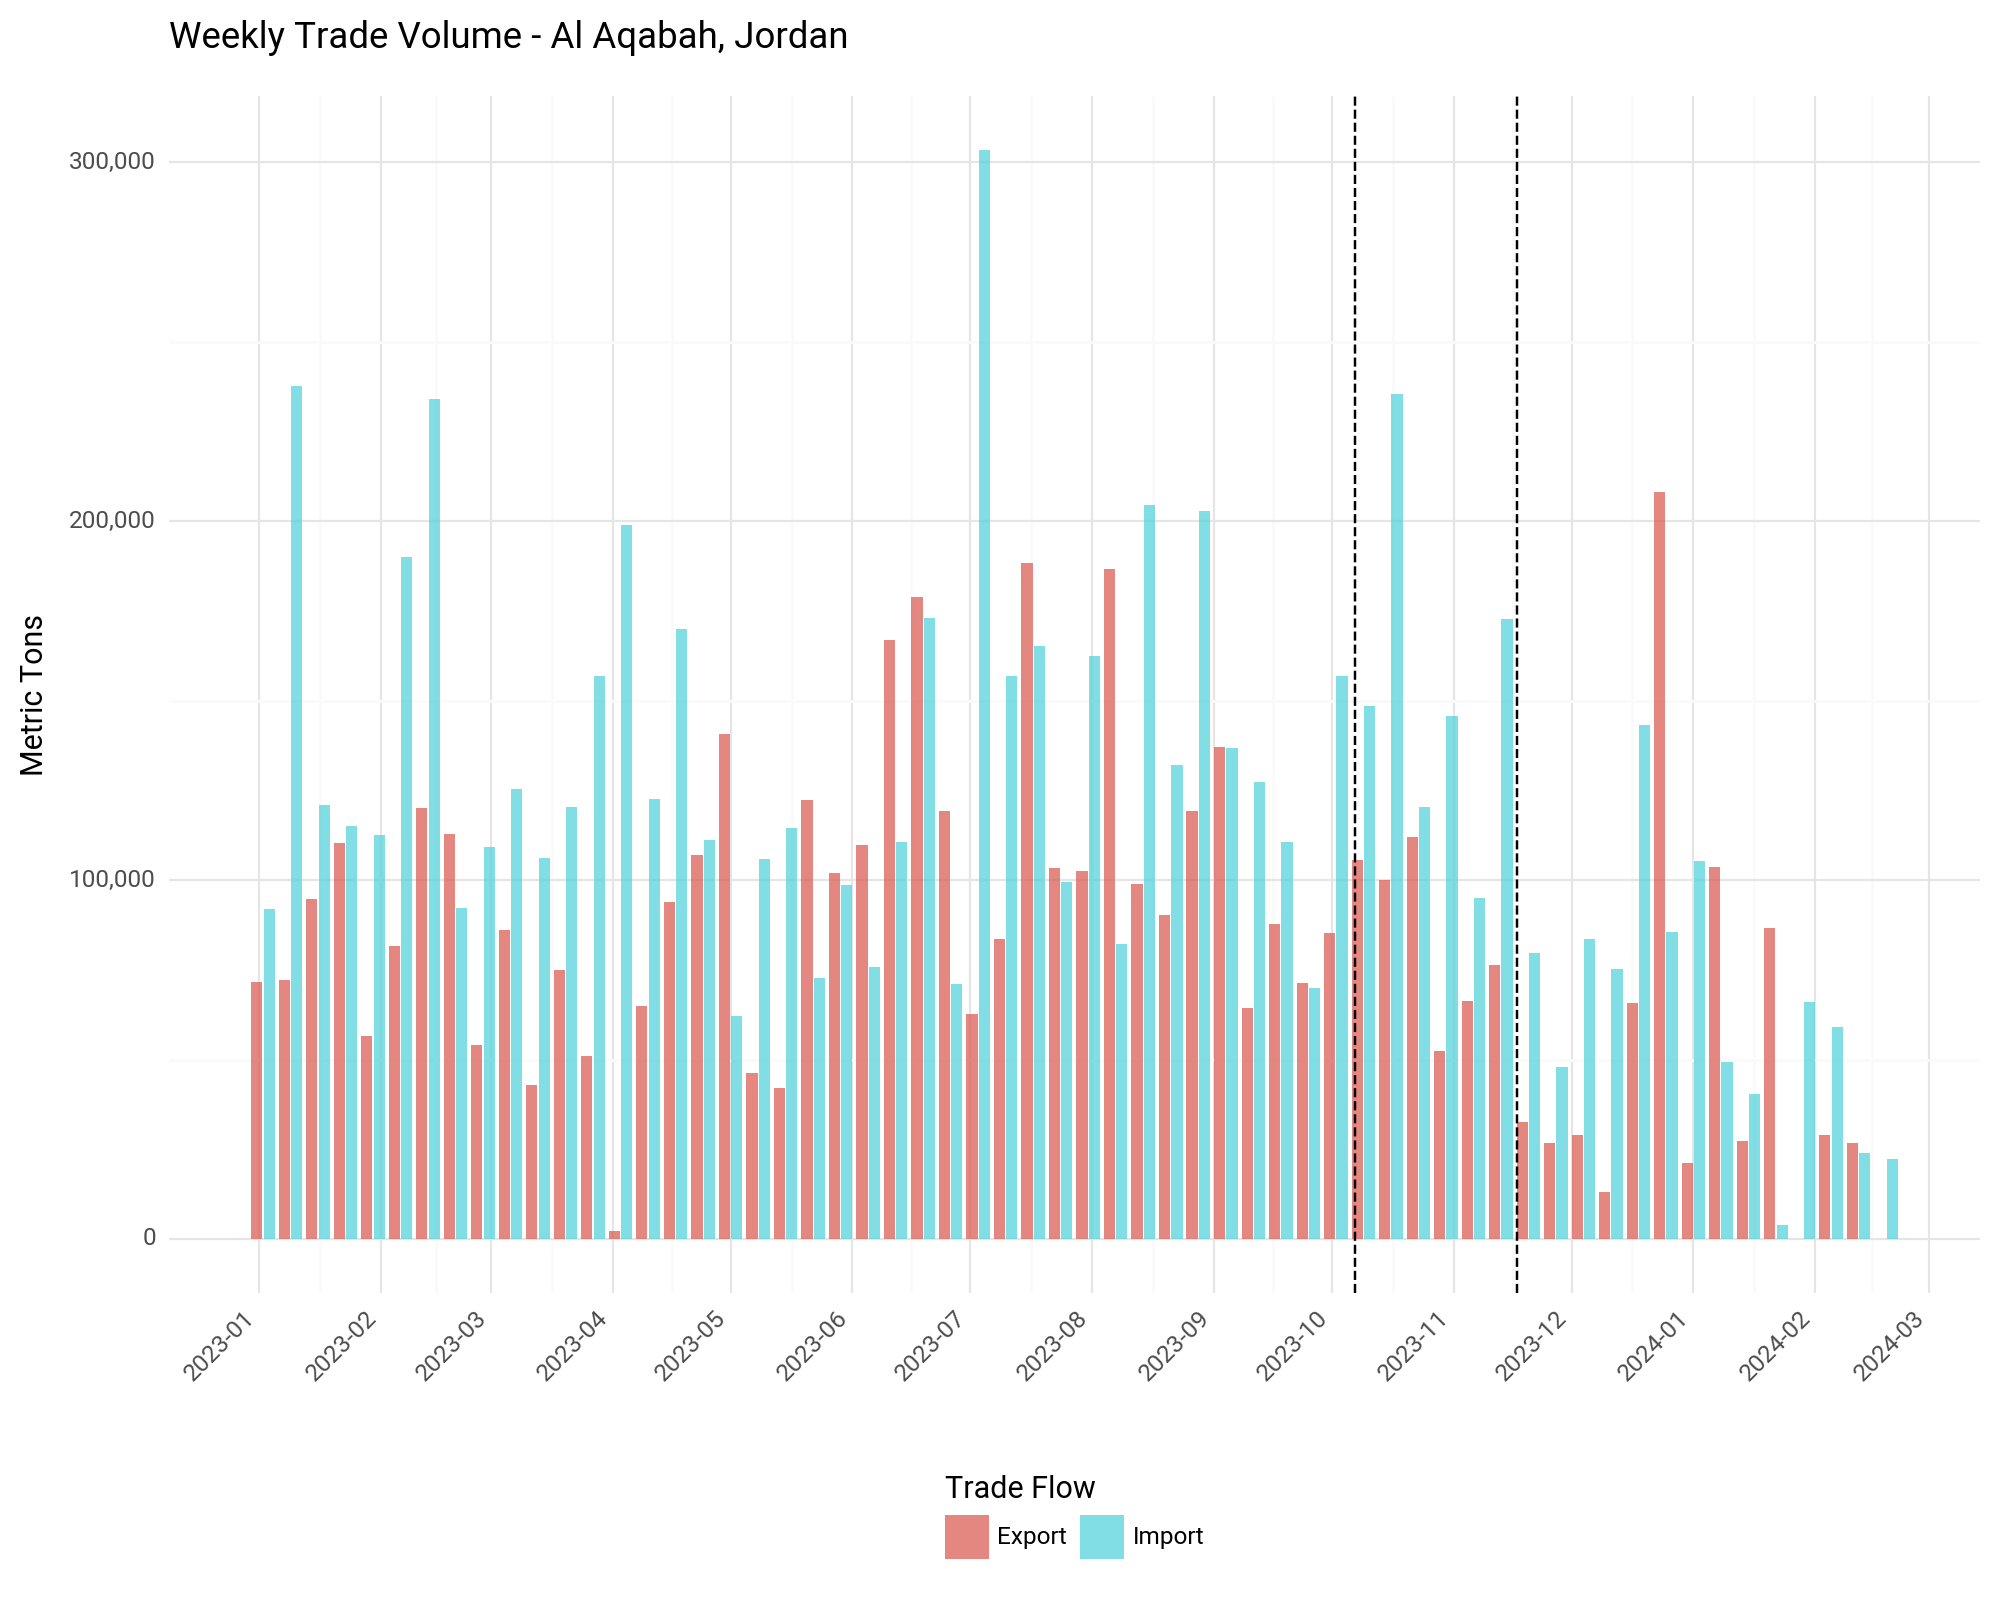

<Figure Size: (1000 x 800)>

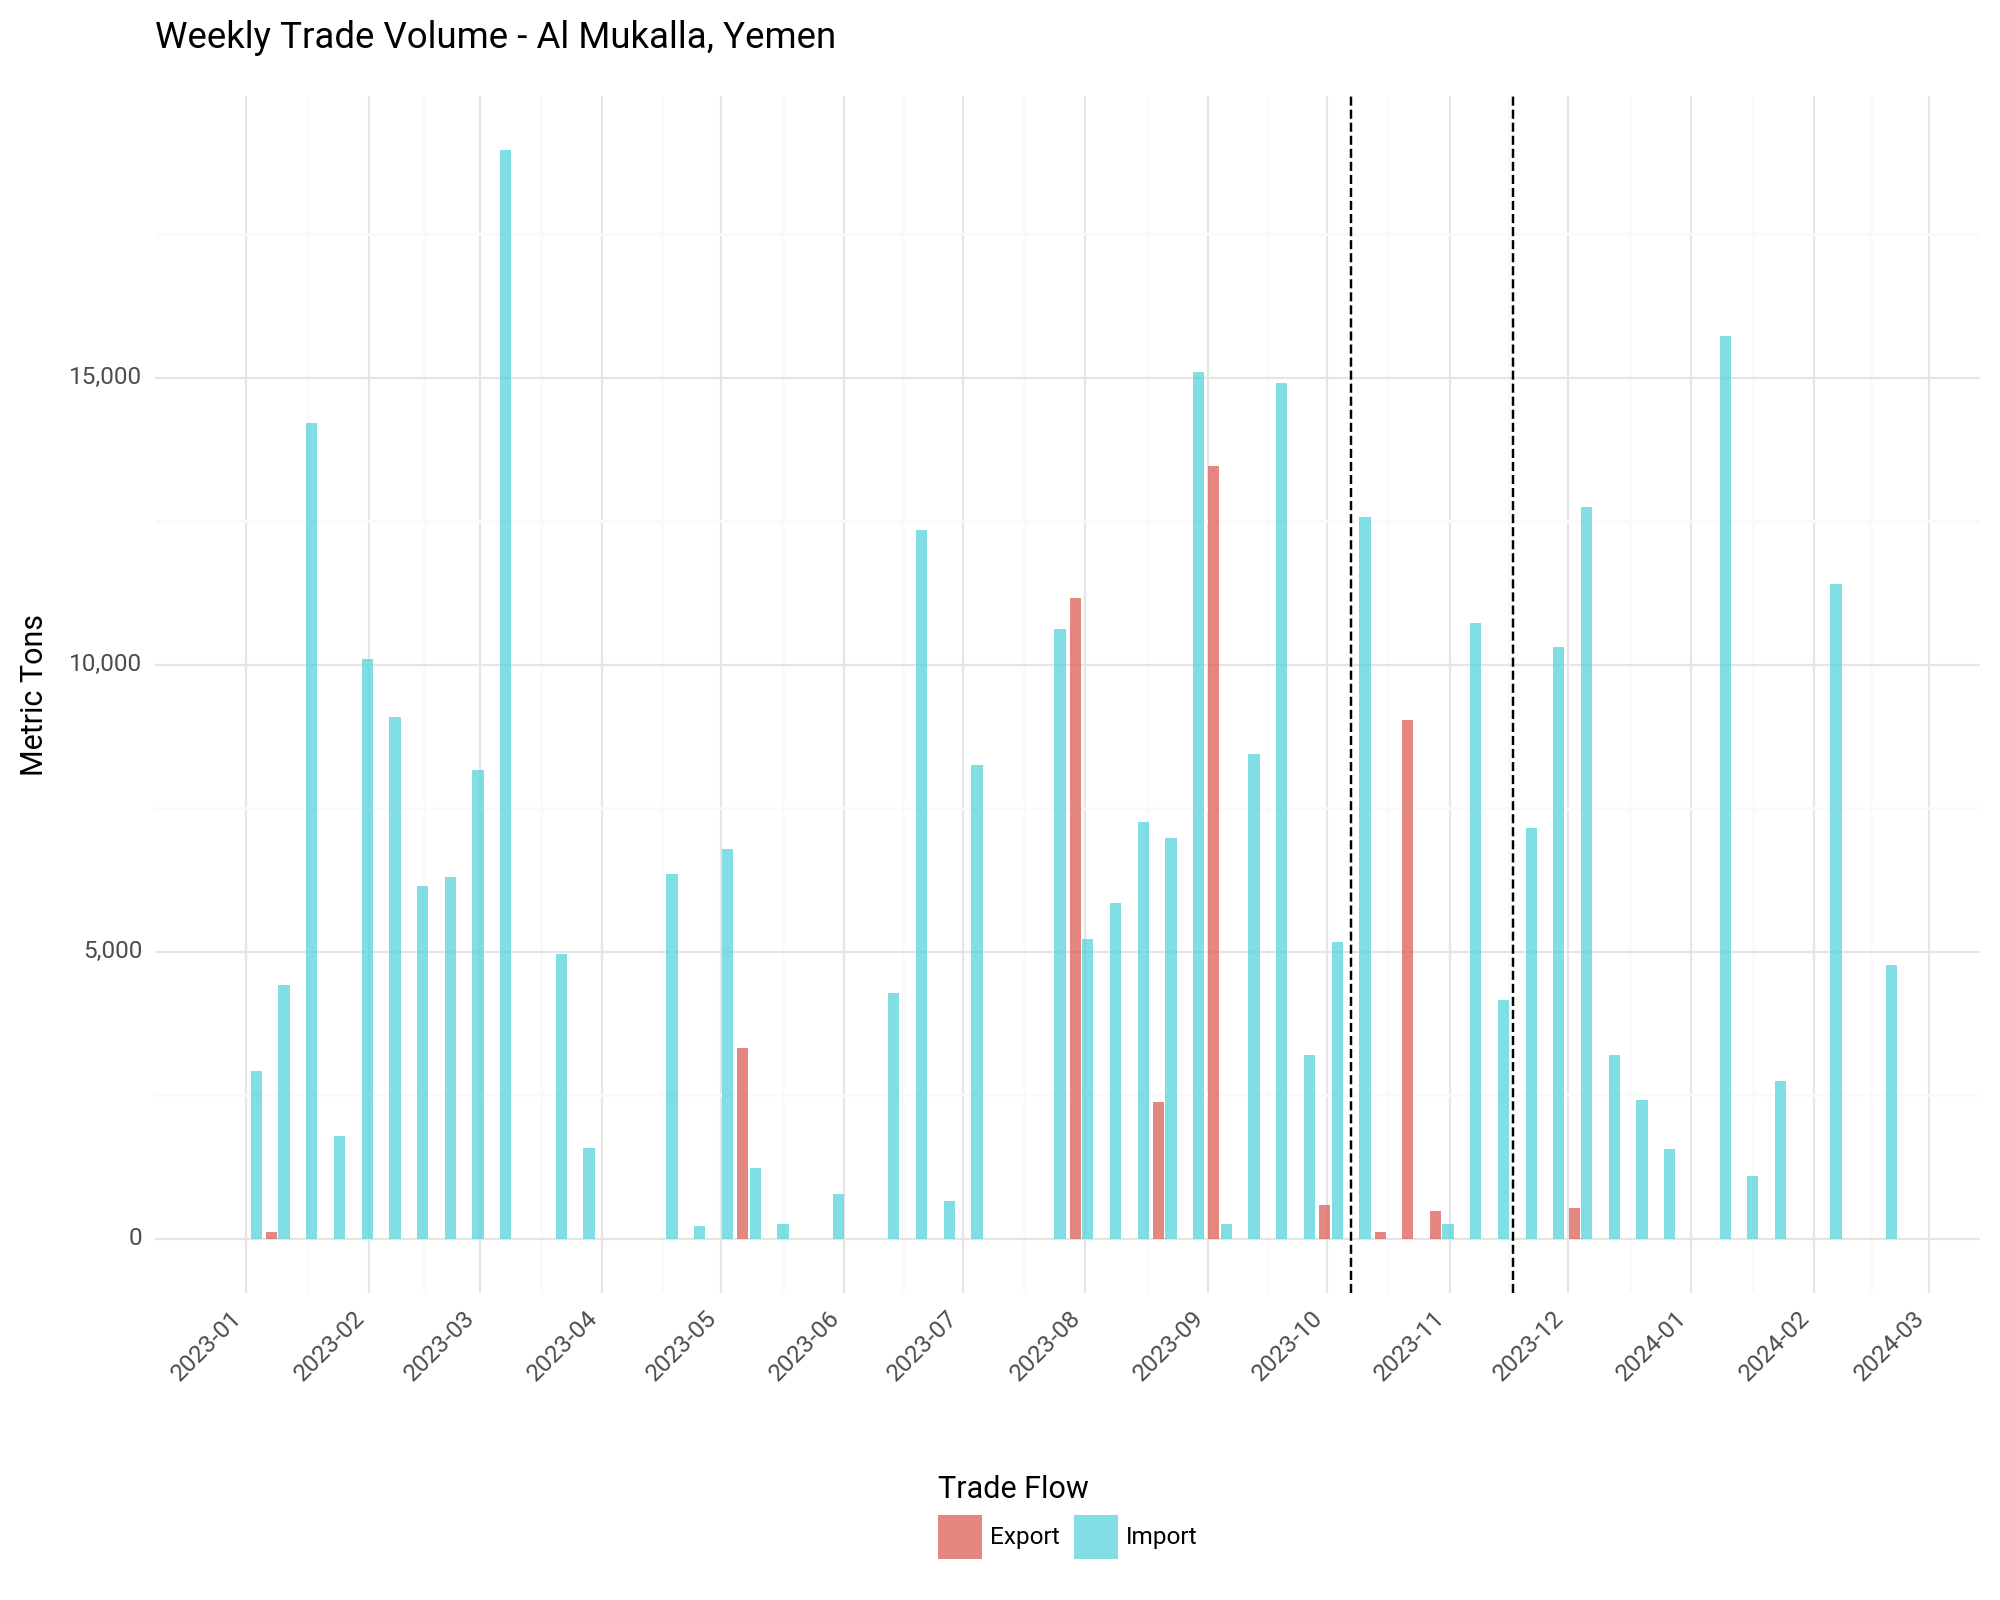

<Figure Size: (1000 x 800)>

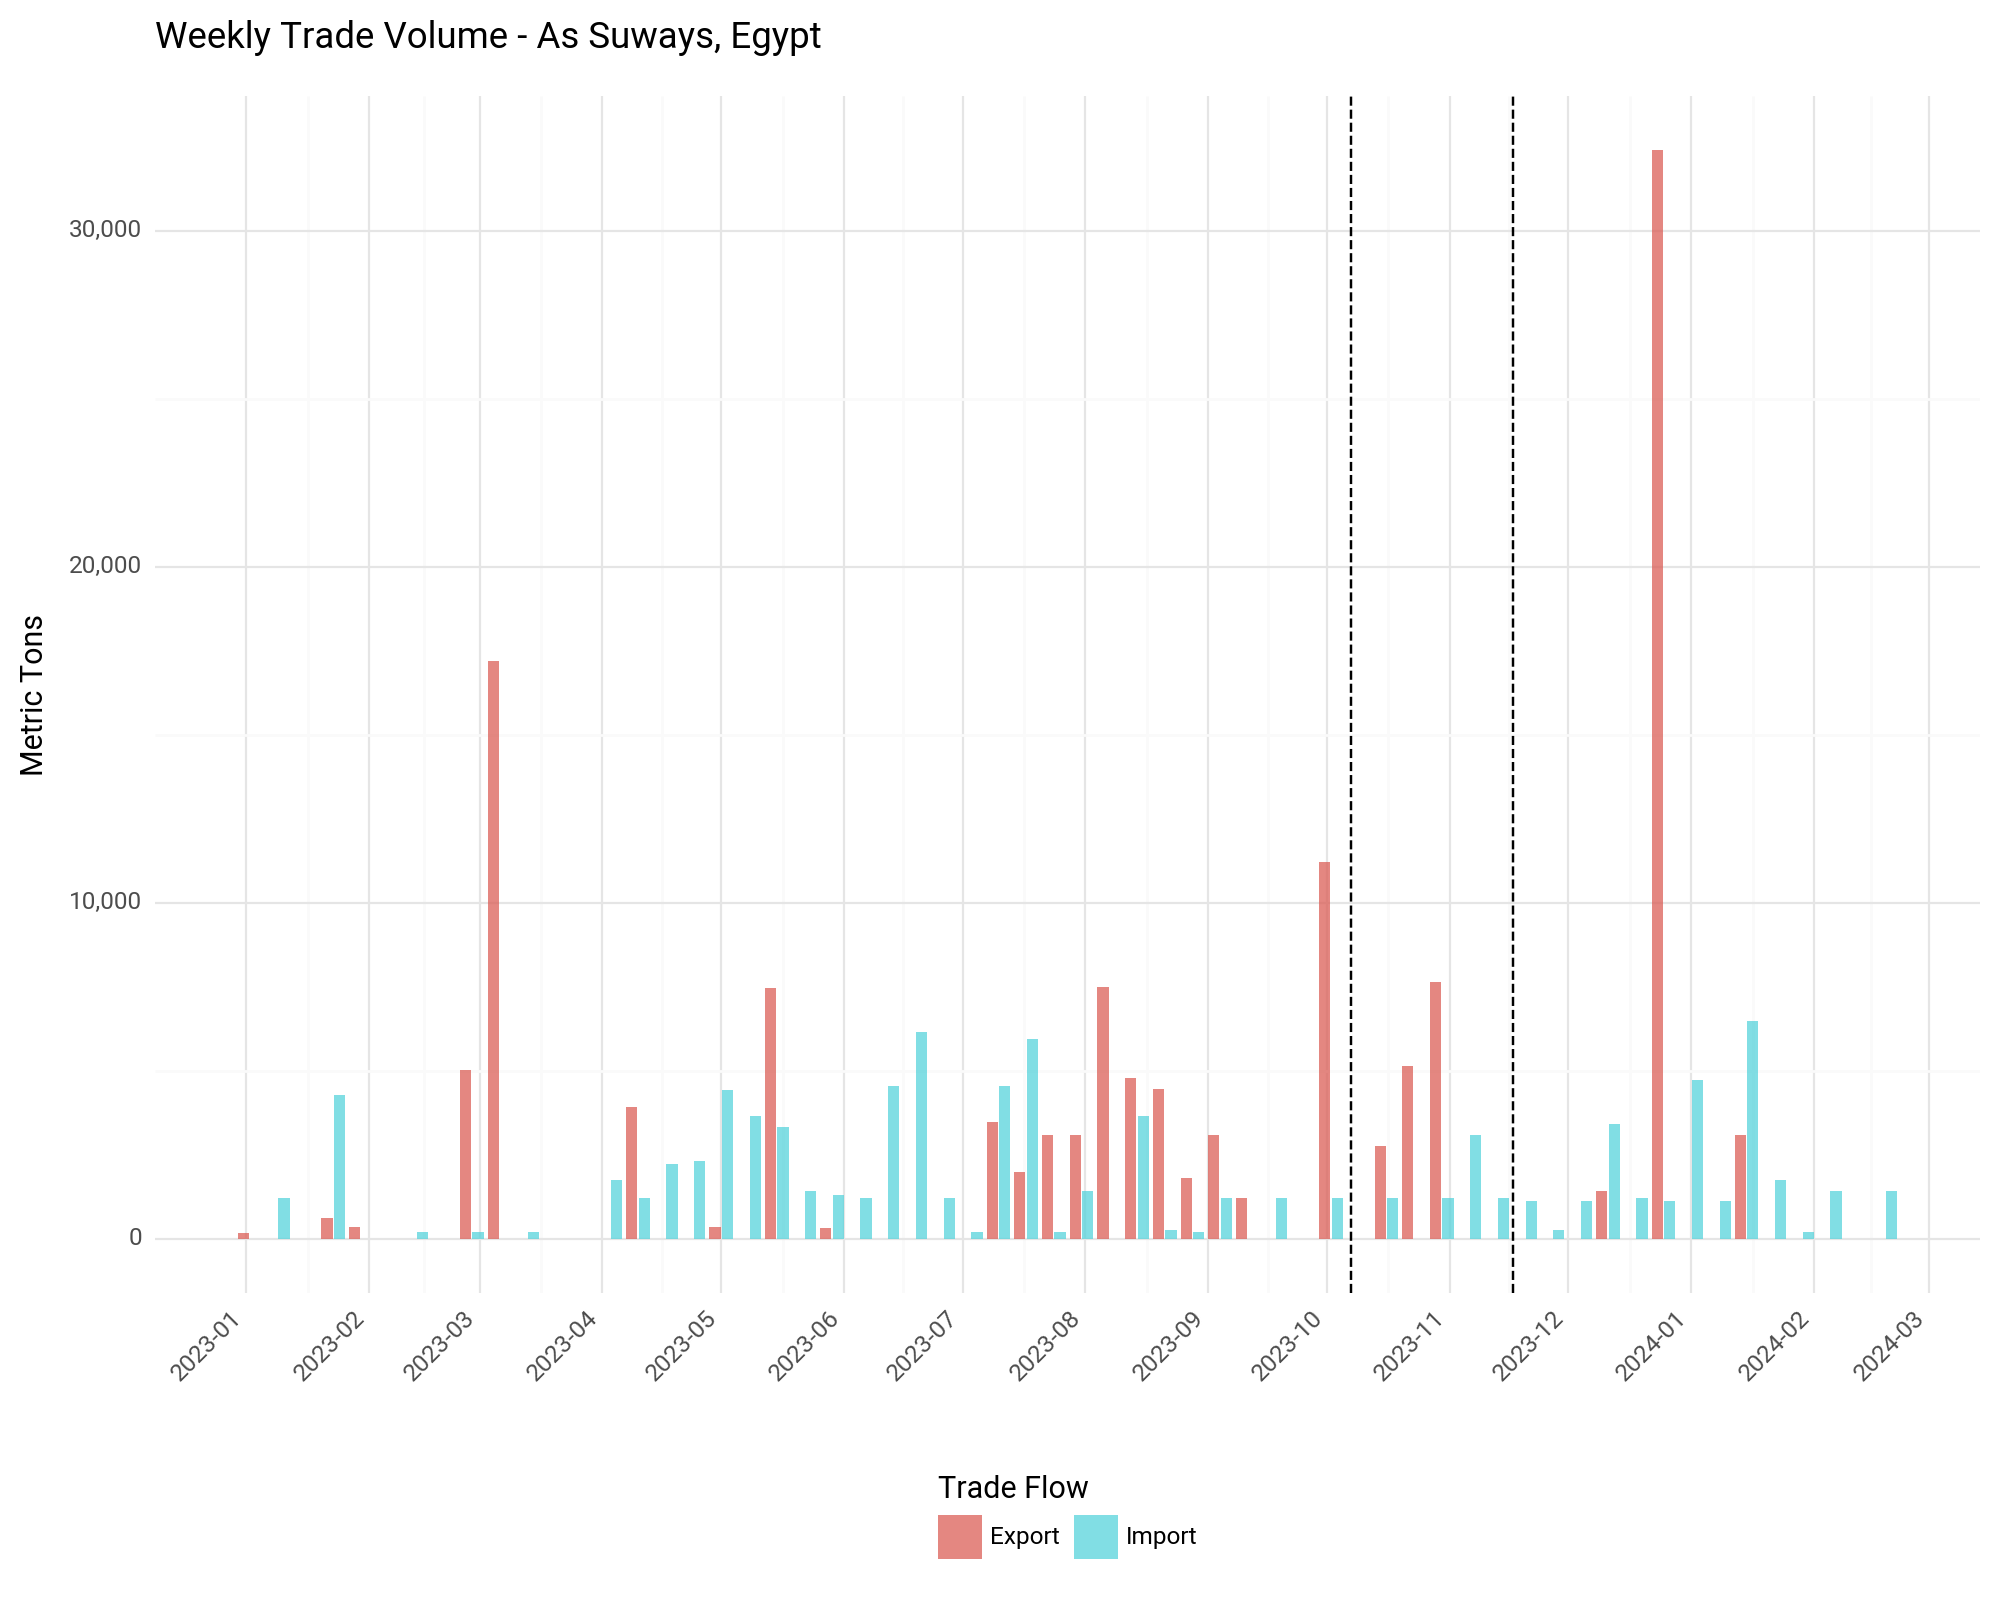

<Figure Size: (1000 x 800)>

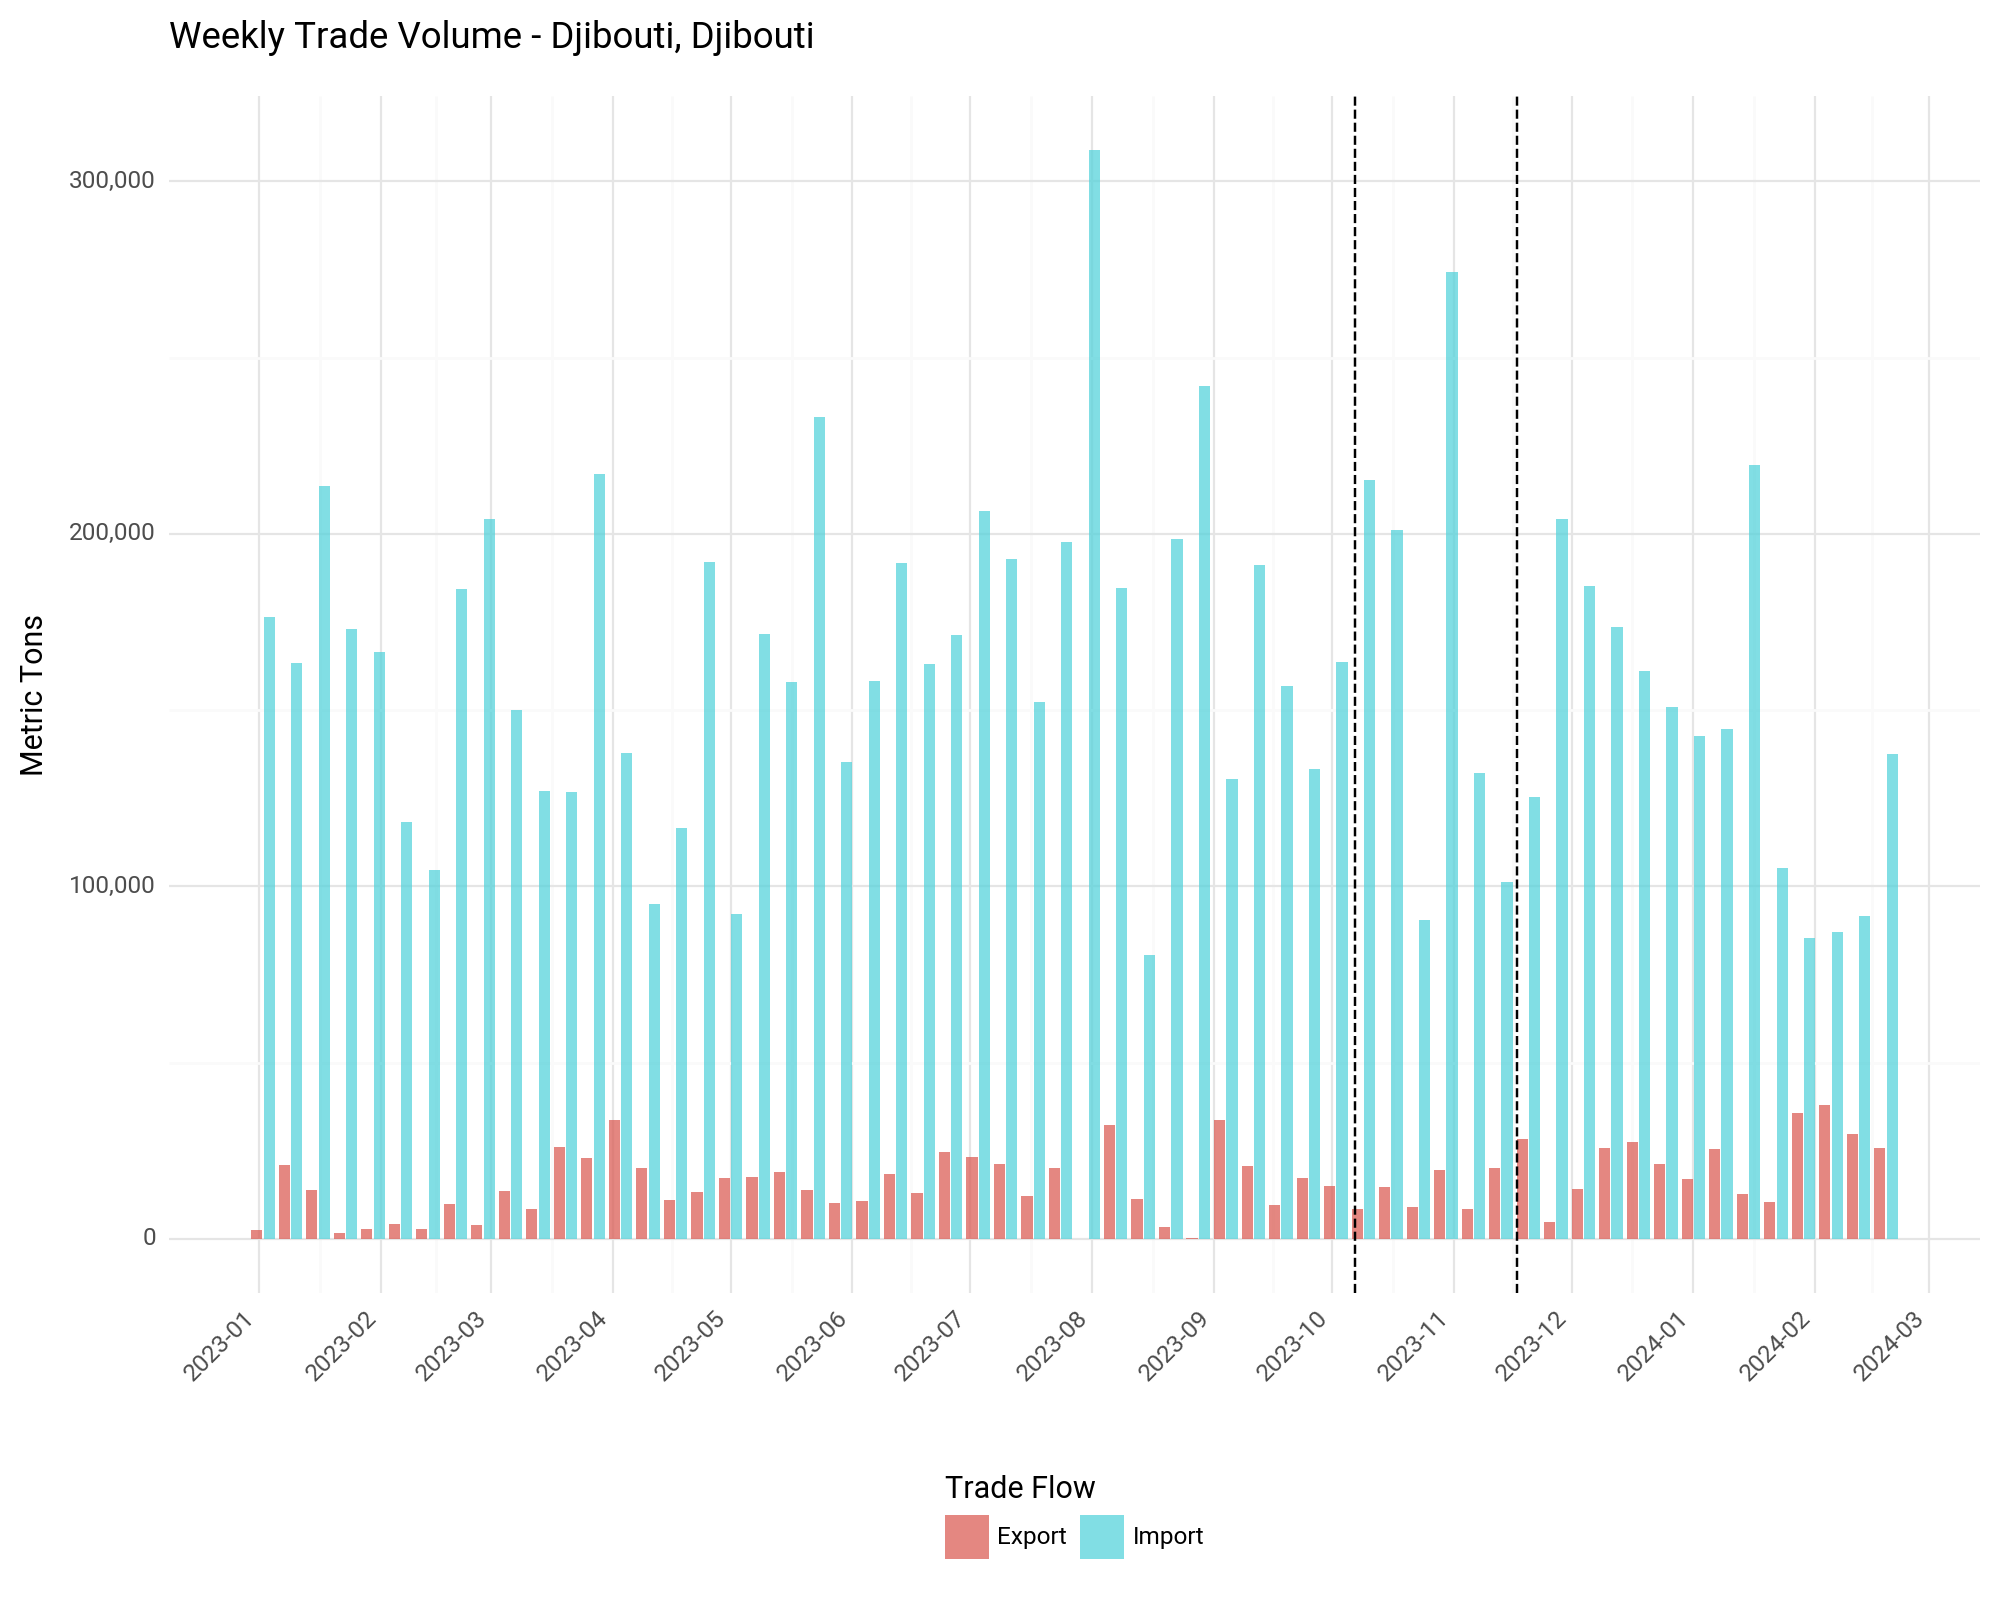

<Figure Size: (1000 x 800)>

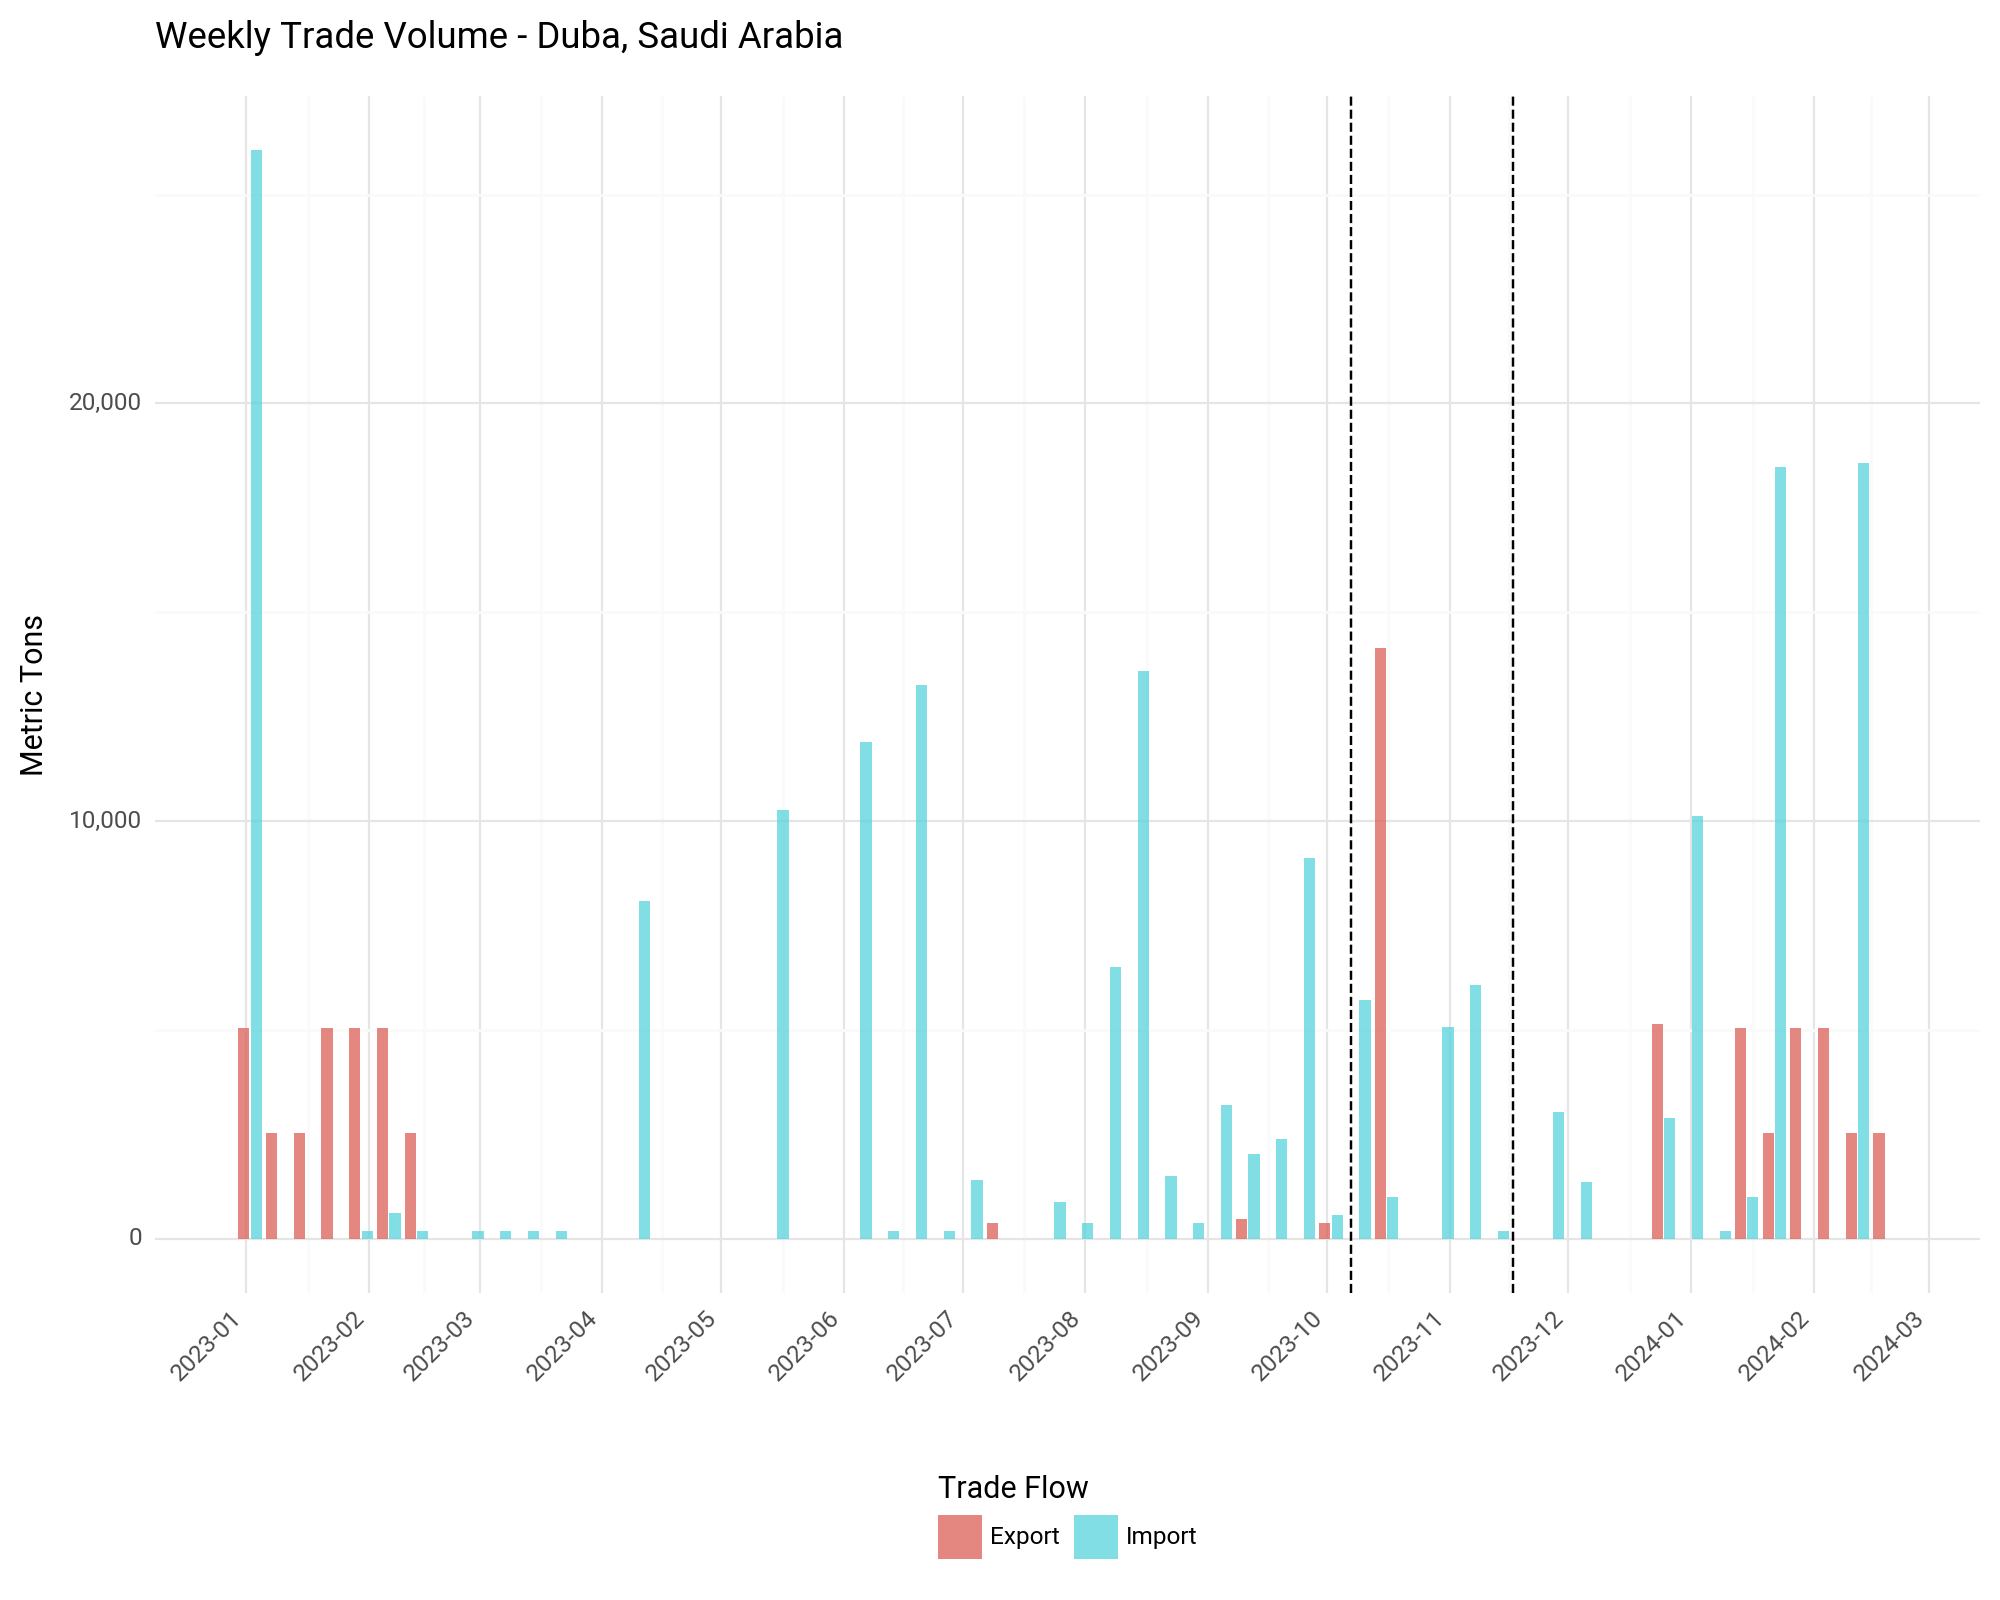

<Figure Size: (1000 x 800)>

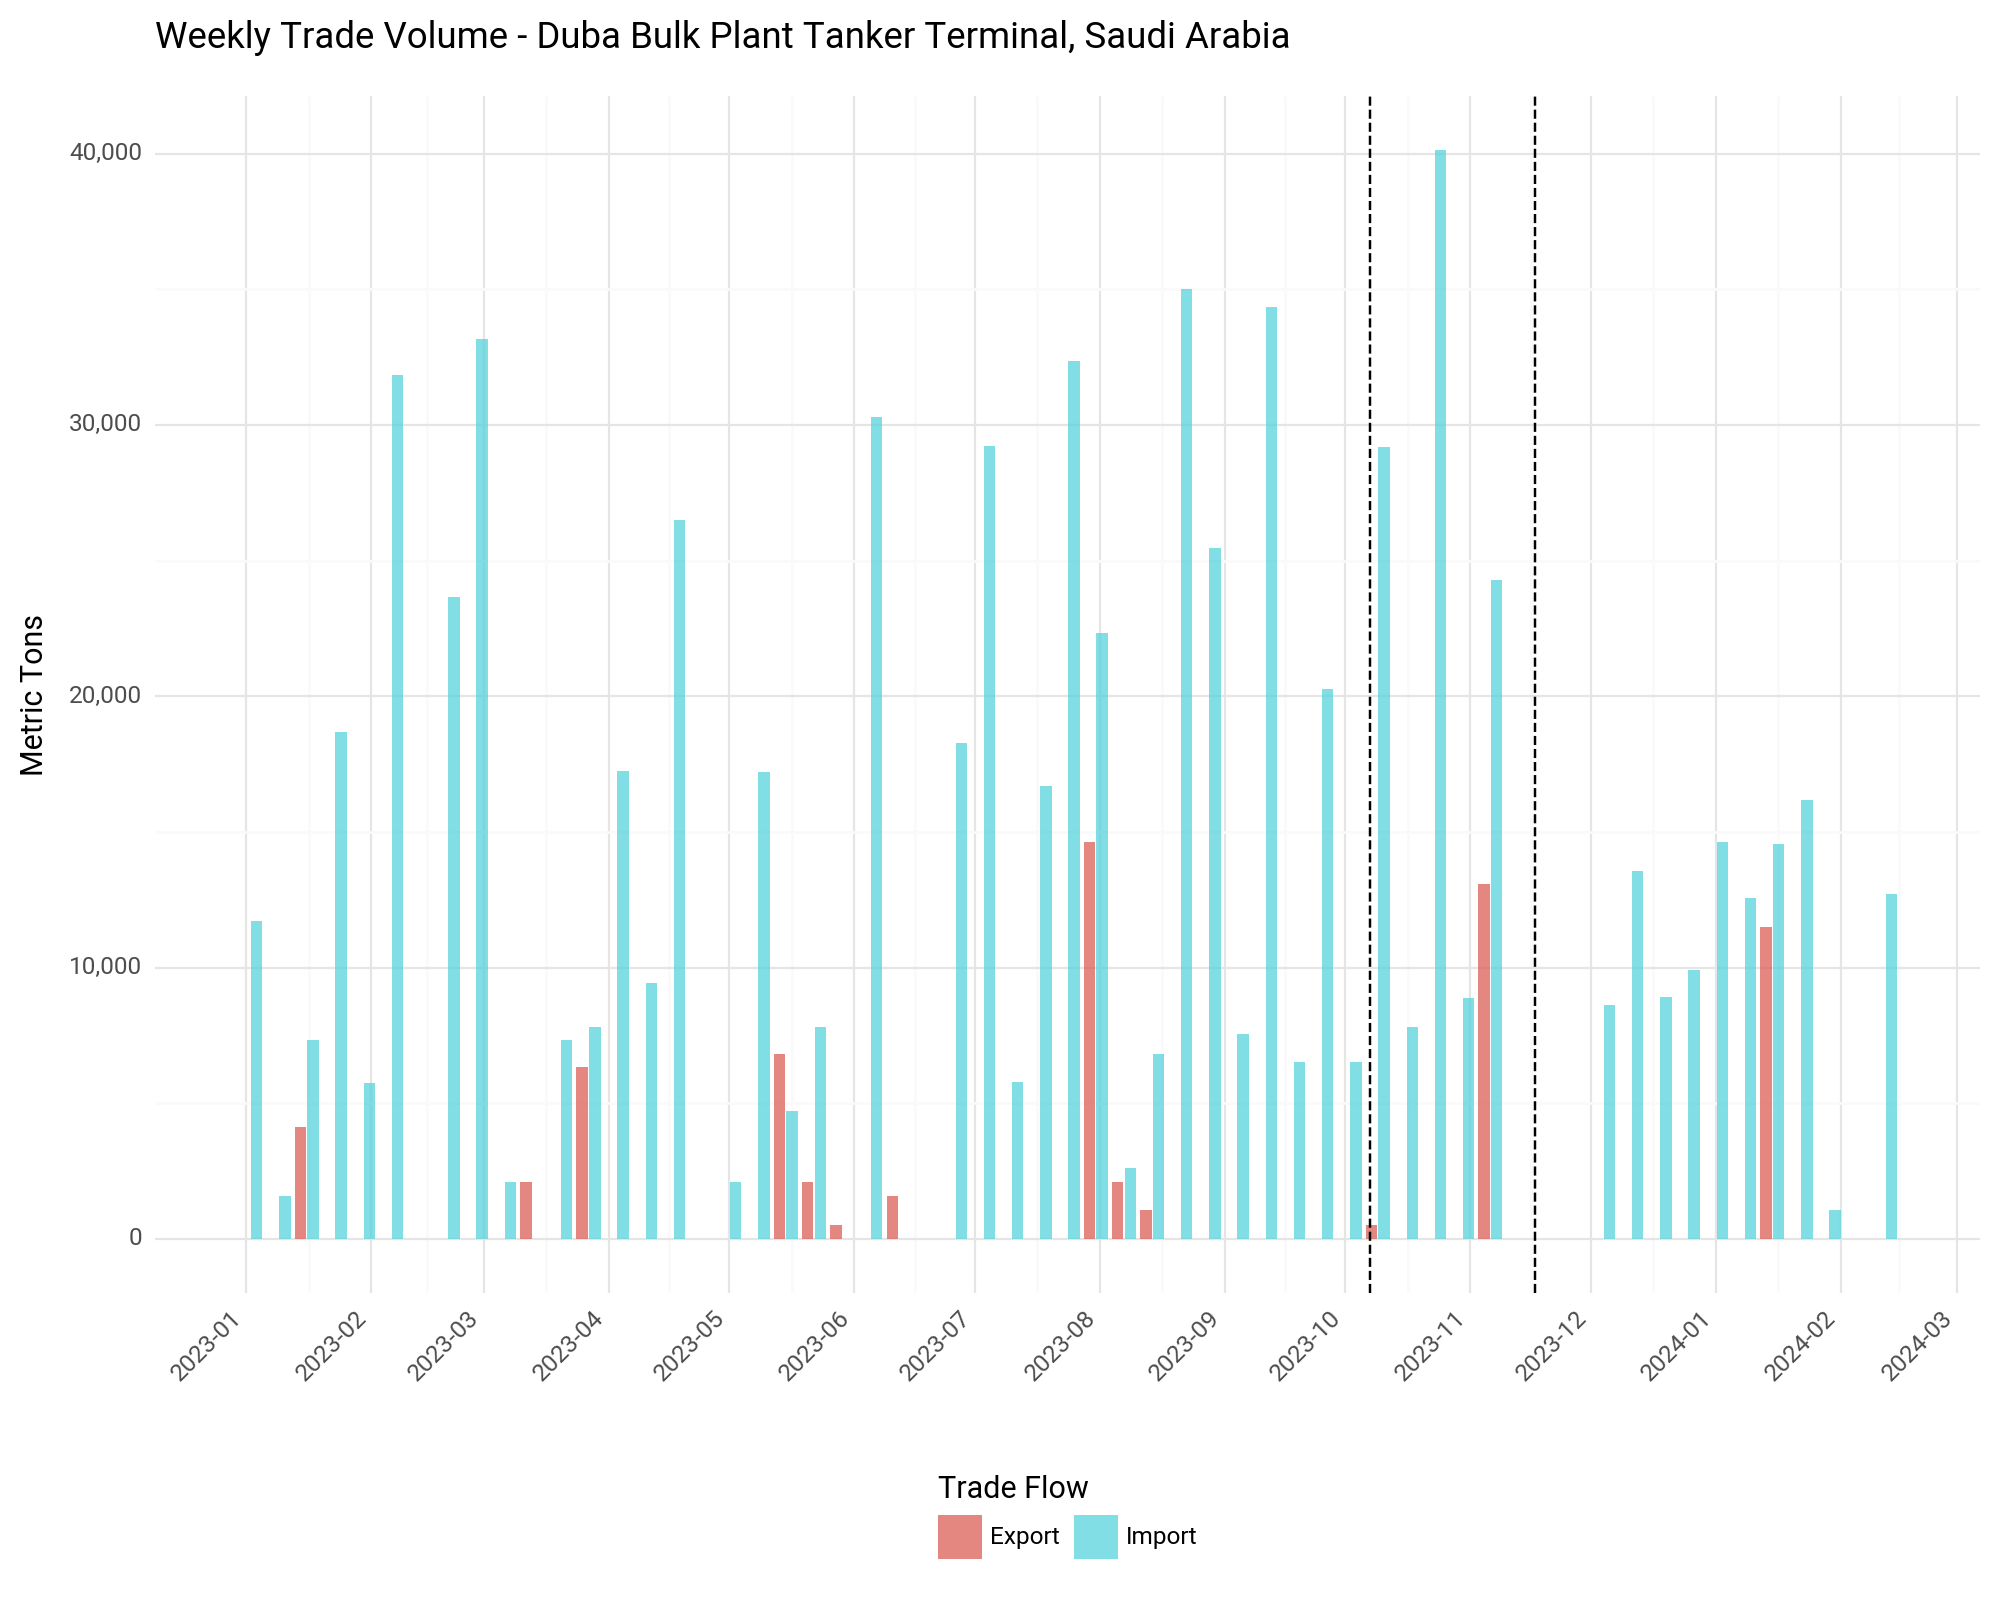

<Figure Size: (1000 x 800)>

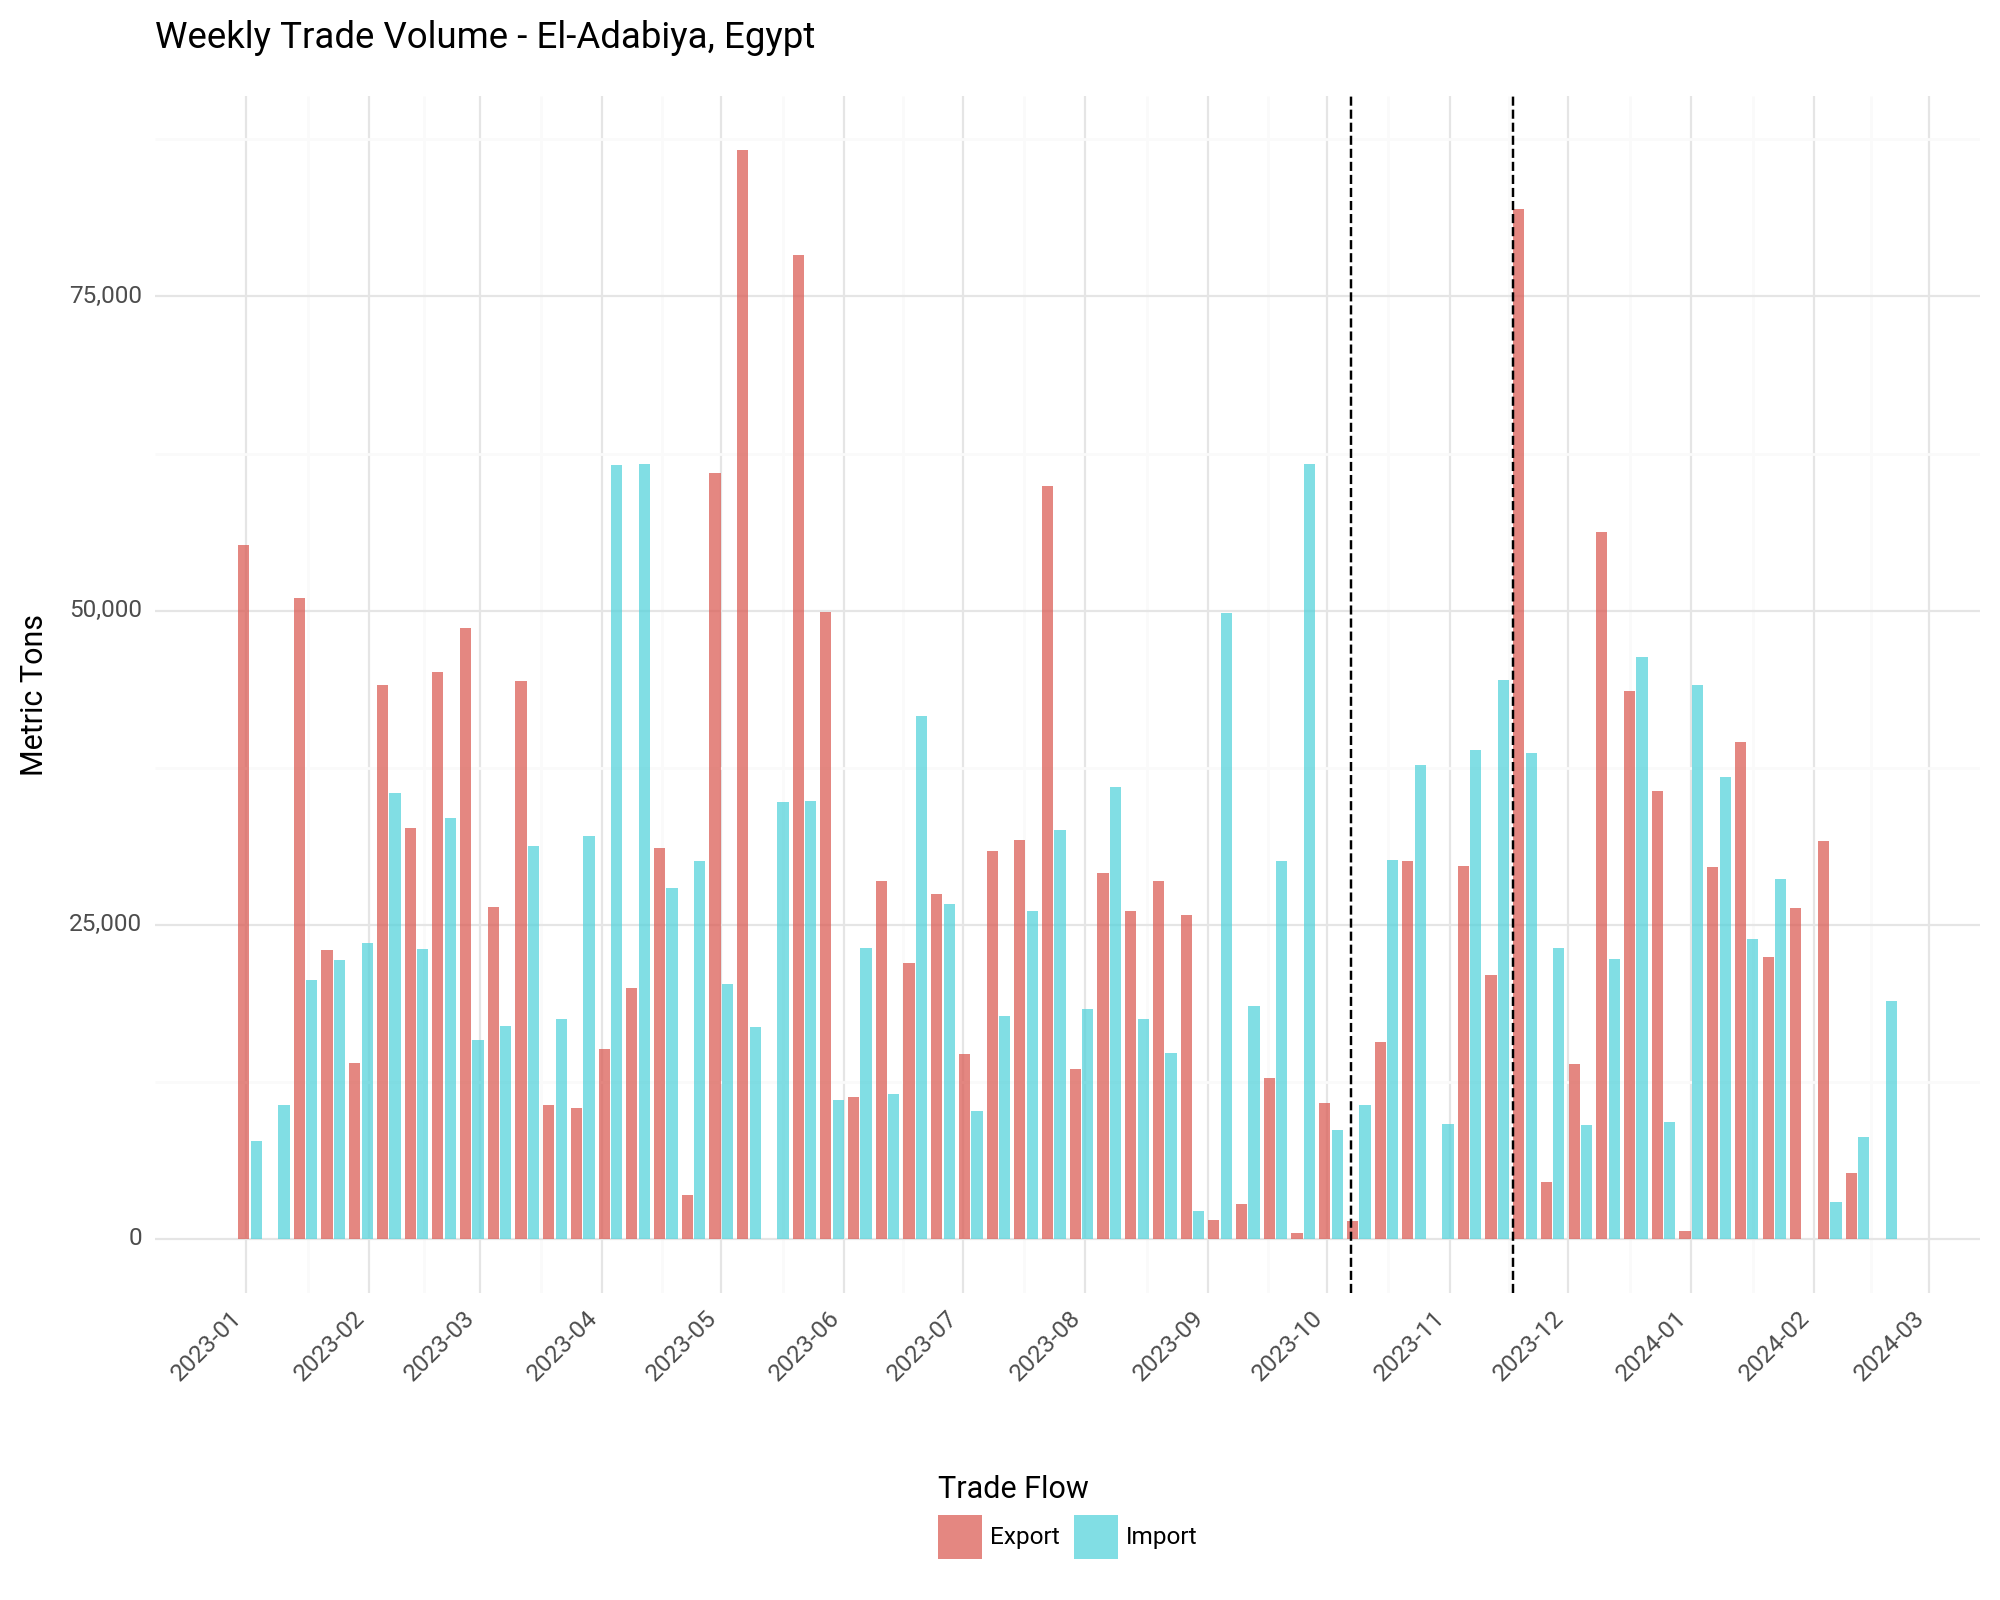

<Figure Size: (1000 x 800)>

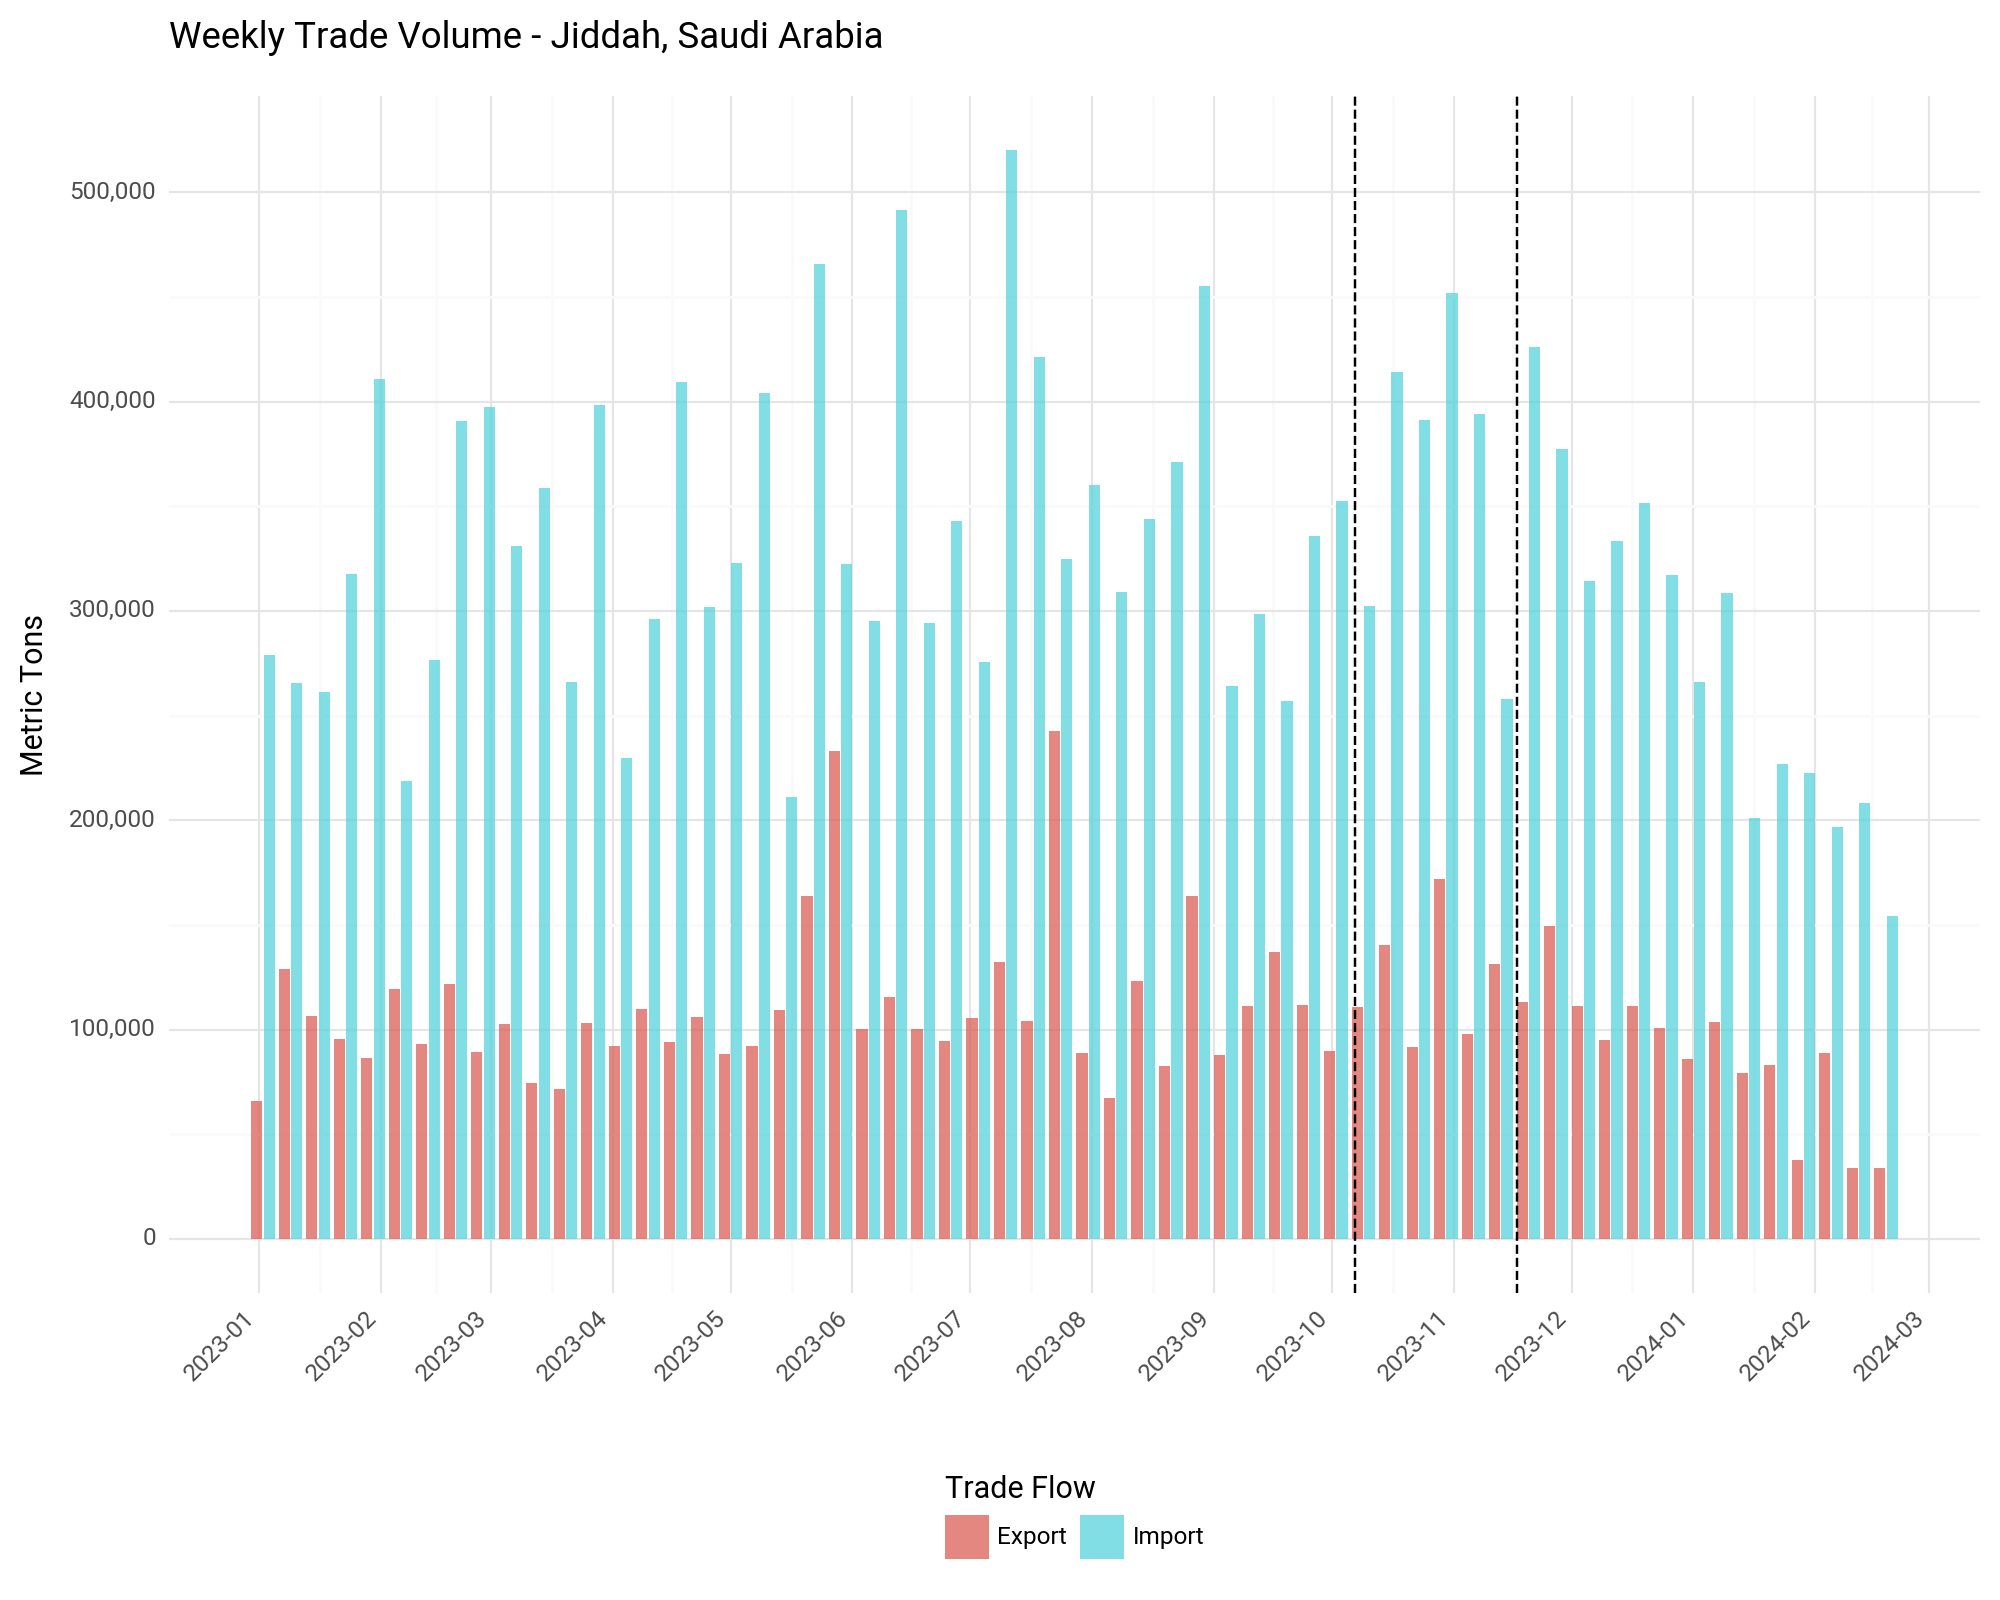

<Figure Size: (1000 x 800)>

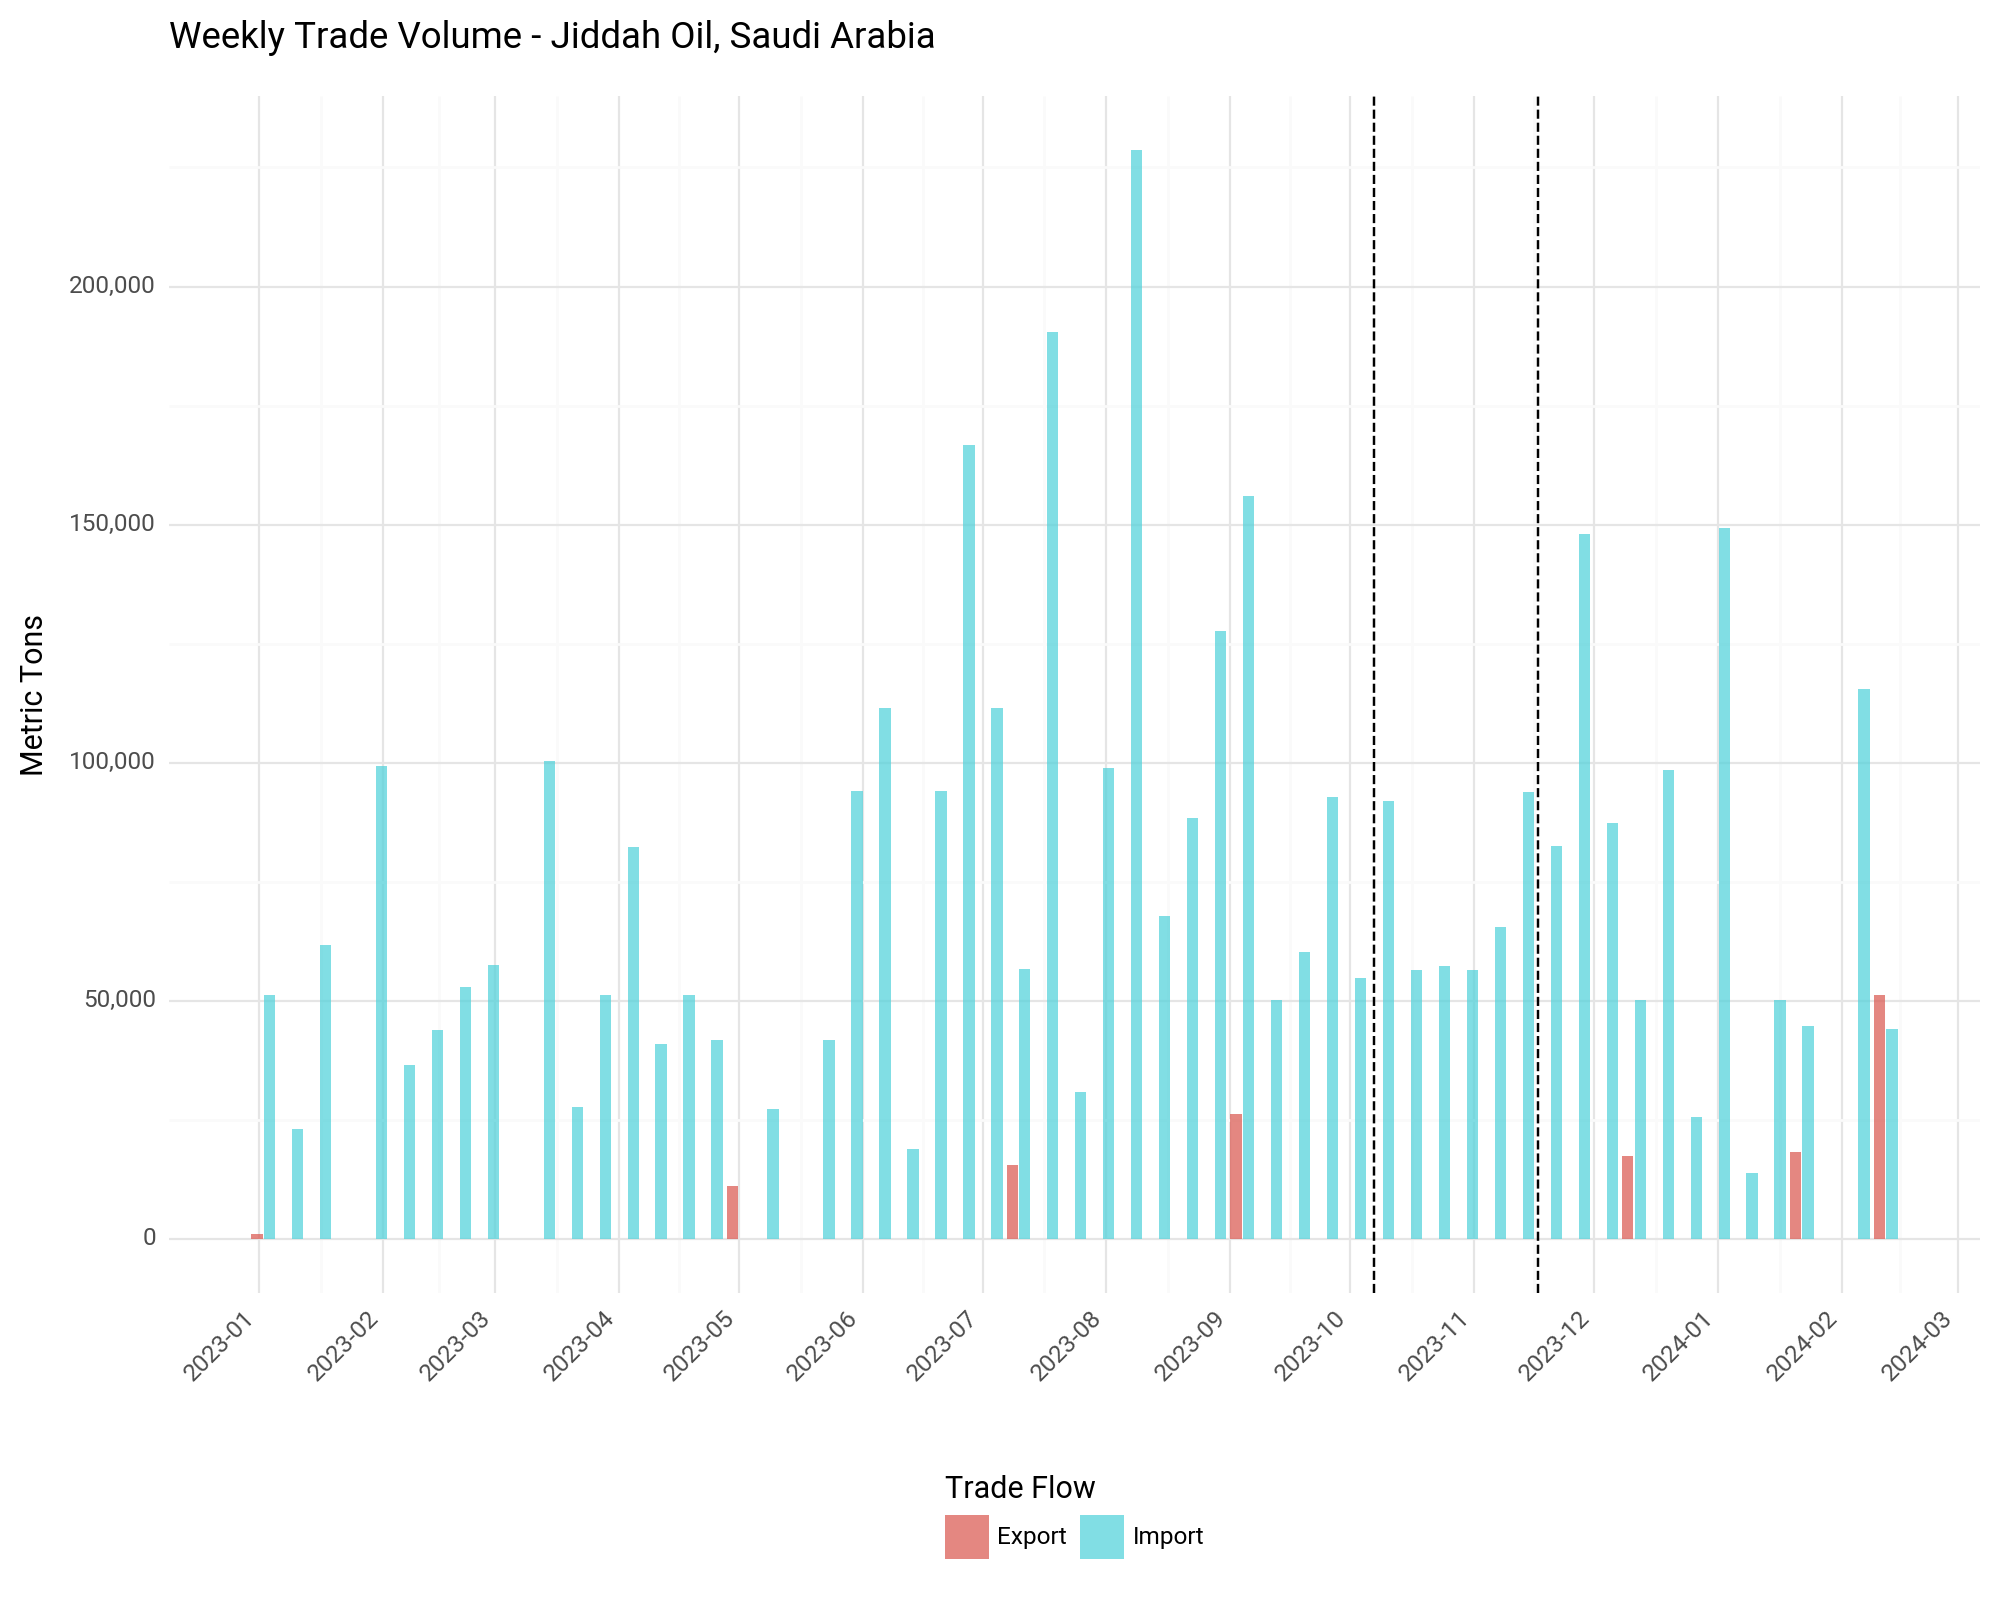

<Figure Size: (1000 x 800)>

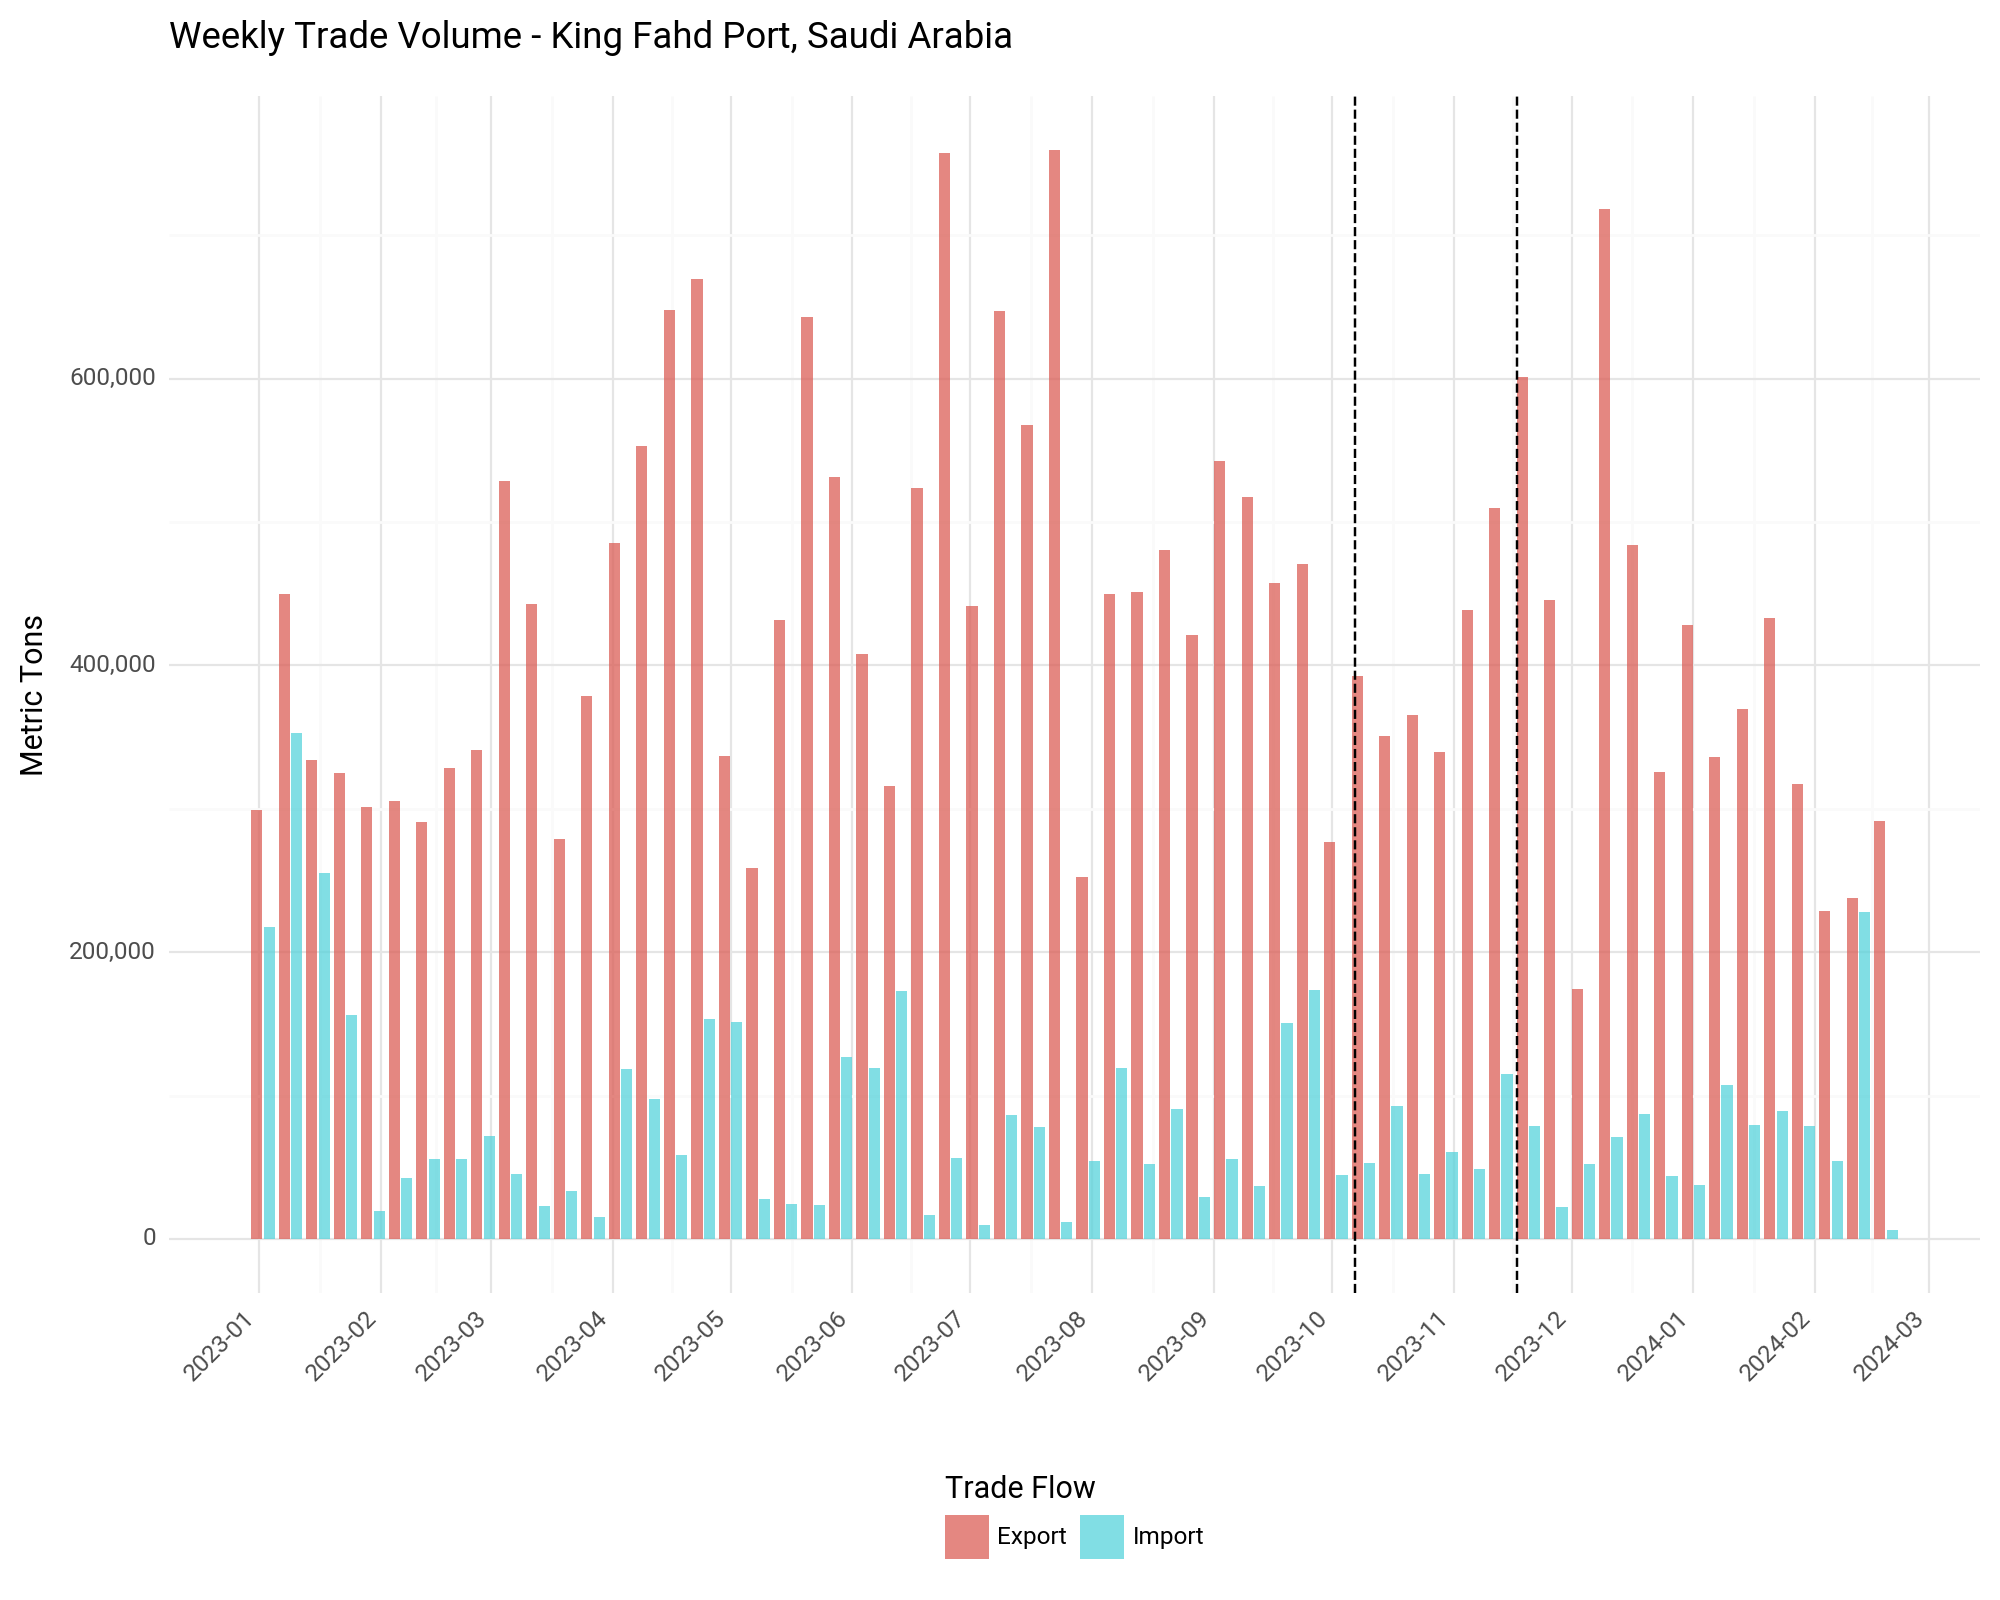

<Figure Size: (1000 x 800)>

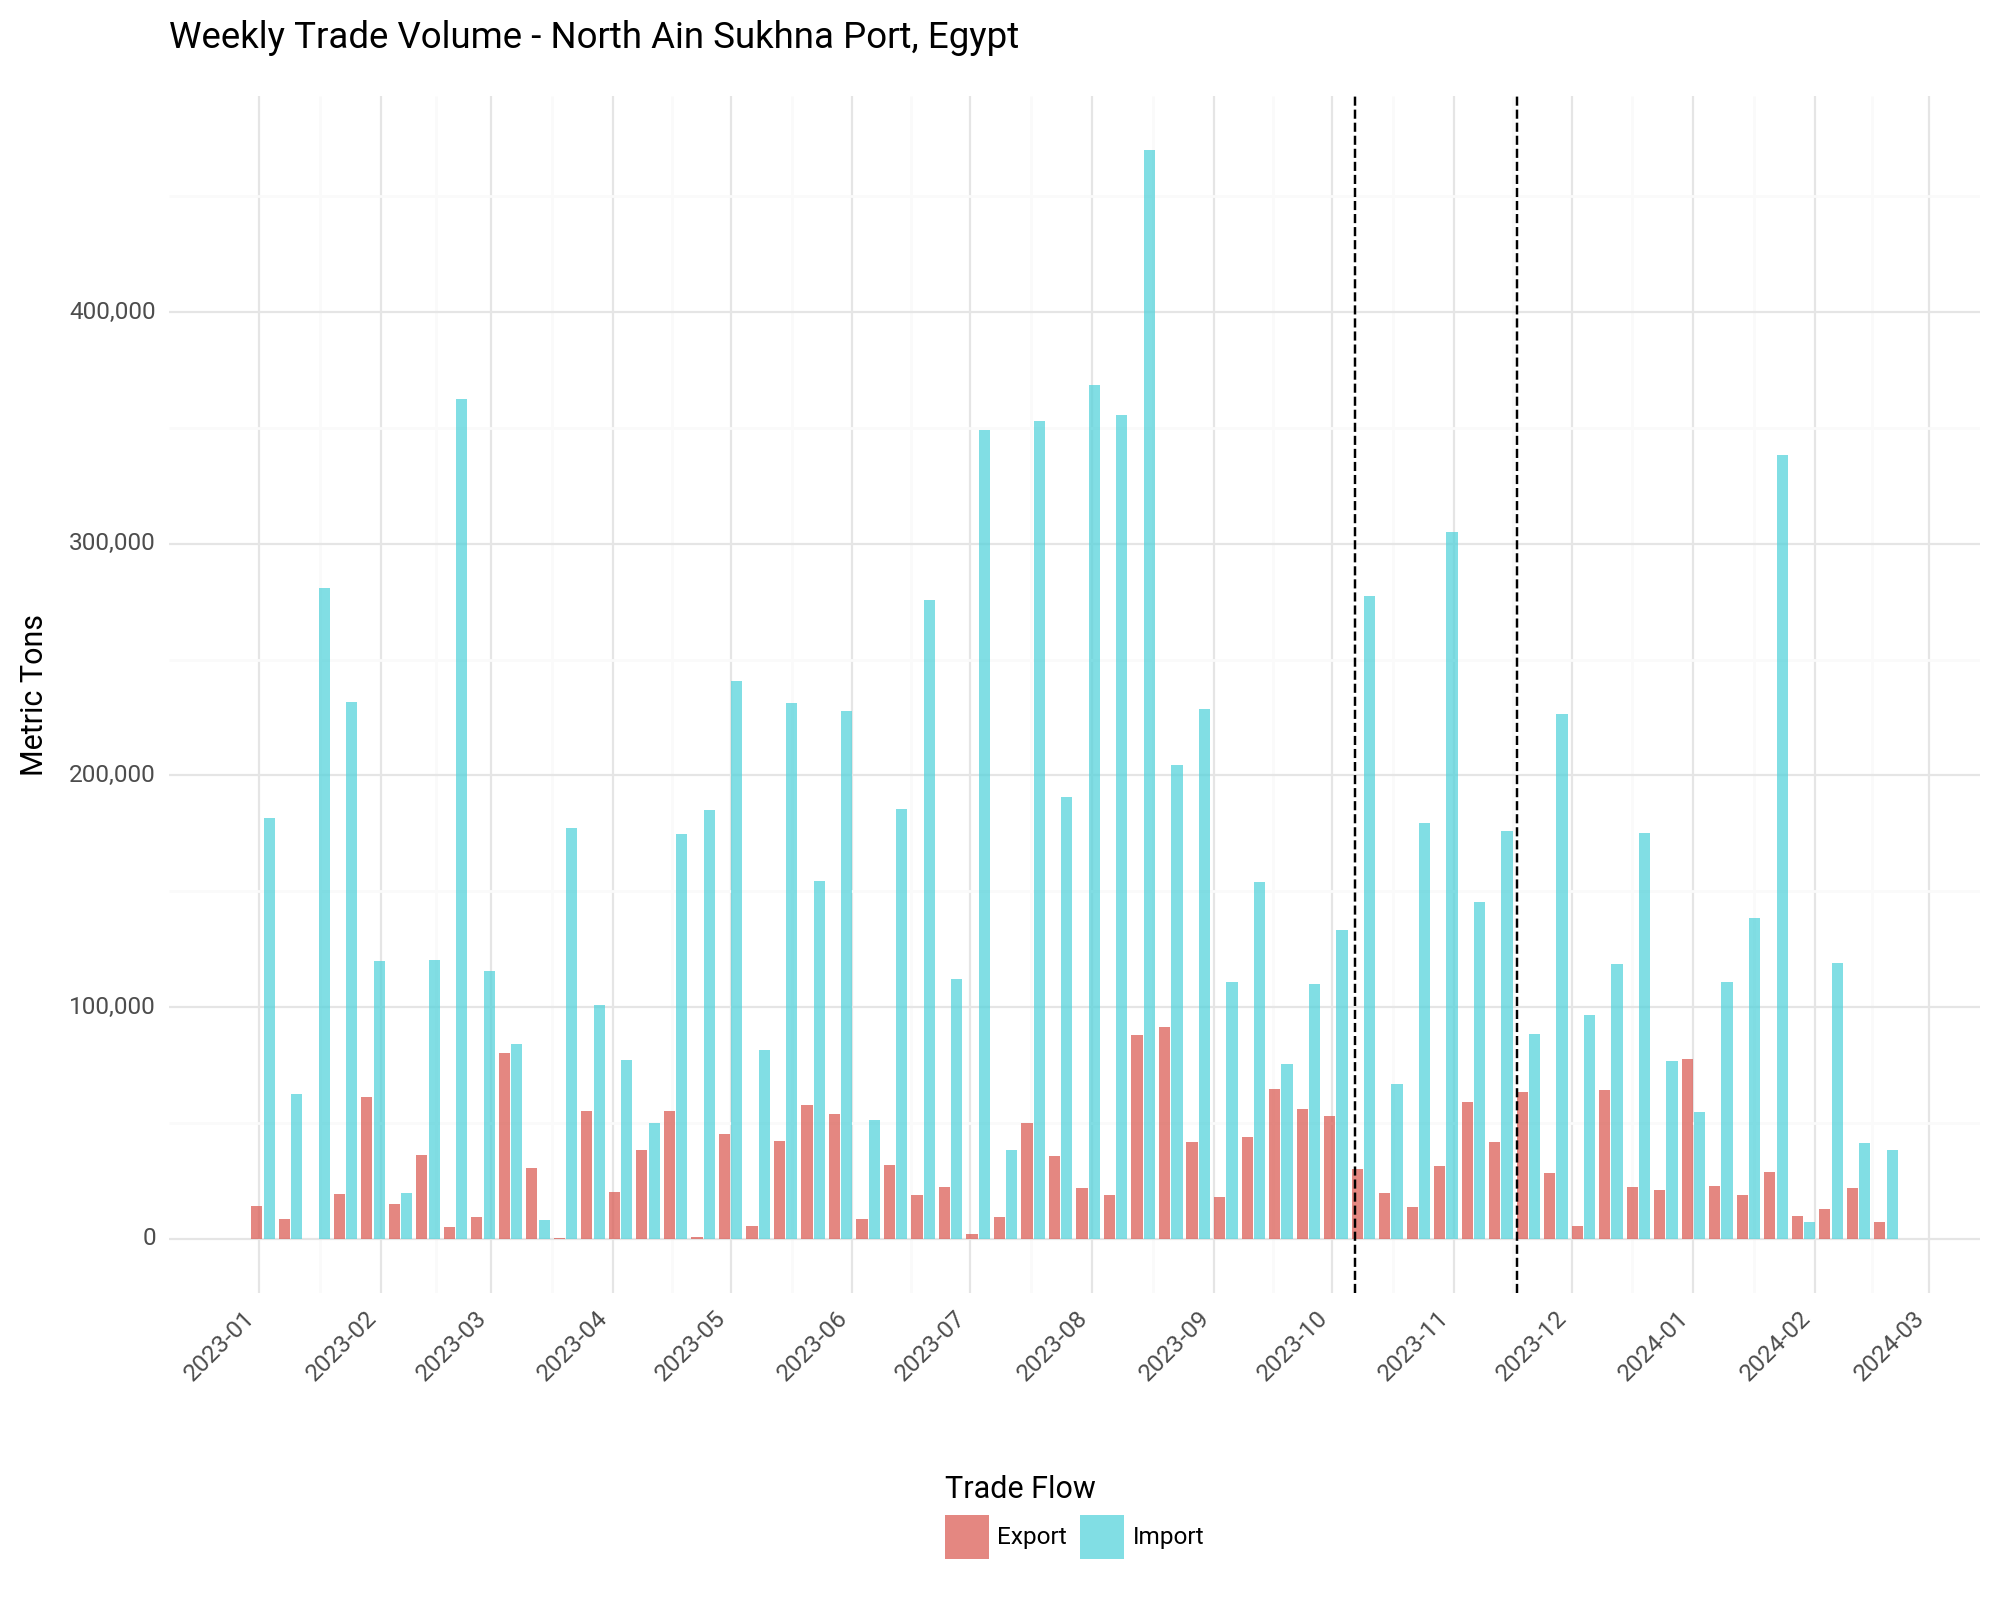

<Figure Size: (1000 x 800)>

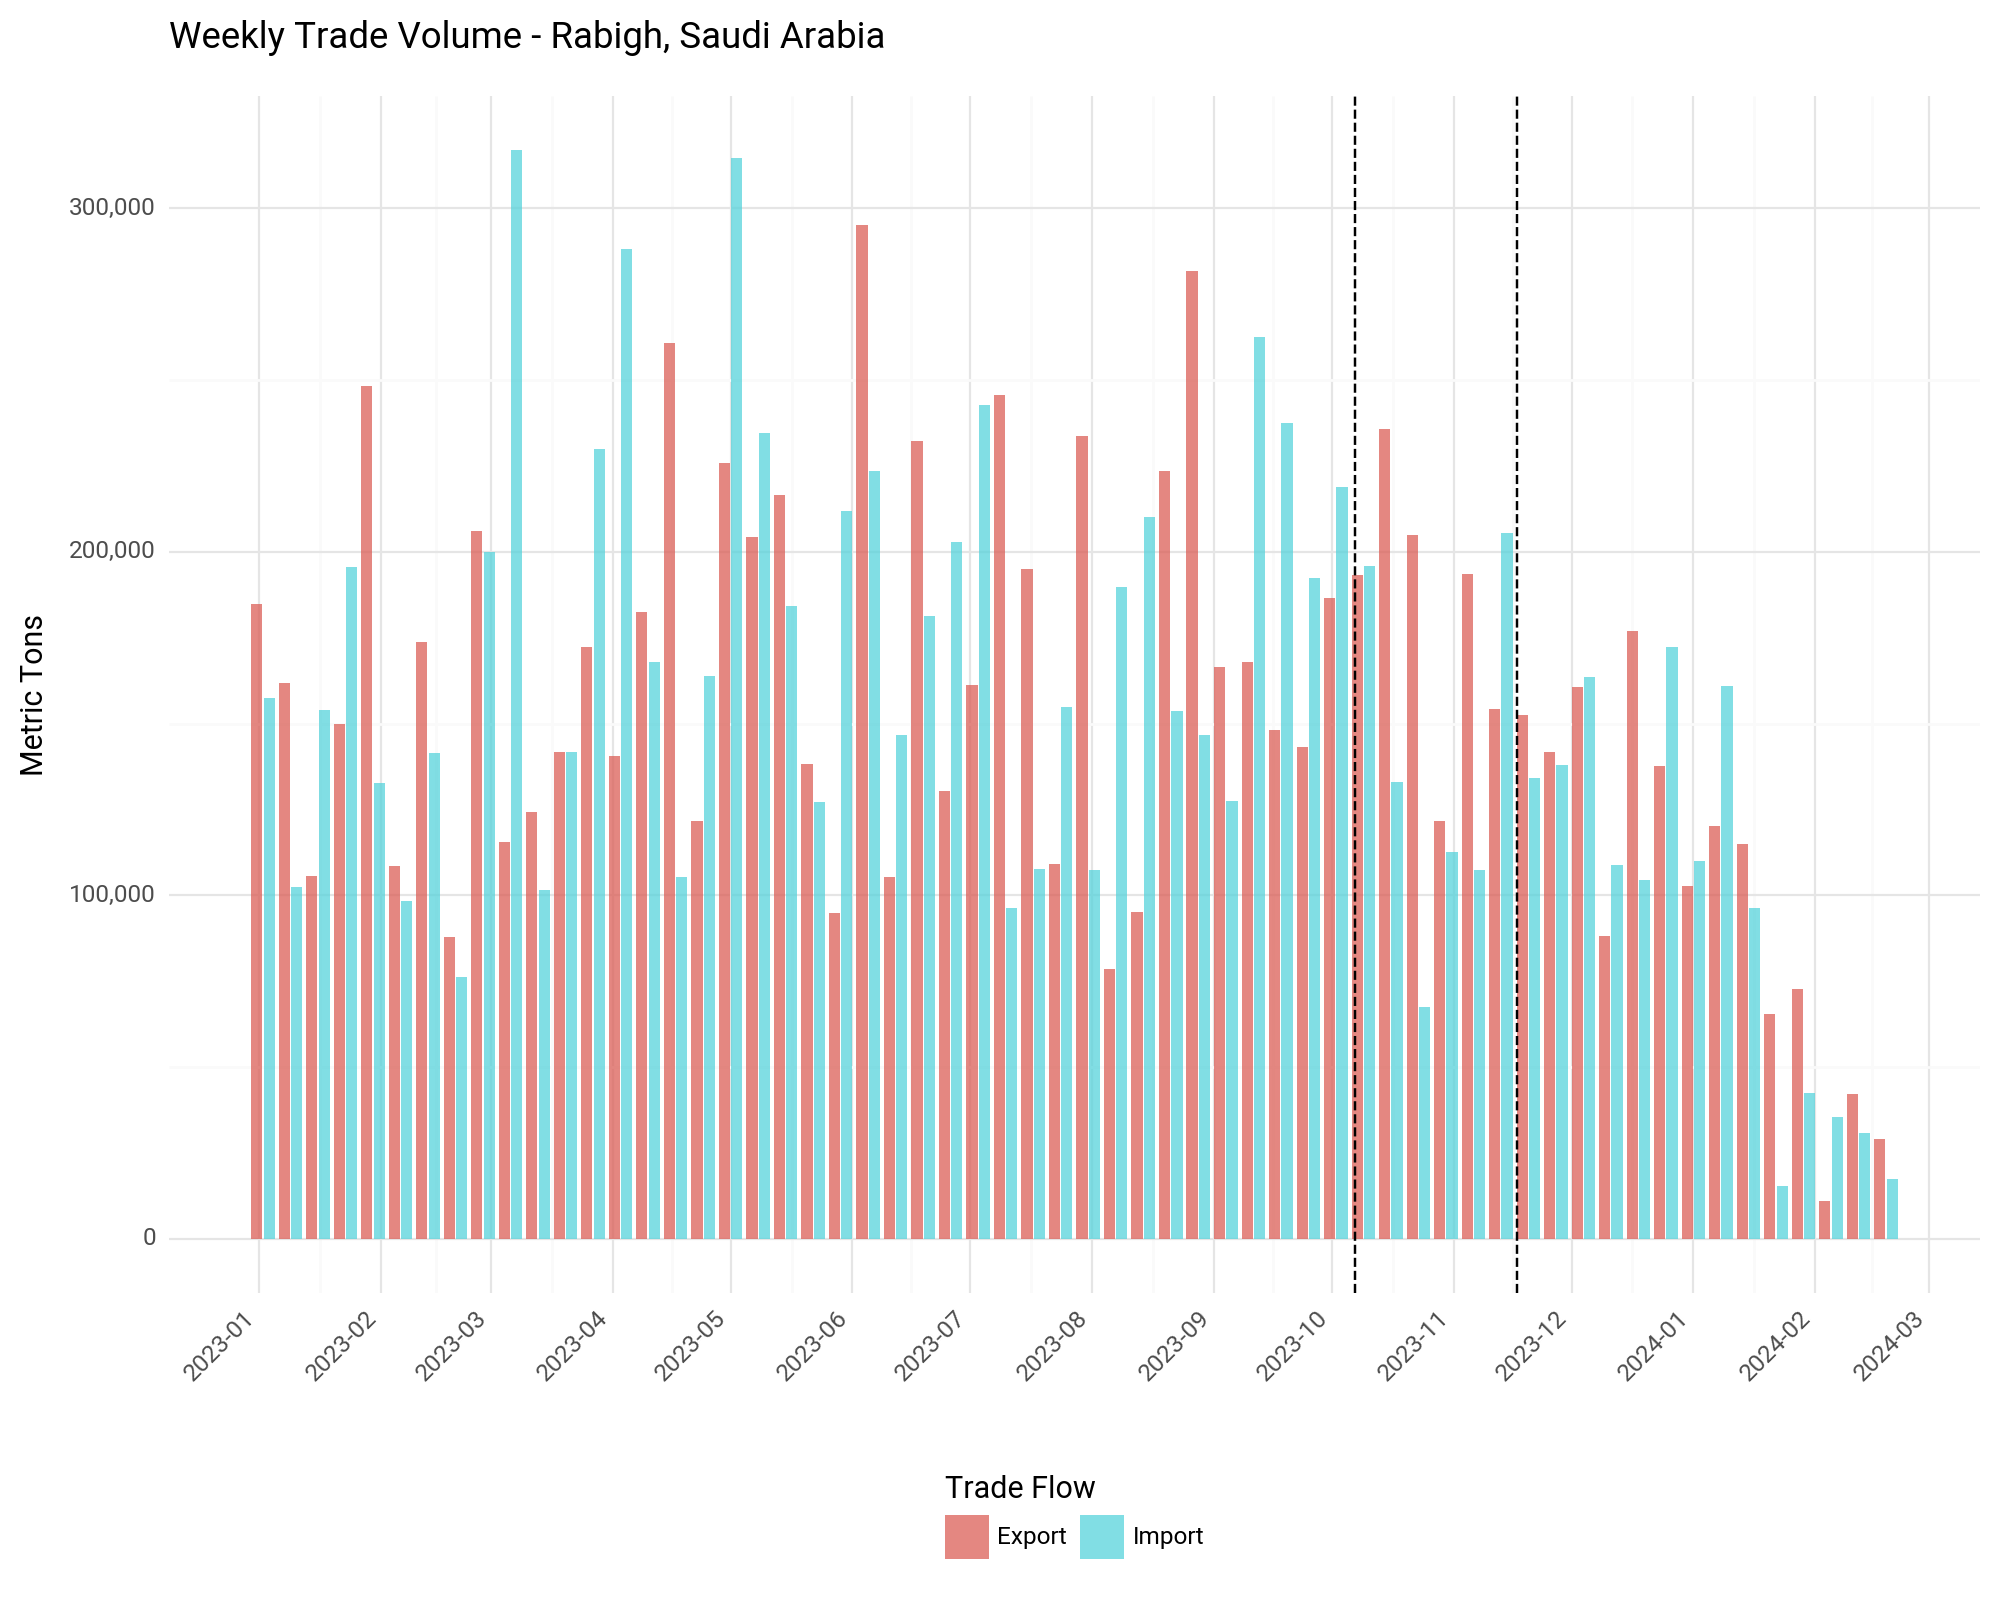

<Figure Size: (1000 x 800)>

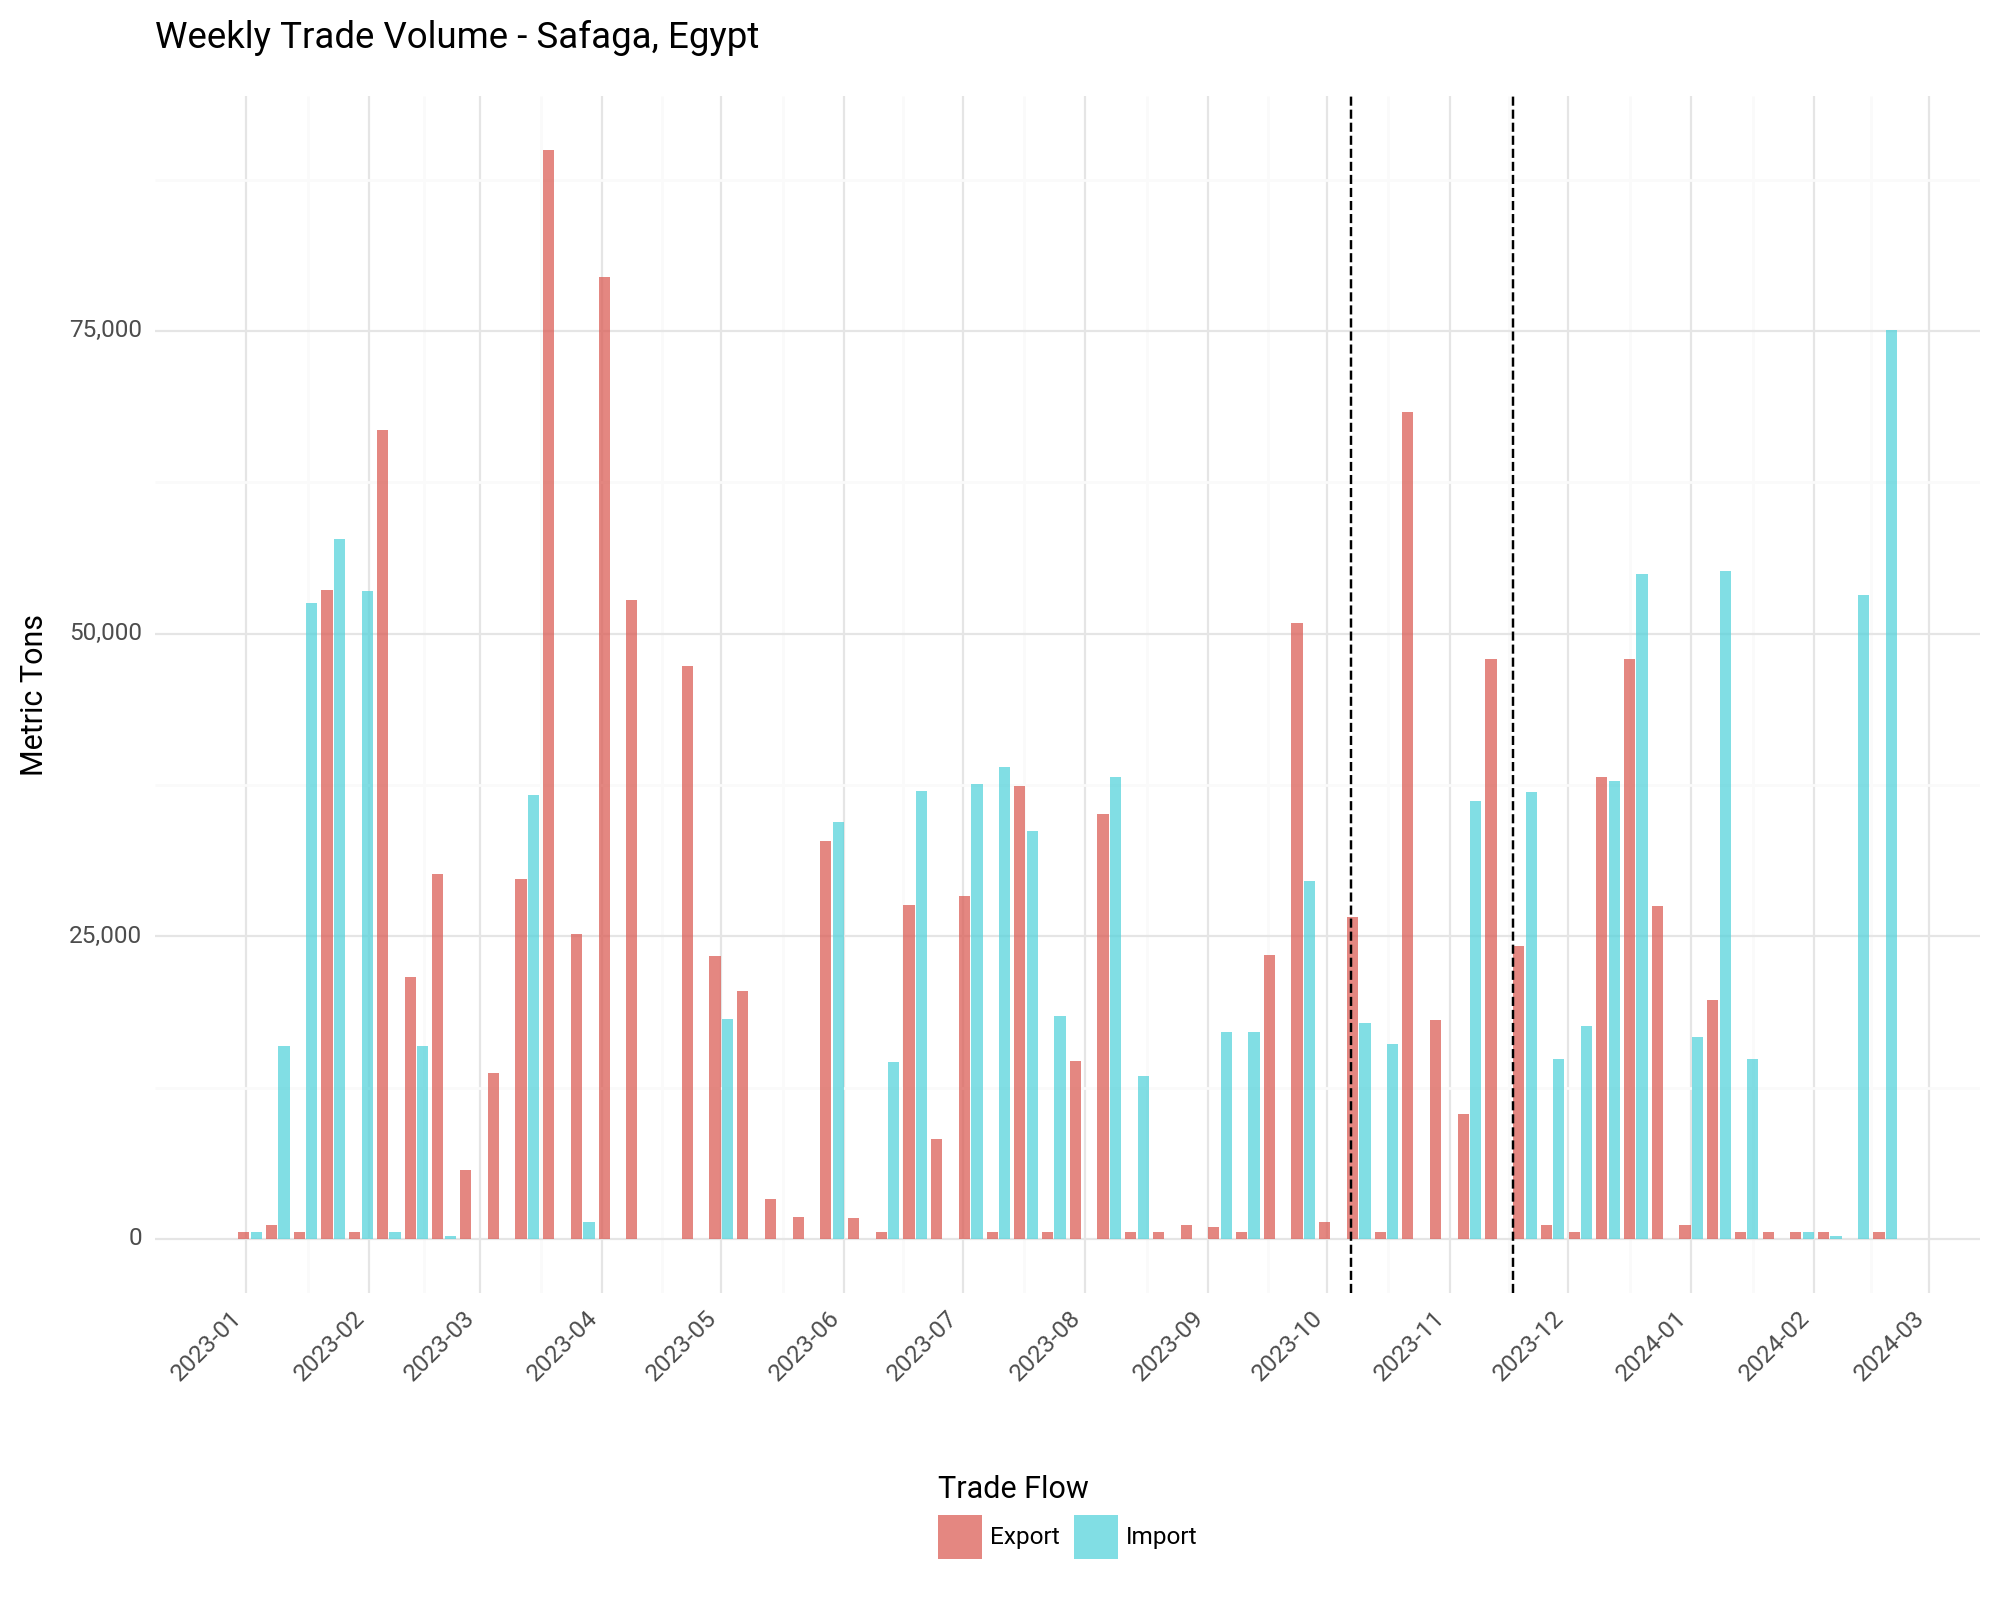

<Figure Size: (1000 x 800)>

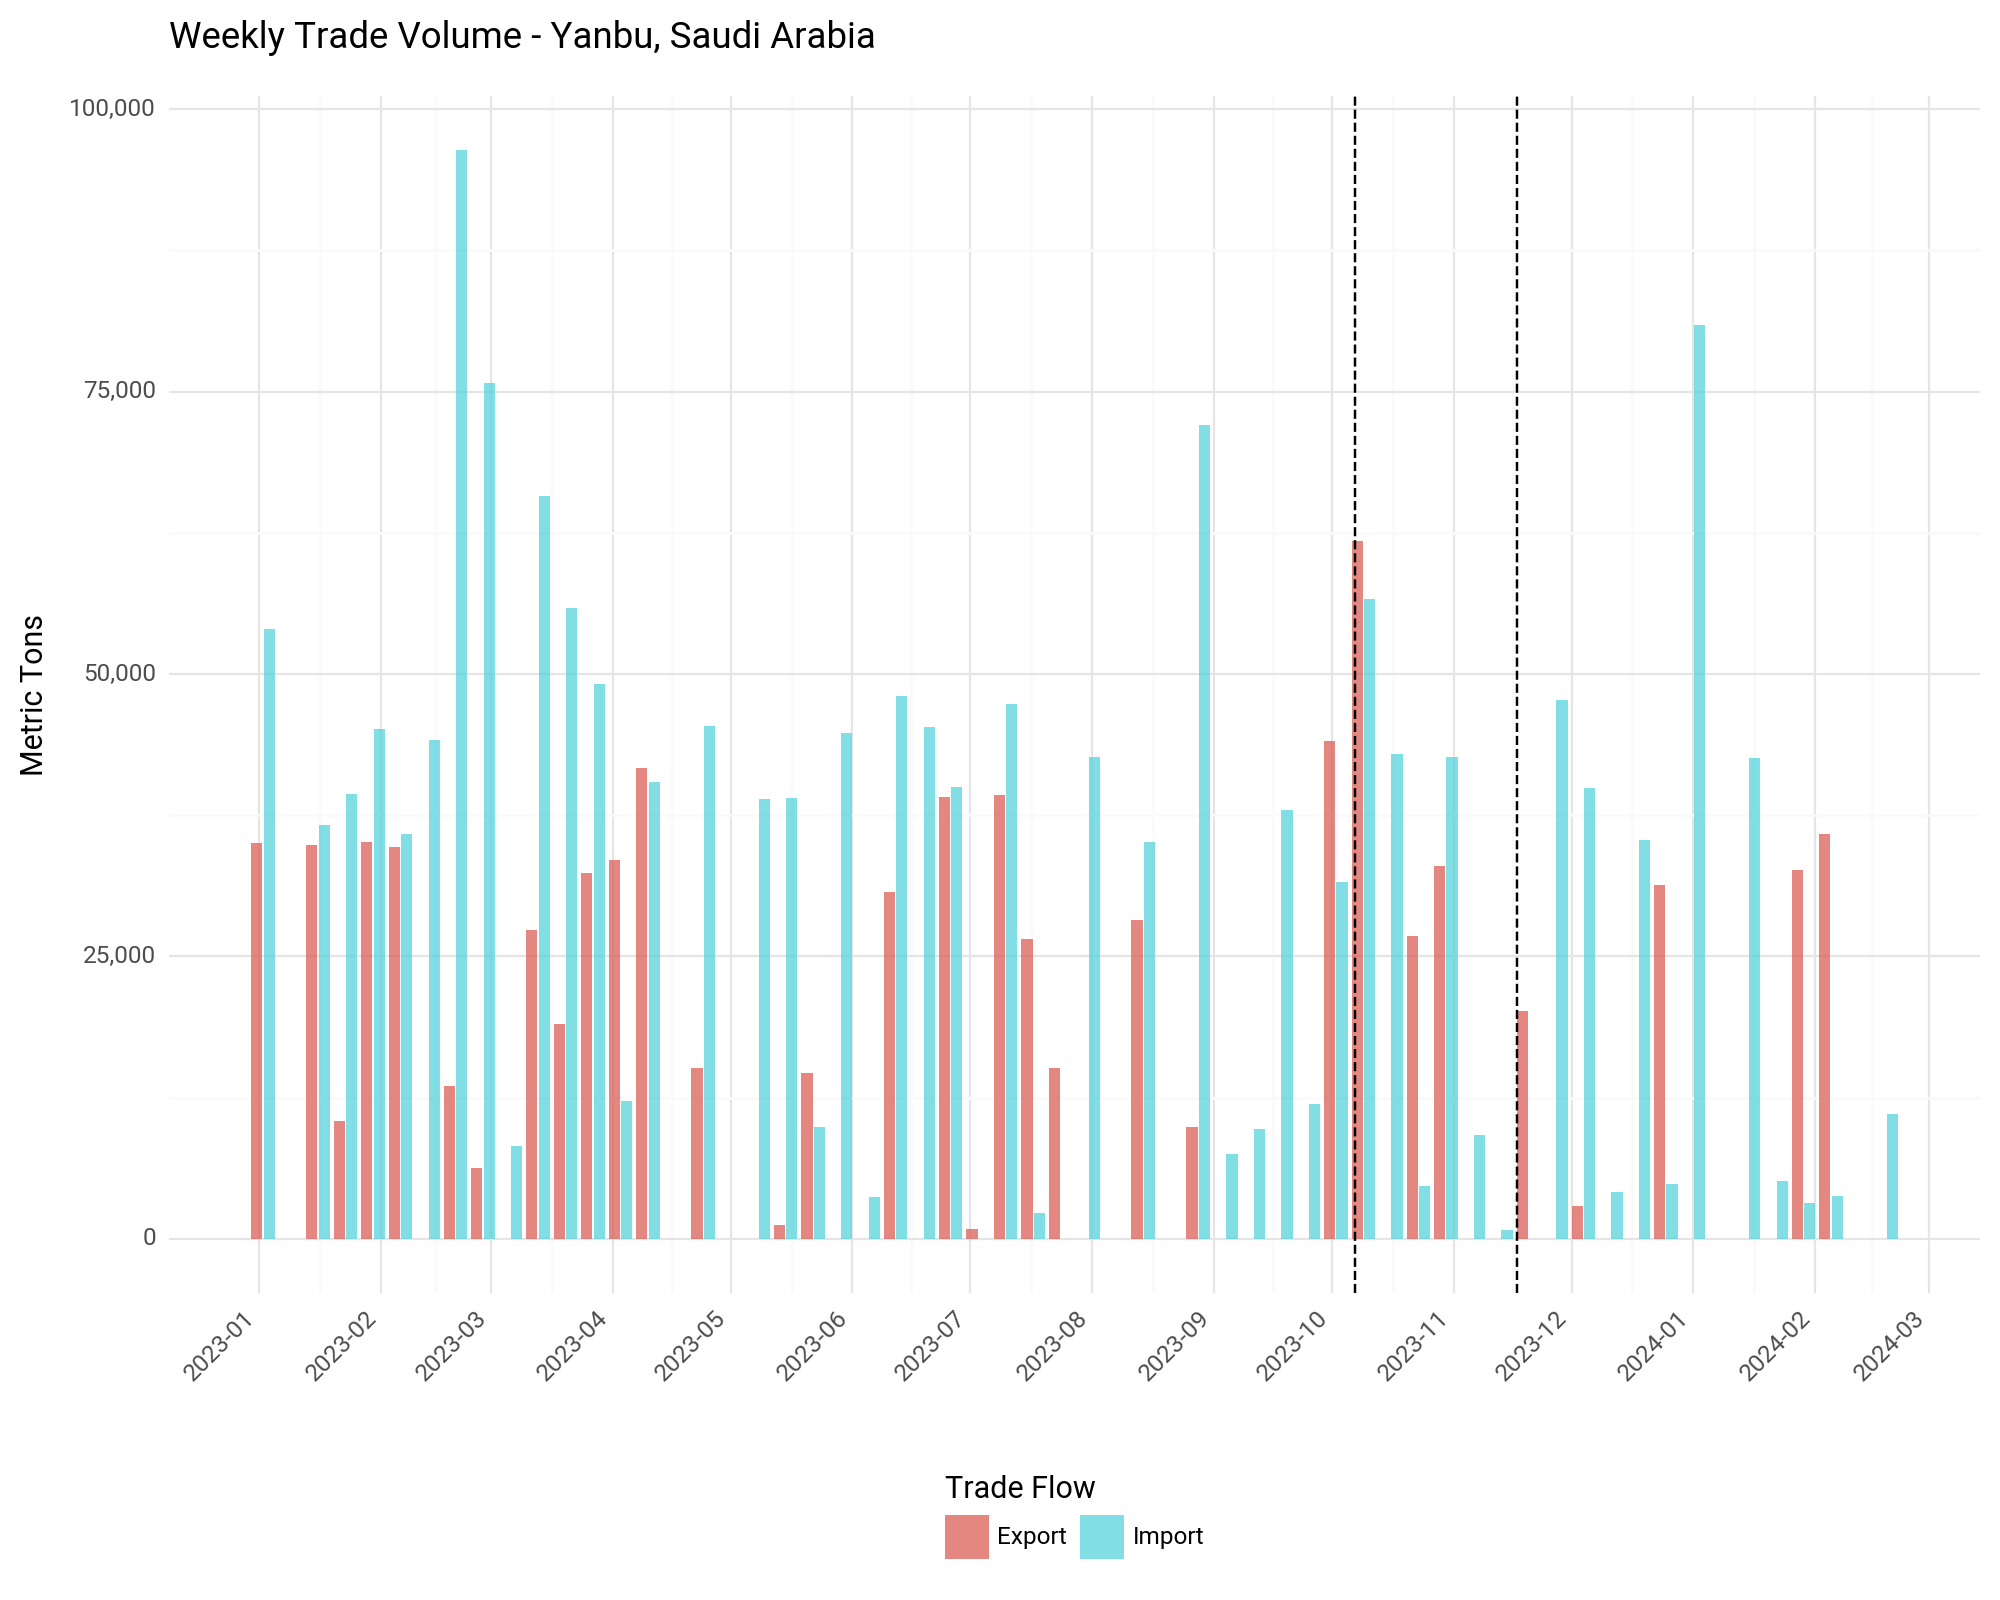

<Figure Size: (1000 x 800)>

In [14]:
for port in df_filt.portname.unique():
    port_info = ports_red_sea.loc[ports_red_sea.portname == port].iloc[0]
    country = port_info.country
    port_id = port_info.portid
    country = ports_red_sea.loc[ports_red_sea.portname == port, "country"].values[0]
    df_port = df_filt.loc[df_filt.portname == port].copy()
    df_port = df_port.melt(
        id_vars="date",
        value_vars=["import", "export"],
        var_name="direction",
        value_name="trade",
    )
    df_port.loc[:, "direction"] = df_port.direction.str.capitalize()
    p0 = (
        ggplot(df_port, aes(x="date", y="trade", fill="direction"))  #
        + geom_bar(alpha=3 / 4, stat="identity", position="dodge2")  #  fill="lightblue"
        # + geom_line(aes(x="date", y="export"), alpha=1, color="darkred")
        + geom_vline(xintercept=conflict_date, linetype="dashed", color="black")
        + geom_vline(xintercept=crisis_date, linetype="dashed", color="black")
        + labs(
            x="",
            y="Metric Tons",
            title=f"Weekly Trade Volume - {port}, {country}",
            fill="Trade Flow",
        )
        + theme_minimal()
        + theme(text=element_text(family="Roboto"))
        + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
        + scale_y_continuous(labels=comma_format())
        # + scale_fill_brewer(type='qual', palette=1)
        + theme(axis_text_x=element_text(rotation=45, hjust=1))
        + theme(legend_position="bottom")
    )
    display(p0)
    # p0.save(filename=join(charts_by_port_dir, f'estimated-trade-{port_id}.jpeg'), dpi=300)

### Resample to Monthly

In [15]:
df = (
    df_raw.groupby("portname")[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
            "date",
        ]
    ]
    .resample("MS", on="date")
    .sum()
    .reset_index()
)
df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "m"] = df.date.dt.strftime("%m")

In [16]:
df.head(2)

portname       date  portcalls_cargo  portcalls_tanker  portcalls  \
0     Aden 2019-01-01               35                 7         42   
1     Aden 2019-02-01               43                 5         48   

    import_cargo  export_cargo  import_tanker  export_tanker         import  \
0  211348.052875   1848.225266   61496.118007    3160.095388  272844.170882   
1  306744.763449  10160.227084   42407.618684    6320.190776  349152.382132   

         export         ymd   m  
0   5008.320654  2019-01-01  01  
1  16480.417860  2019-02-01  02

### Calculate Reference Values

Periods
- **Baseline**: 2021, 2022, 2023 (January 1st – October 6th)
- **Middle East Conflict**: 2023 (October 7th - November 16th)
- **Red Sea Crisis**: November 17th - January 31st, 2024

In [17]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [18]:
df_ref = df.loc[(df.date >= start_reference_date) & (df.date < conflict_date)].copy()
df_ref = df_ref.groupby(["portname", "m"])[
    [
        "portcalls_cargo",
        "portcalls_tanker",
        "portcalls",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
    ]
].mean().reset_index()
df_ref.rename(
    columns={
        "portcalls_cargo": "portcalls_cargo_ref",
        "portcalls_tanker": "portcalls_tanker_ref",
        "portcalls": "portcalls_ref",
        "import_cargo": "import_cargo_ref",
        "export_cargo": "export_cargo_ref",
        "import_tanker": "import_tanker_ref",
        "export_tanker": "export_tanker_ref",
        "import": "import_ref",
        "export": "export_ref",
    },
    inplace=True,
)

Filter recent data (2023 onwards) and merge reference values.

In [19]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()
df_filt = df_filt.merge(df_ref, on=["portname", "m"], how="left", validate="m:1")

In [20]:
charts_by_port_dir = join(charts_dir, "ports-ref-monthly")
if not exists(charts_by_port_dir):
    os.makedirs(charts_by_port_dir, mode=0o777)

### Plot Monthly Trade Volume and Historical Average

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


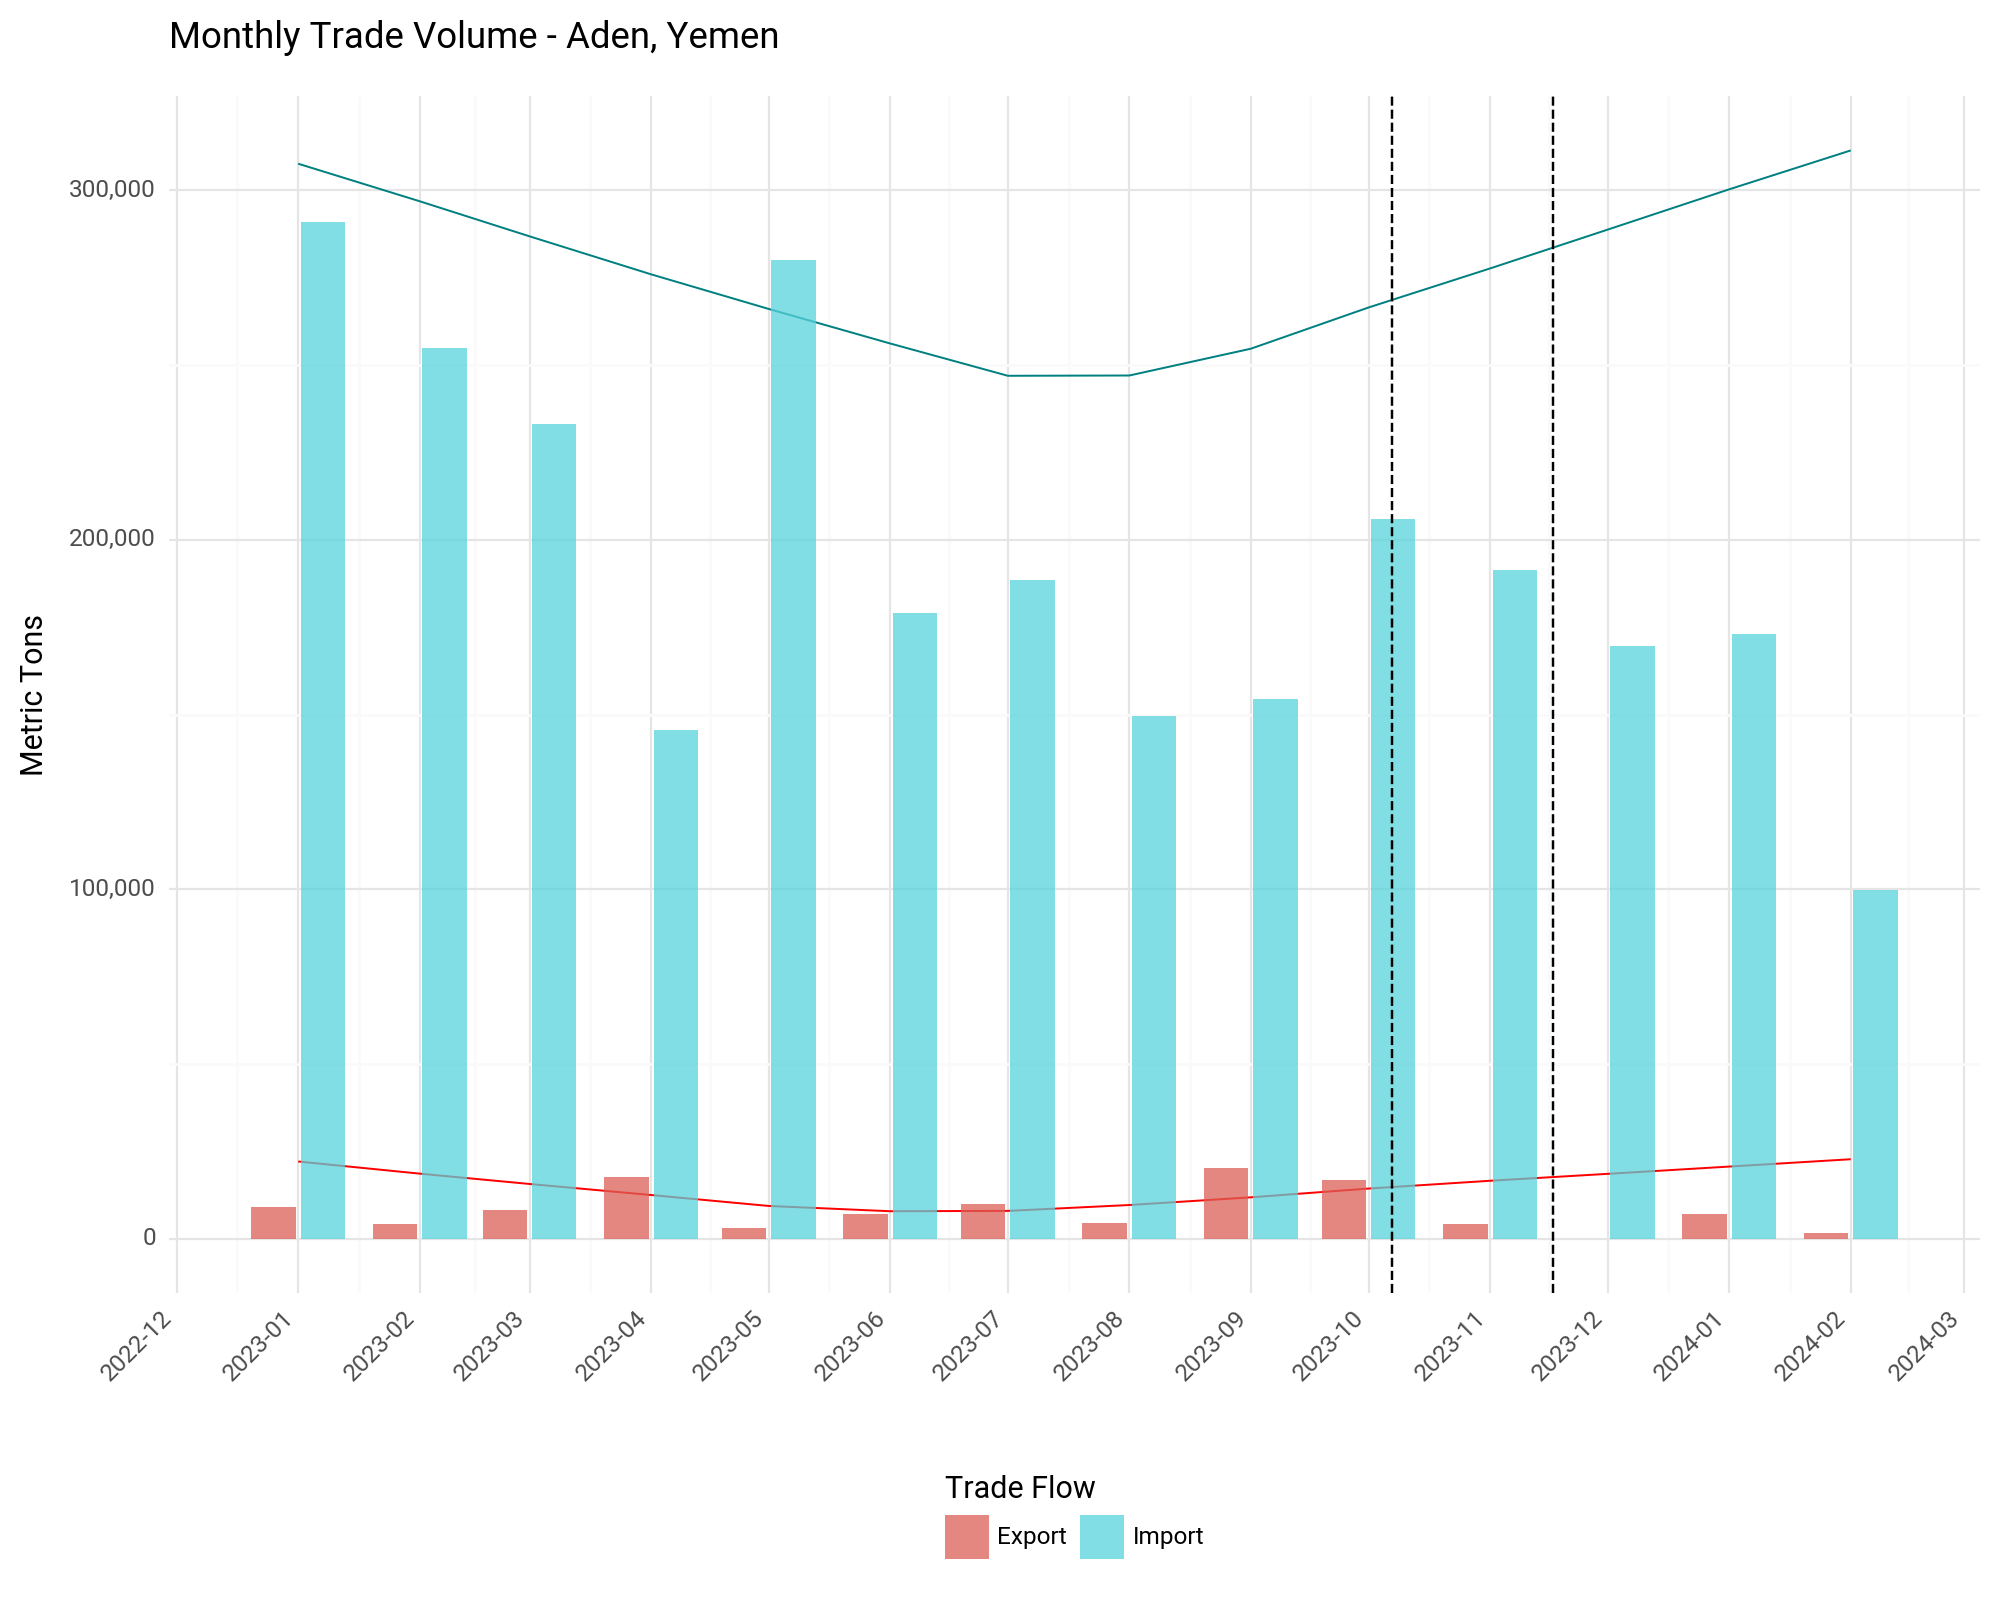

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


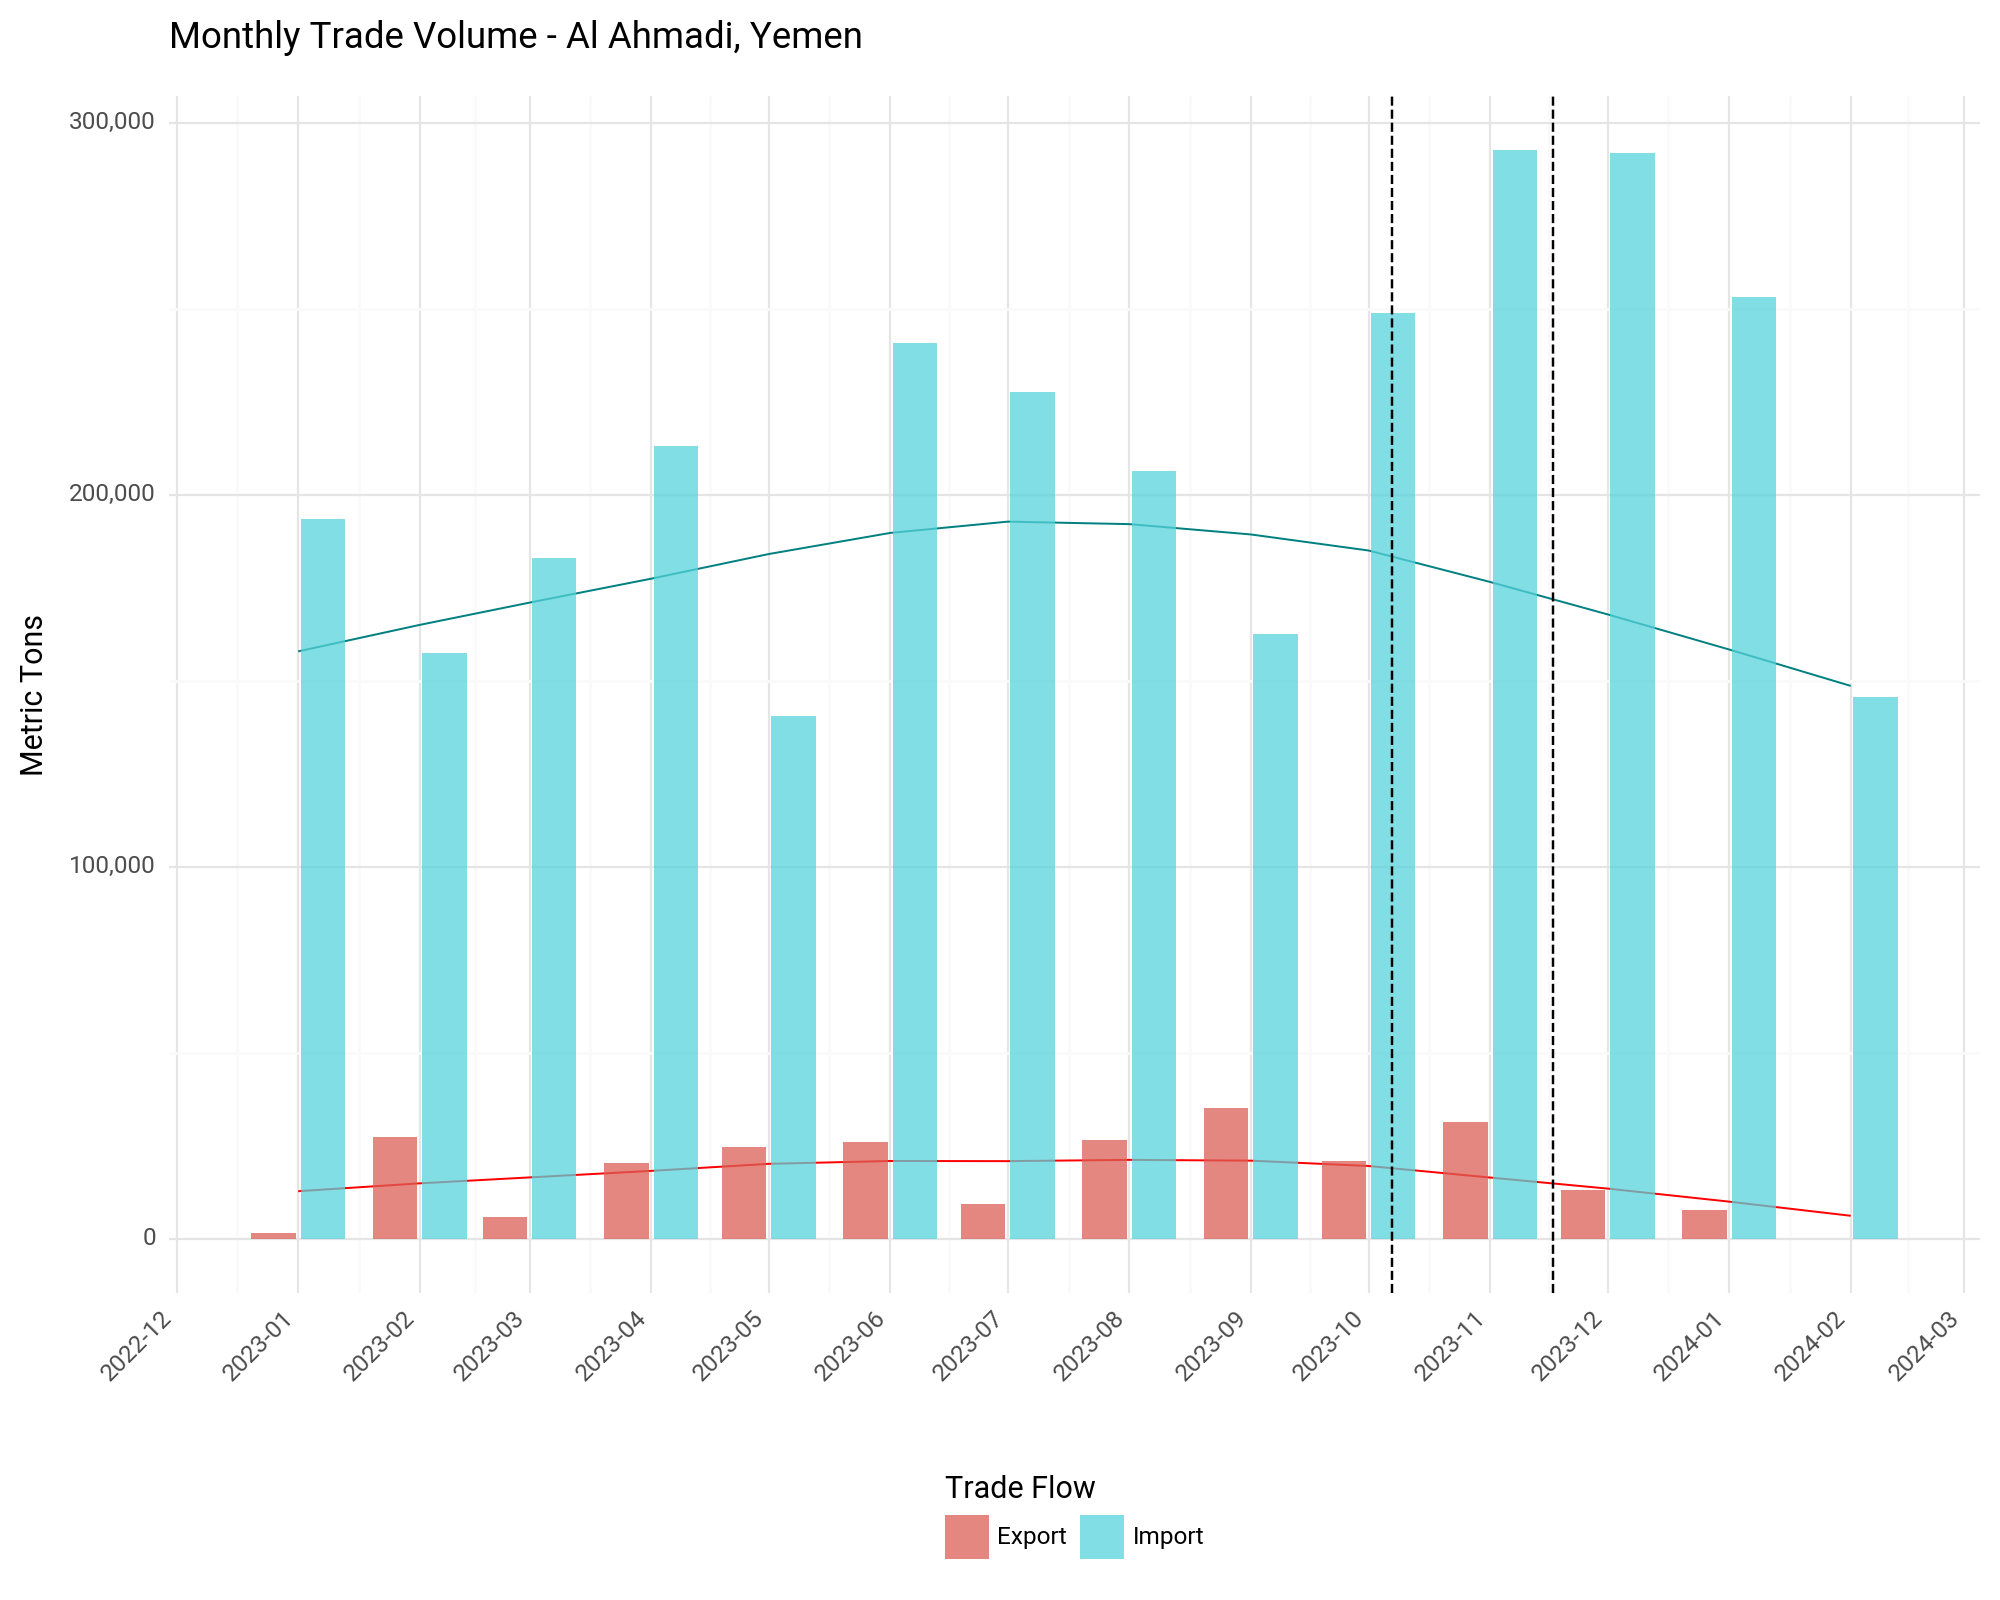

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


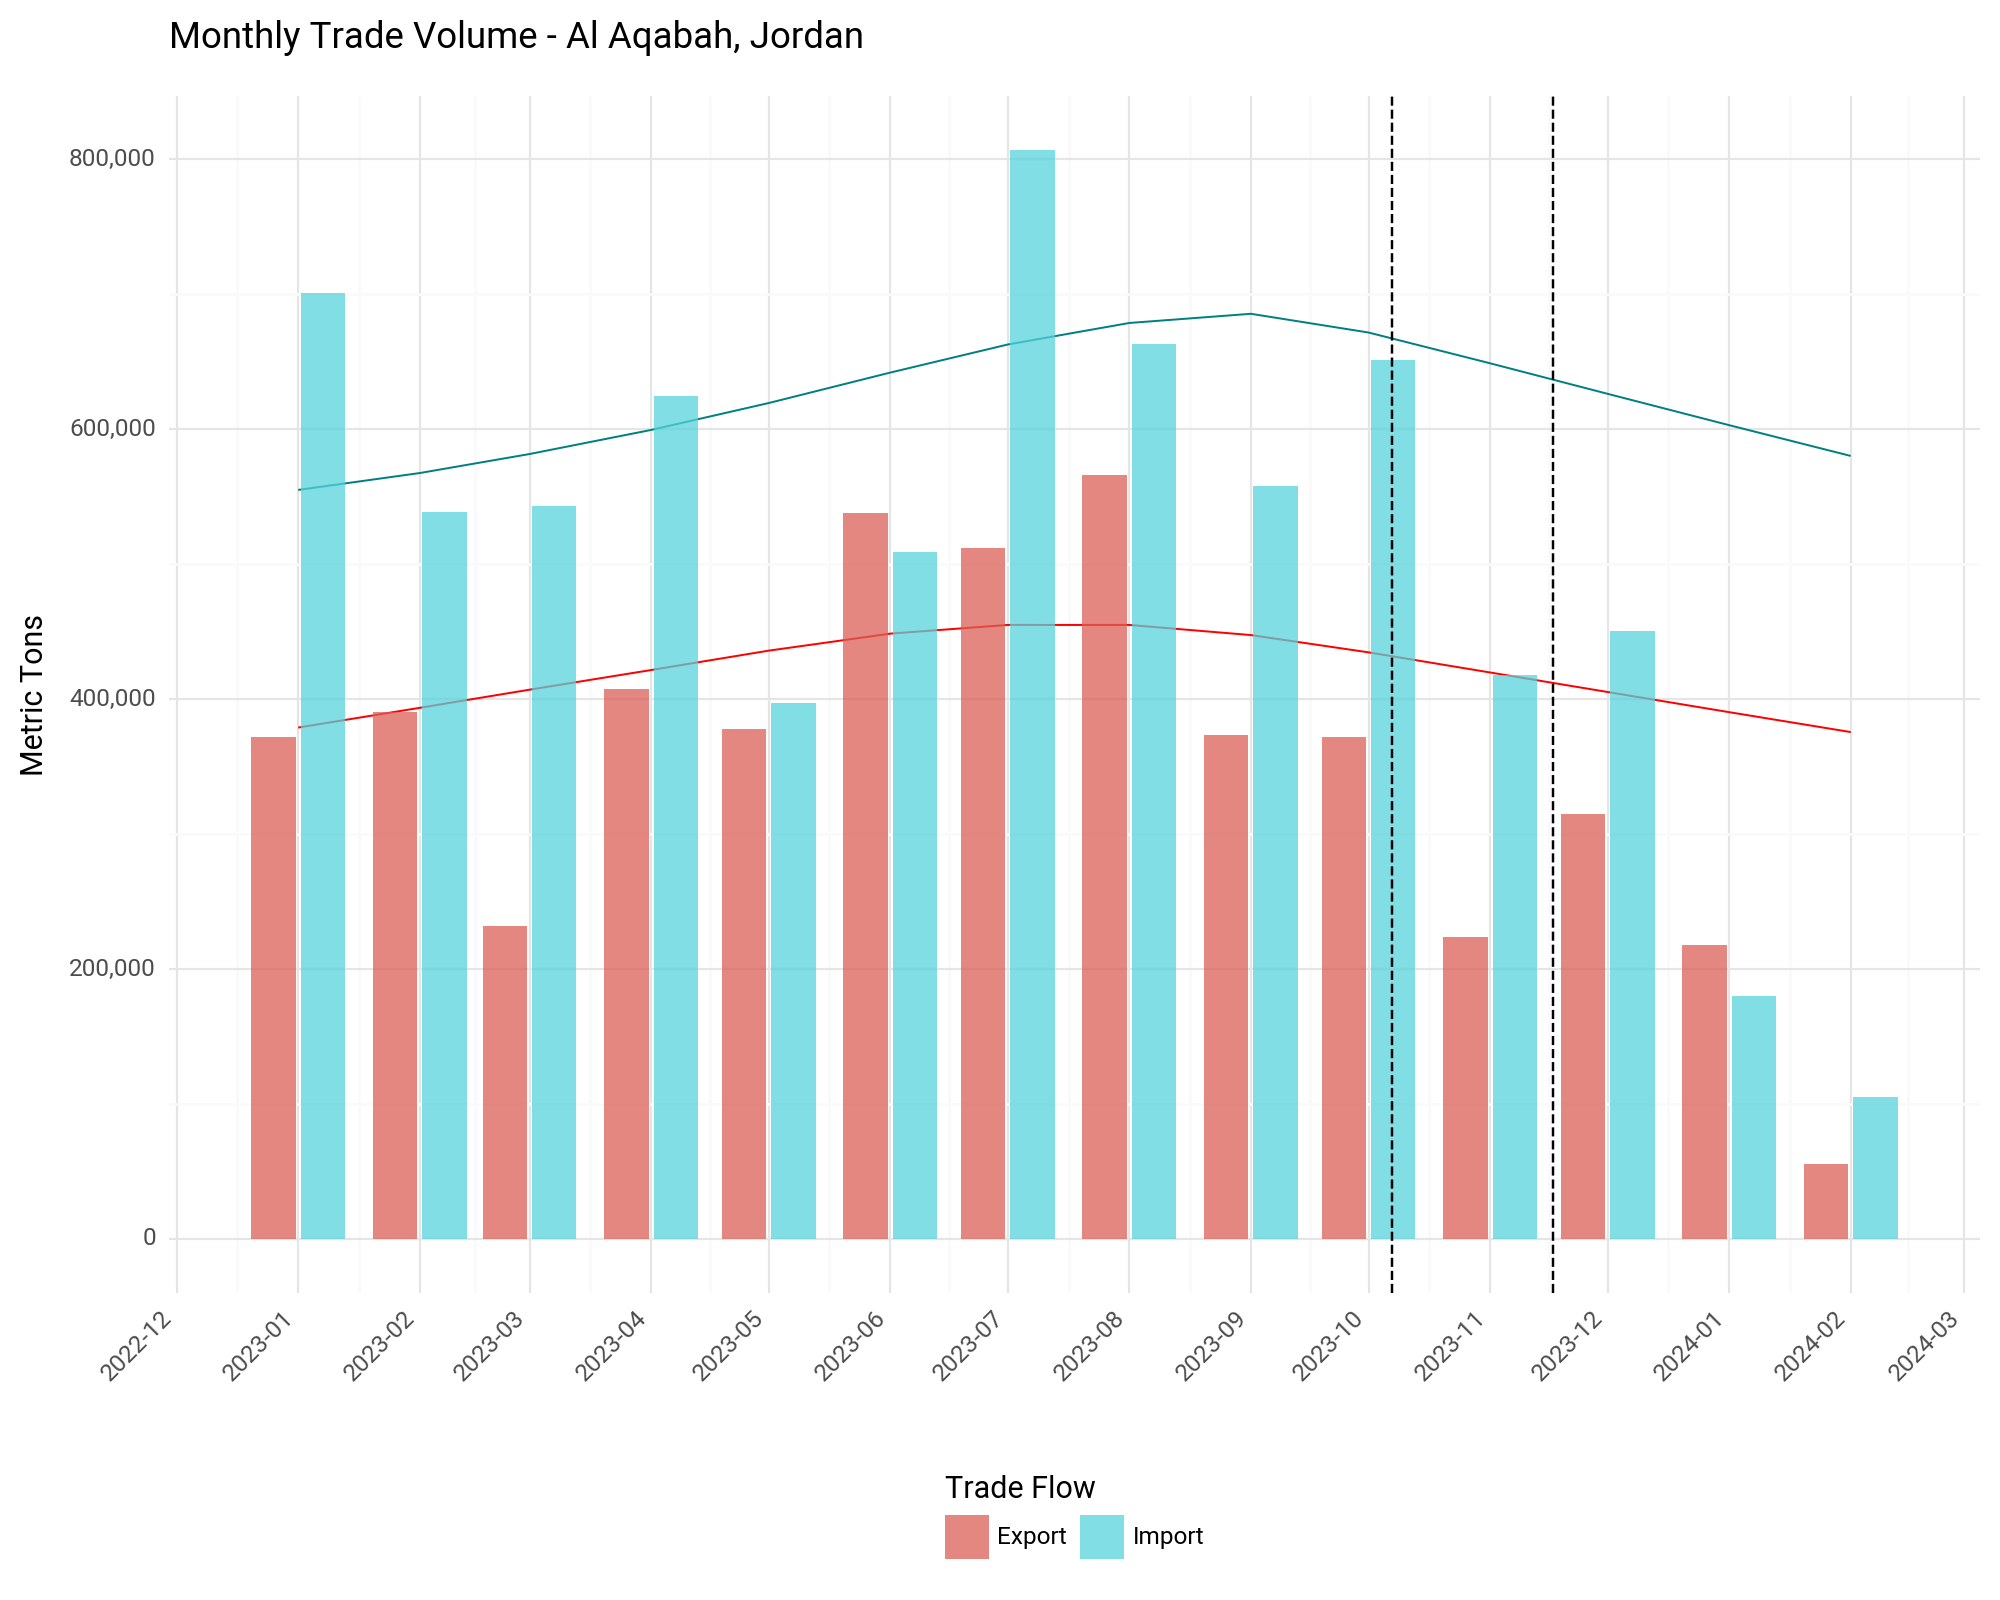

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


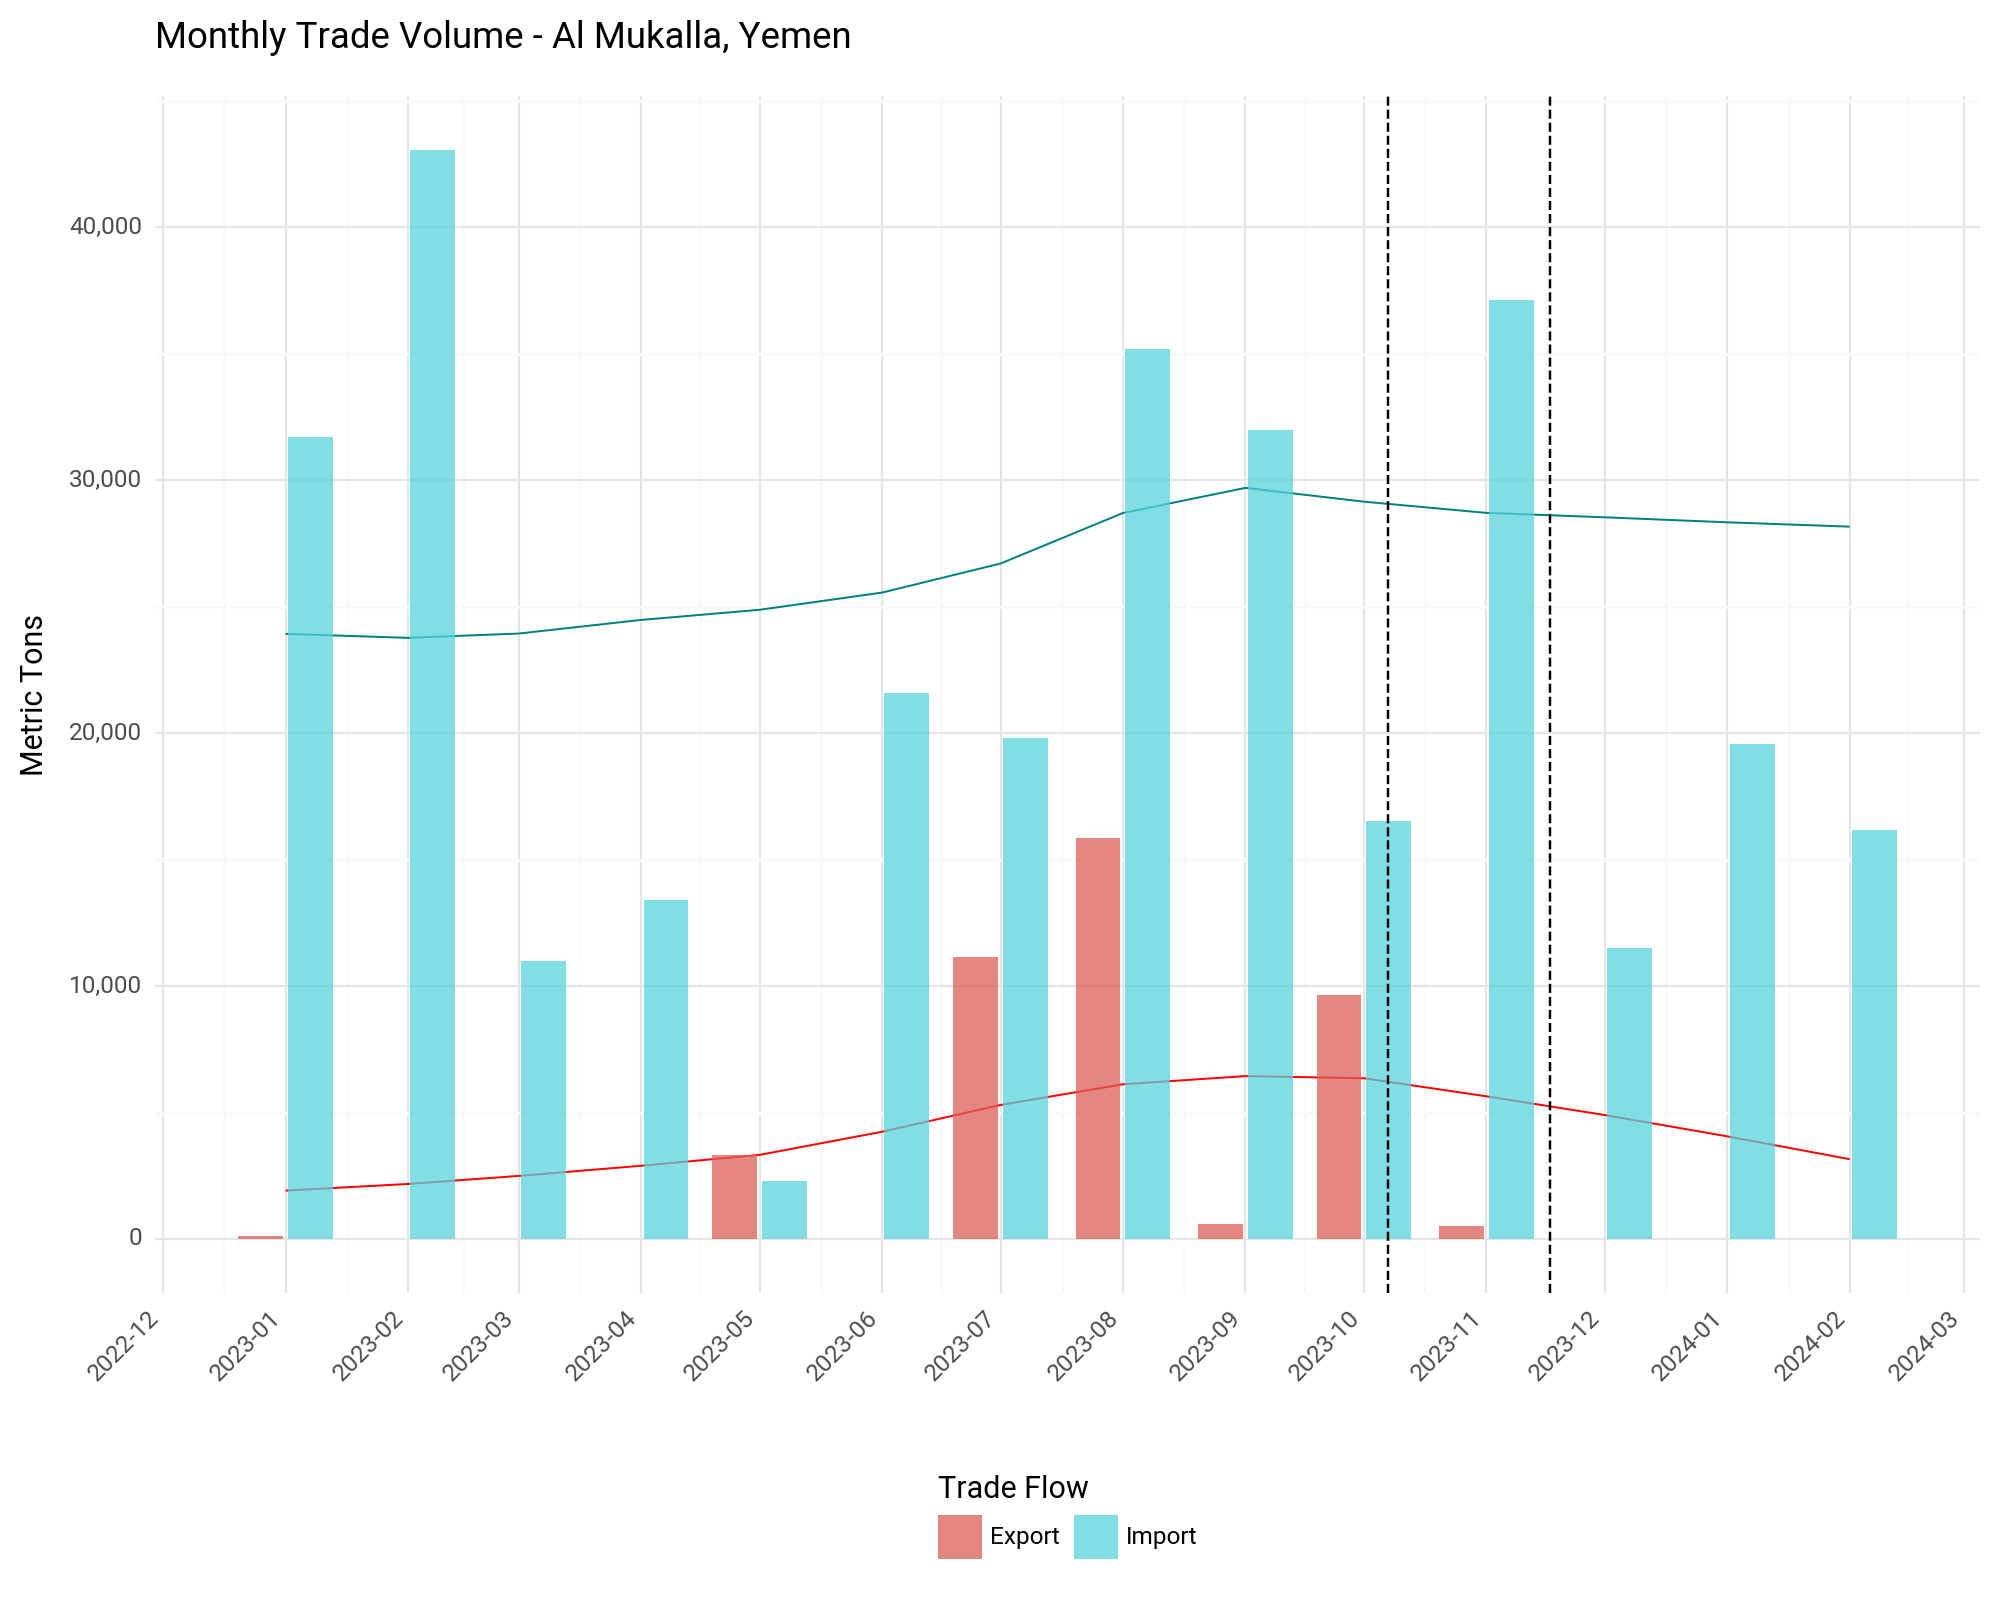

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


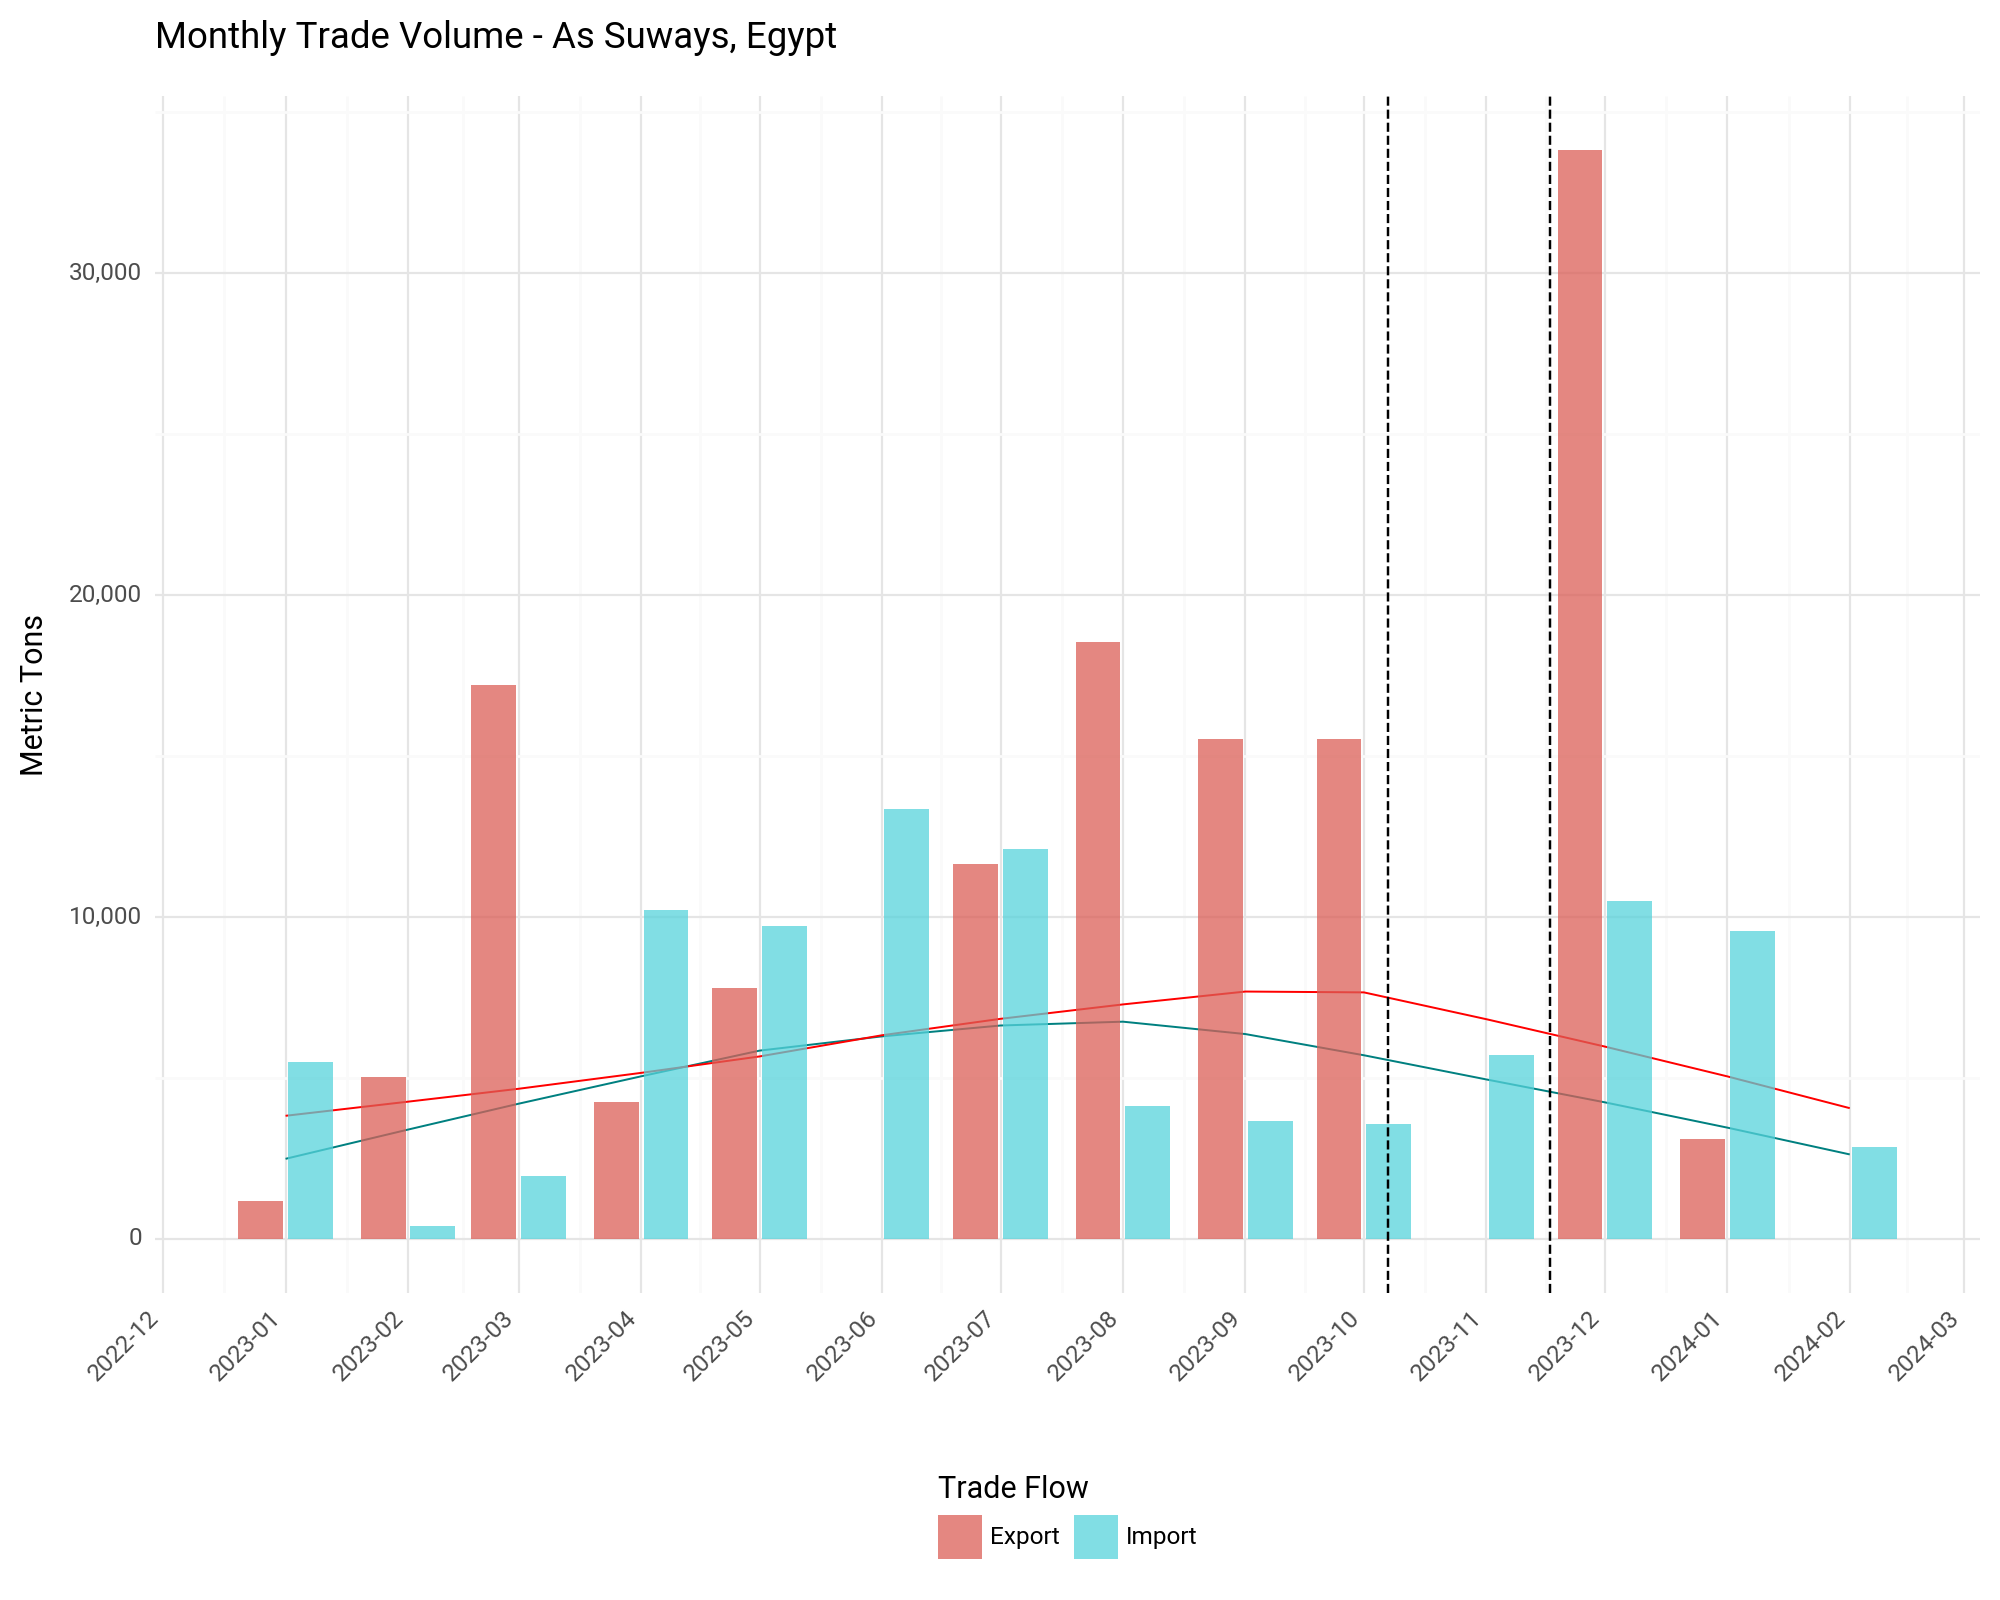

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


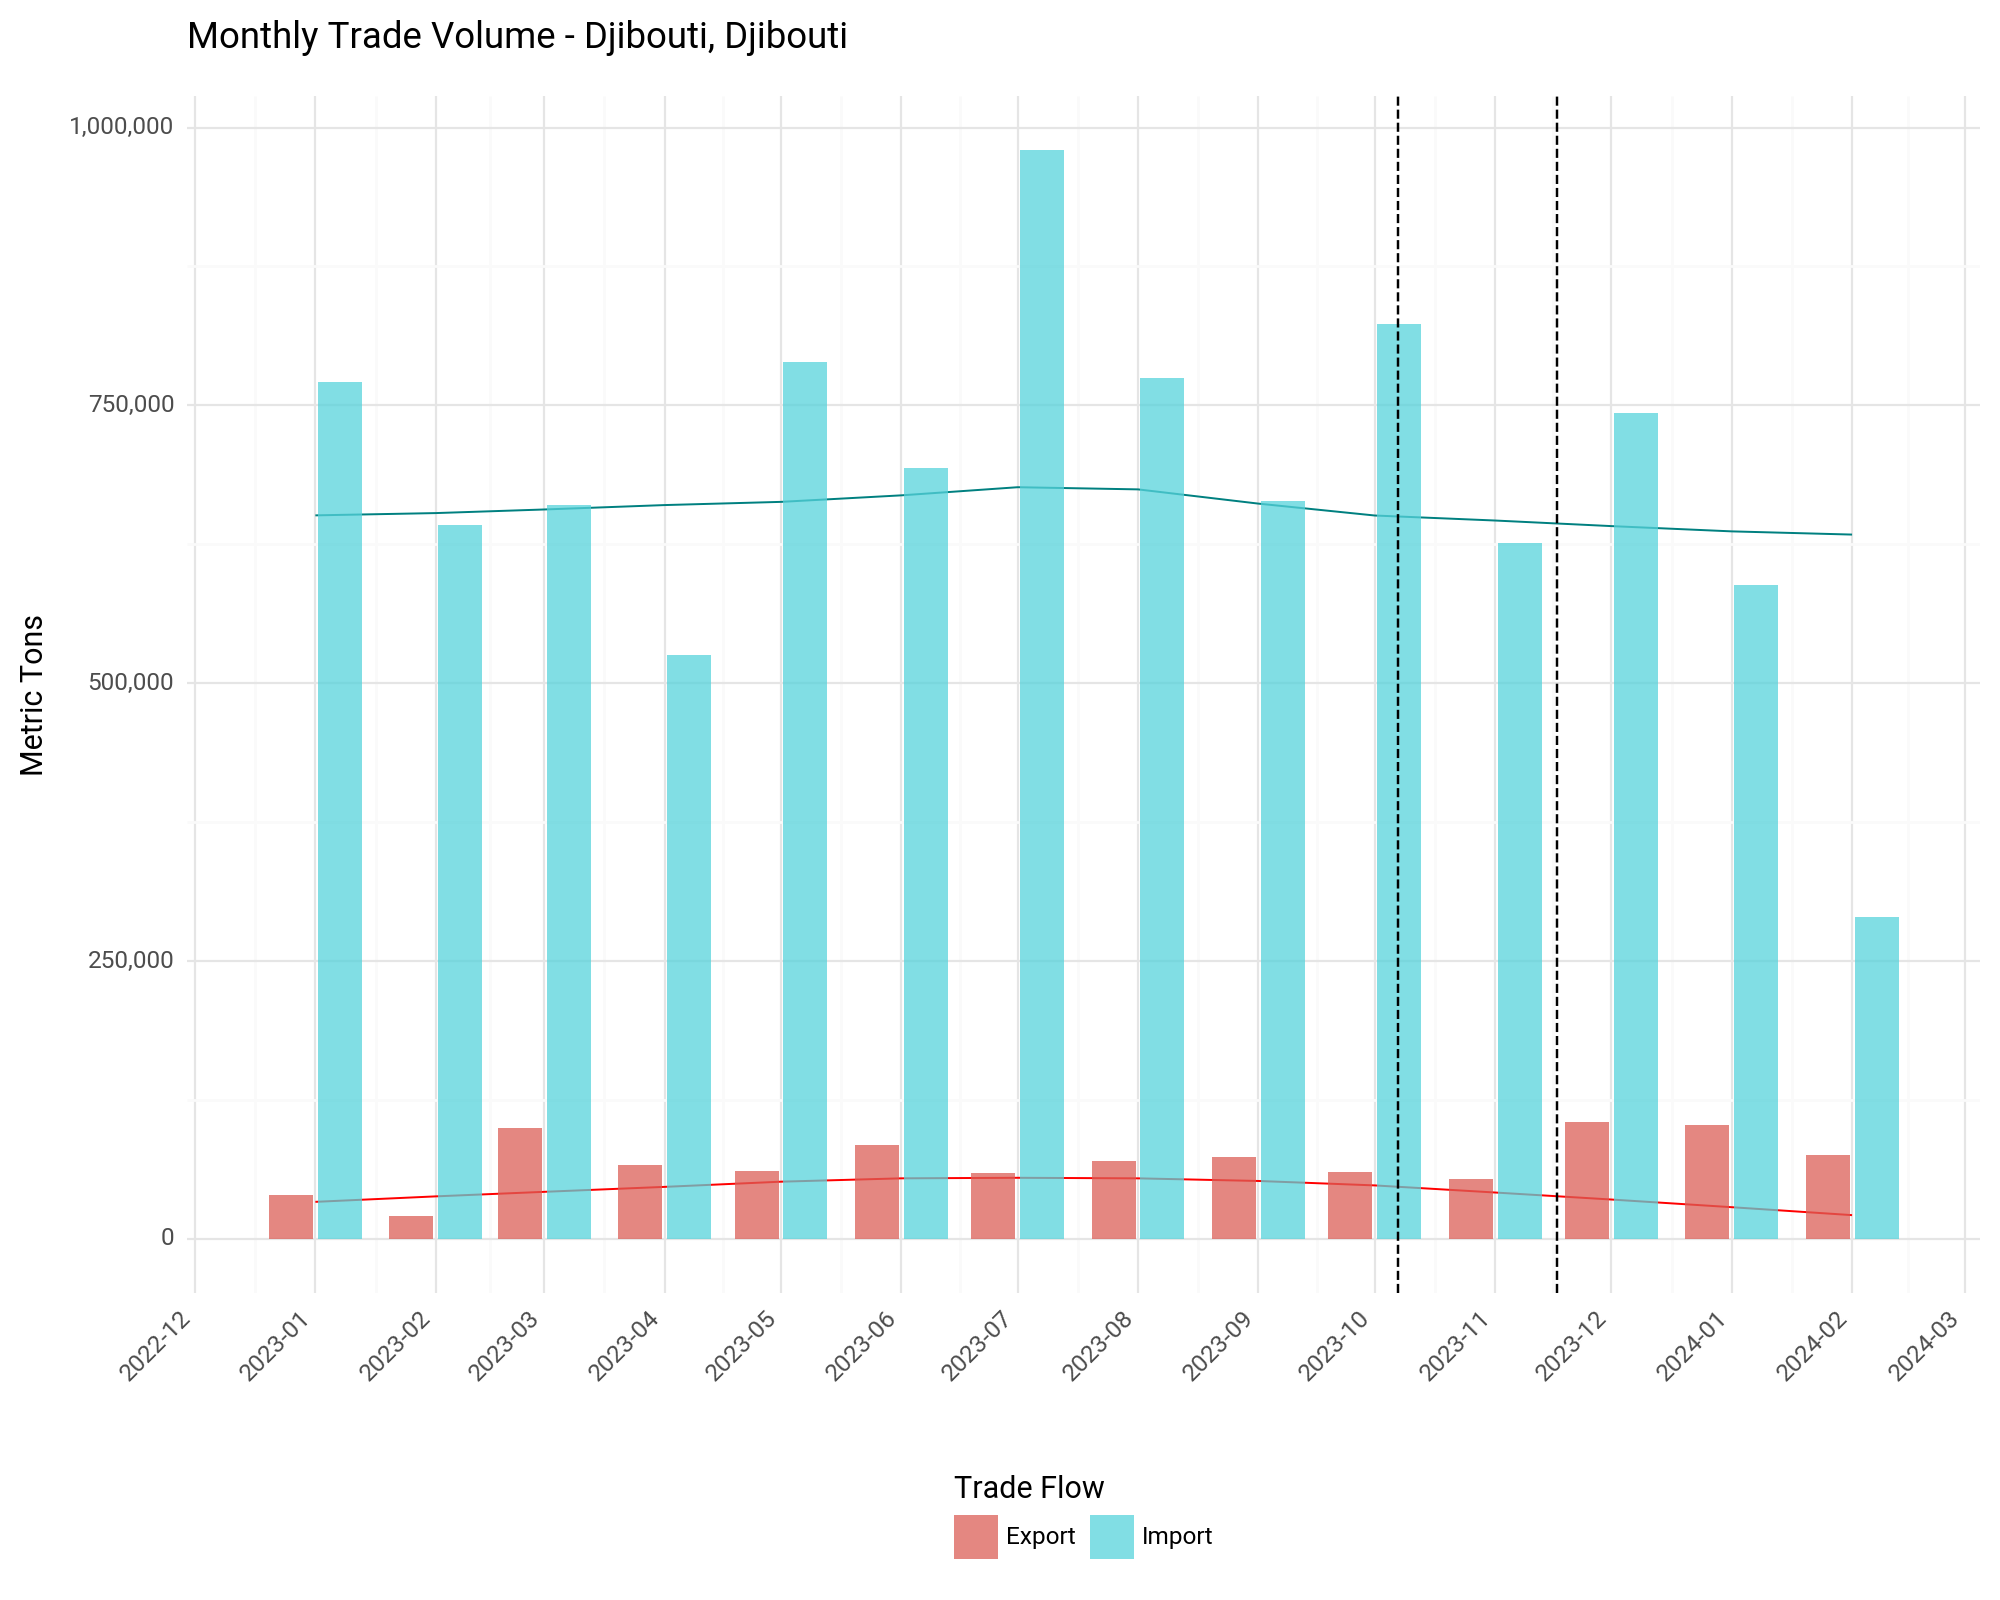

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


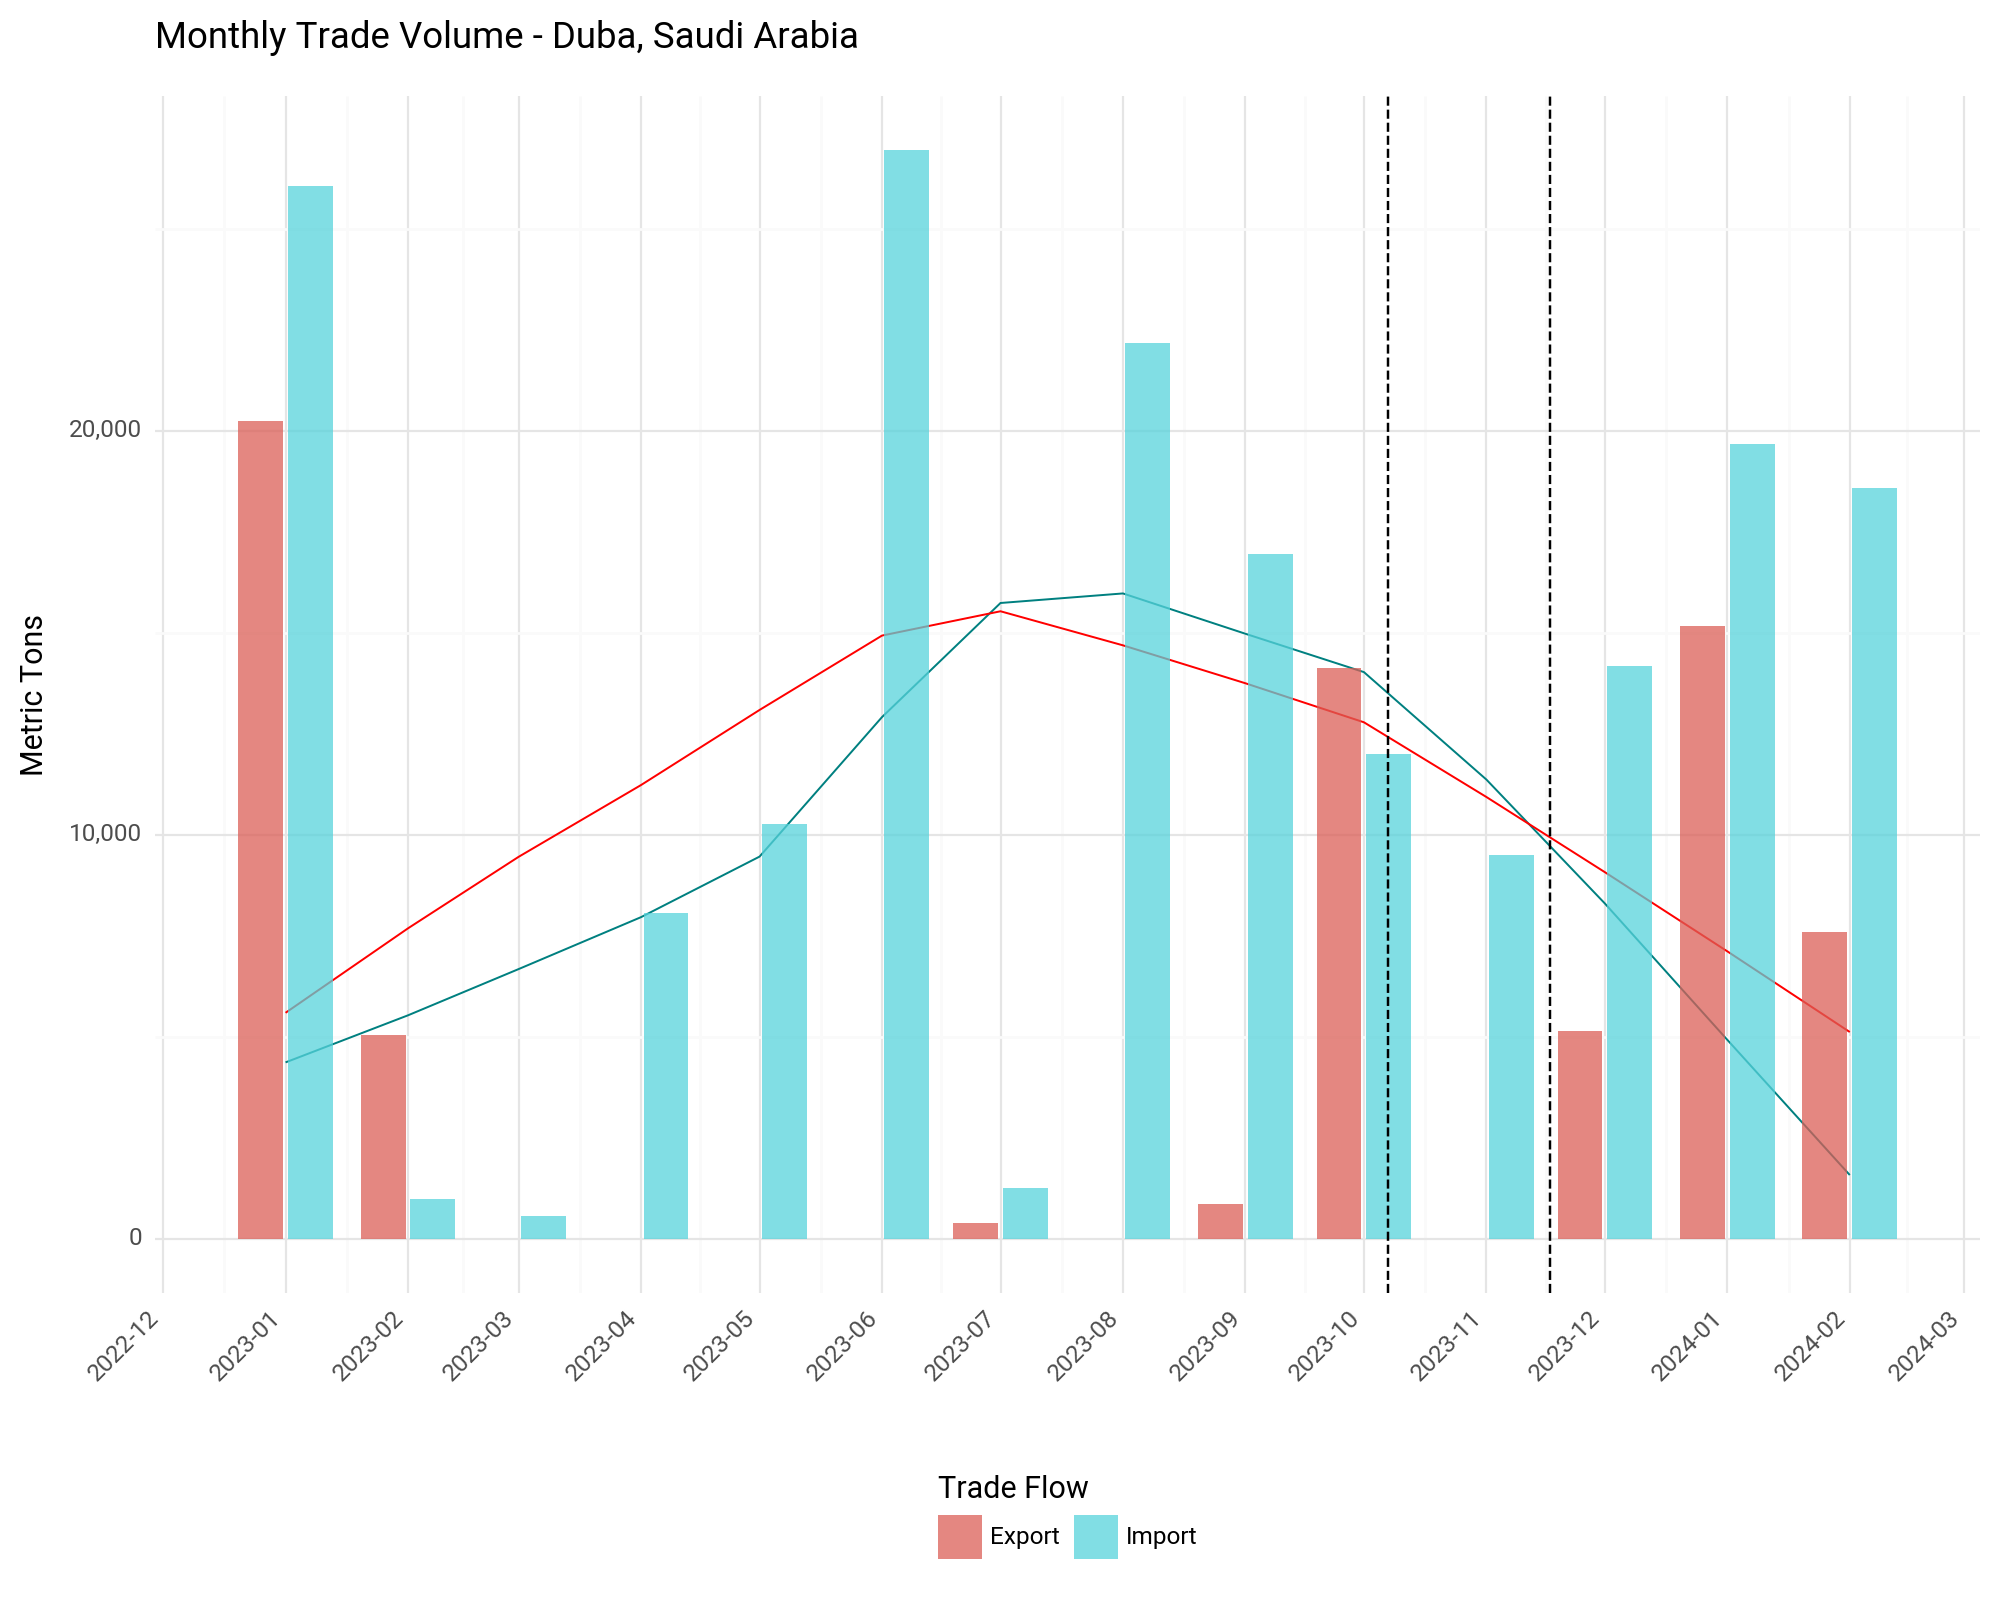

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


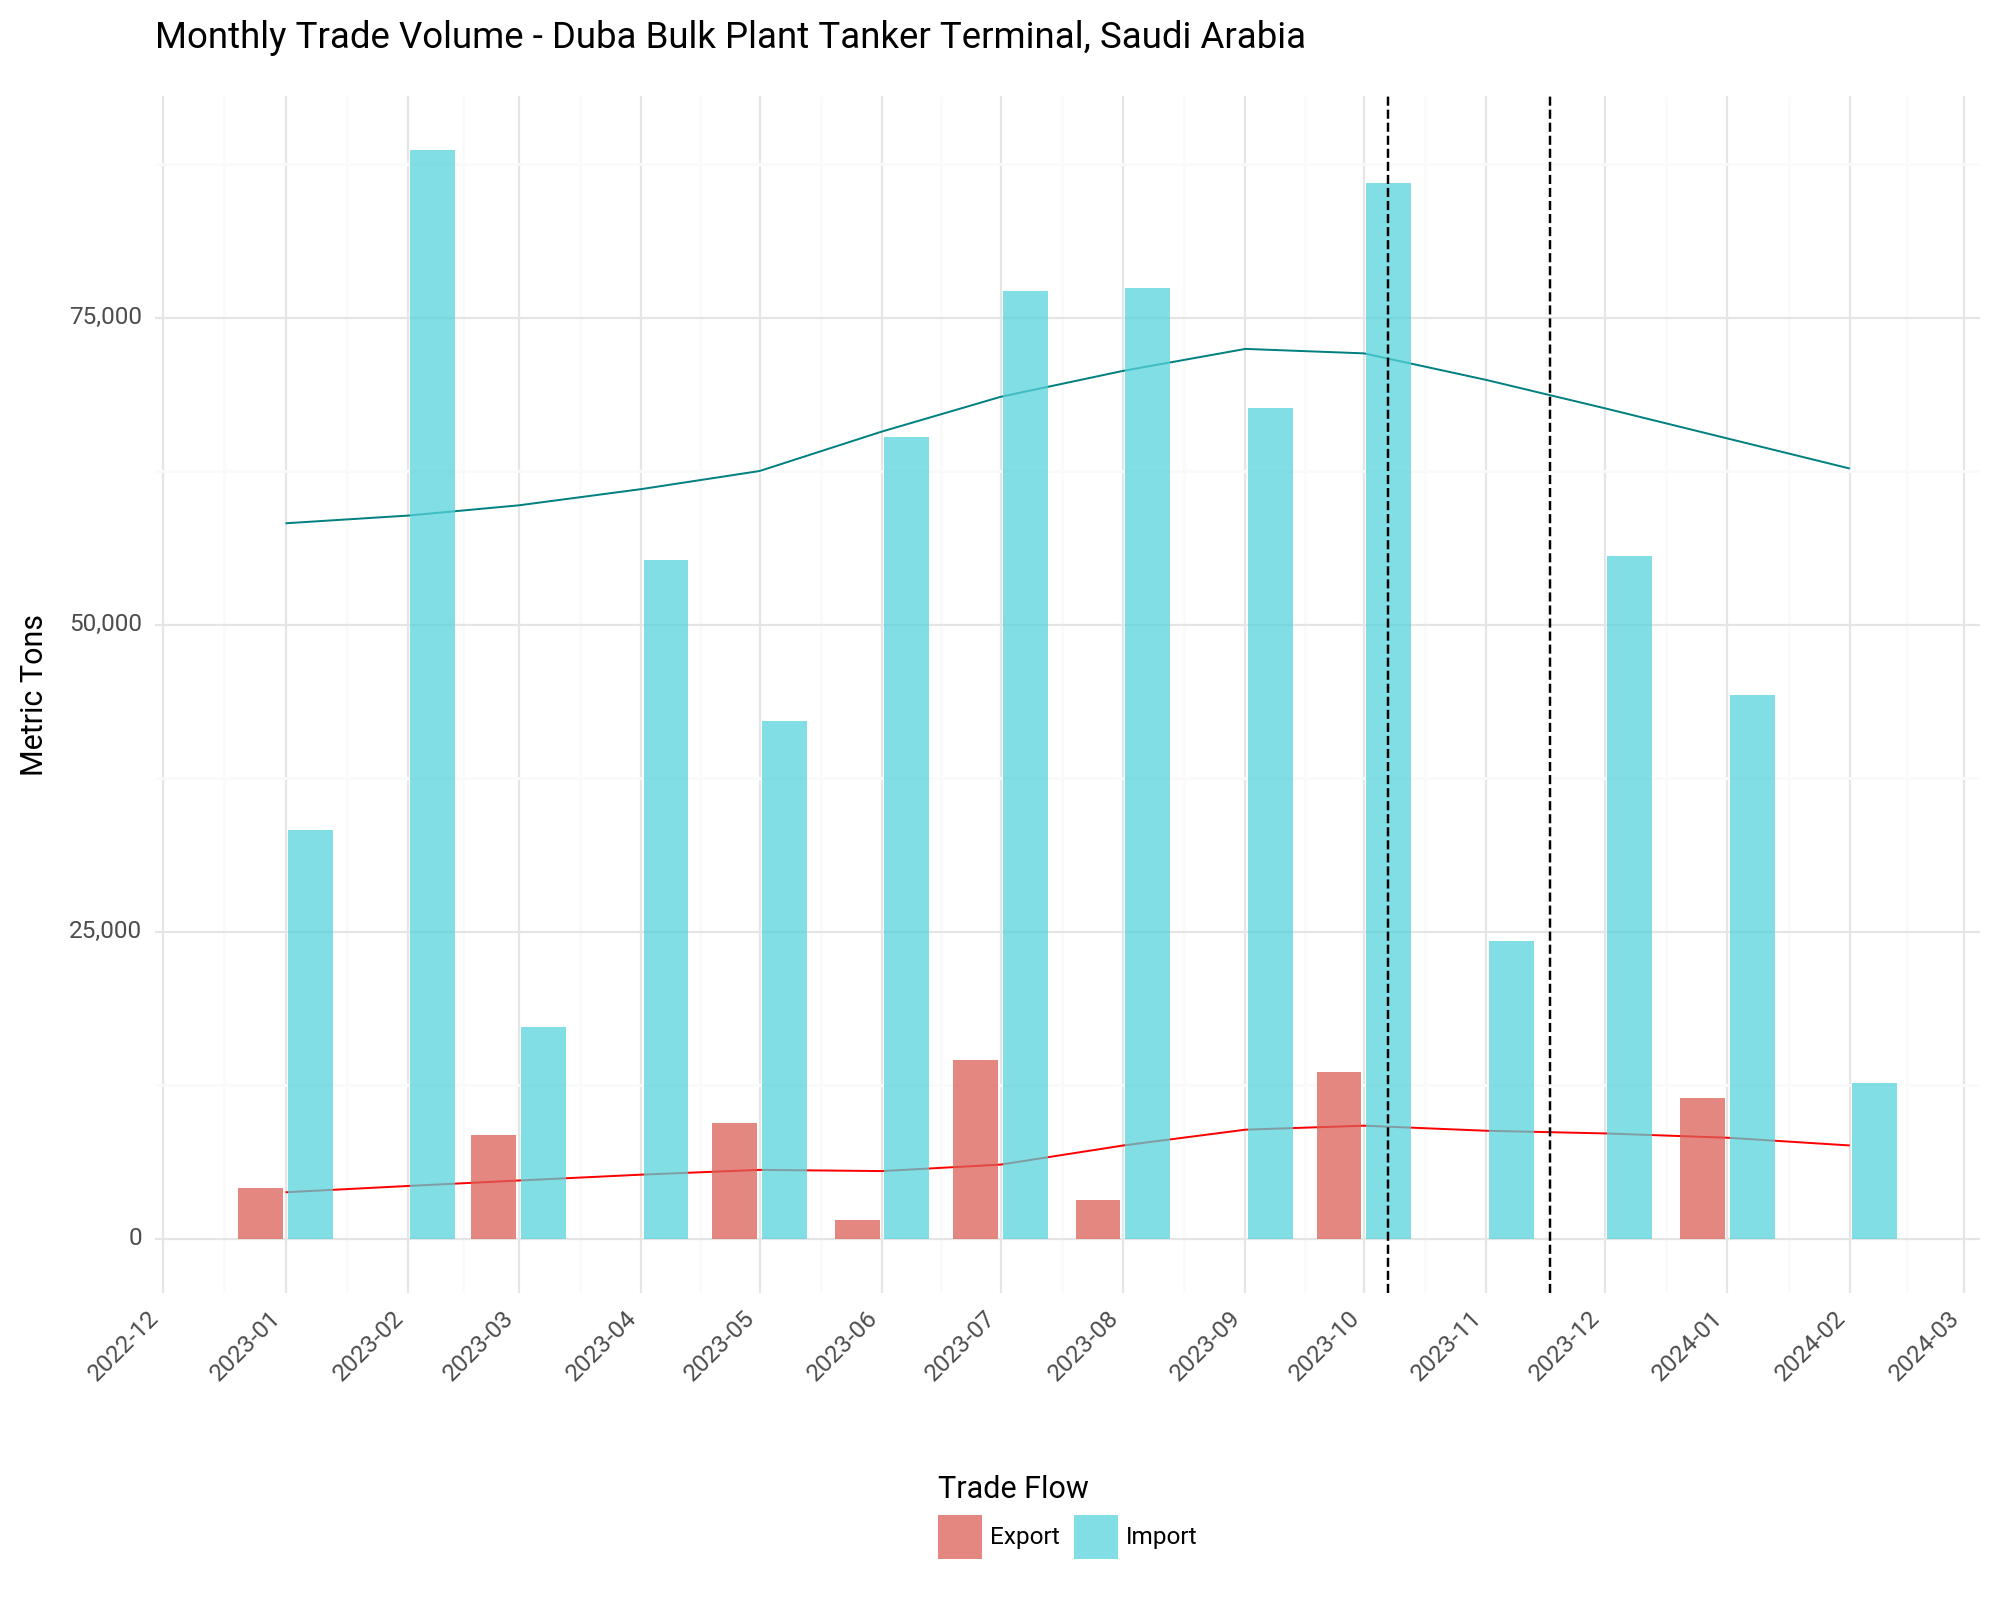

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


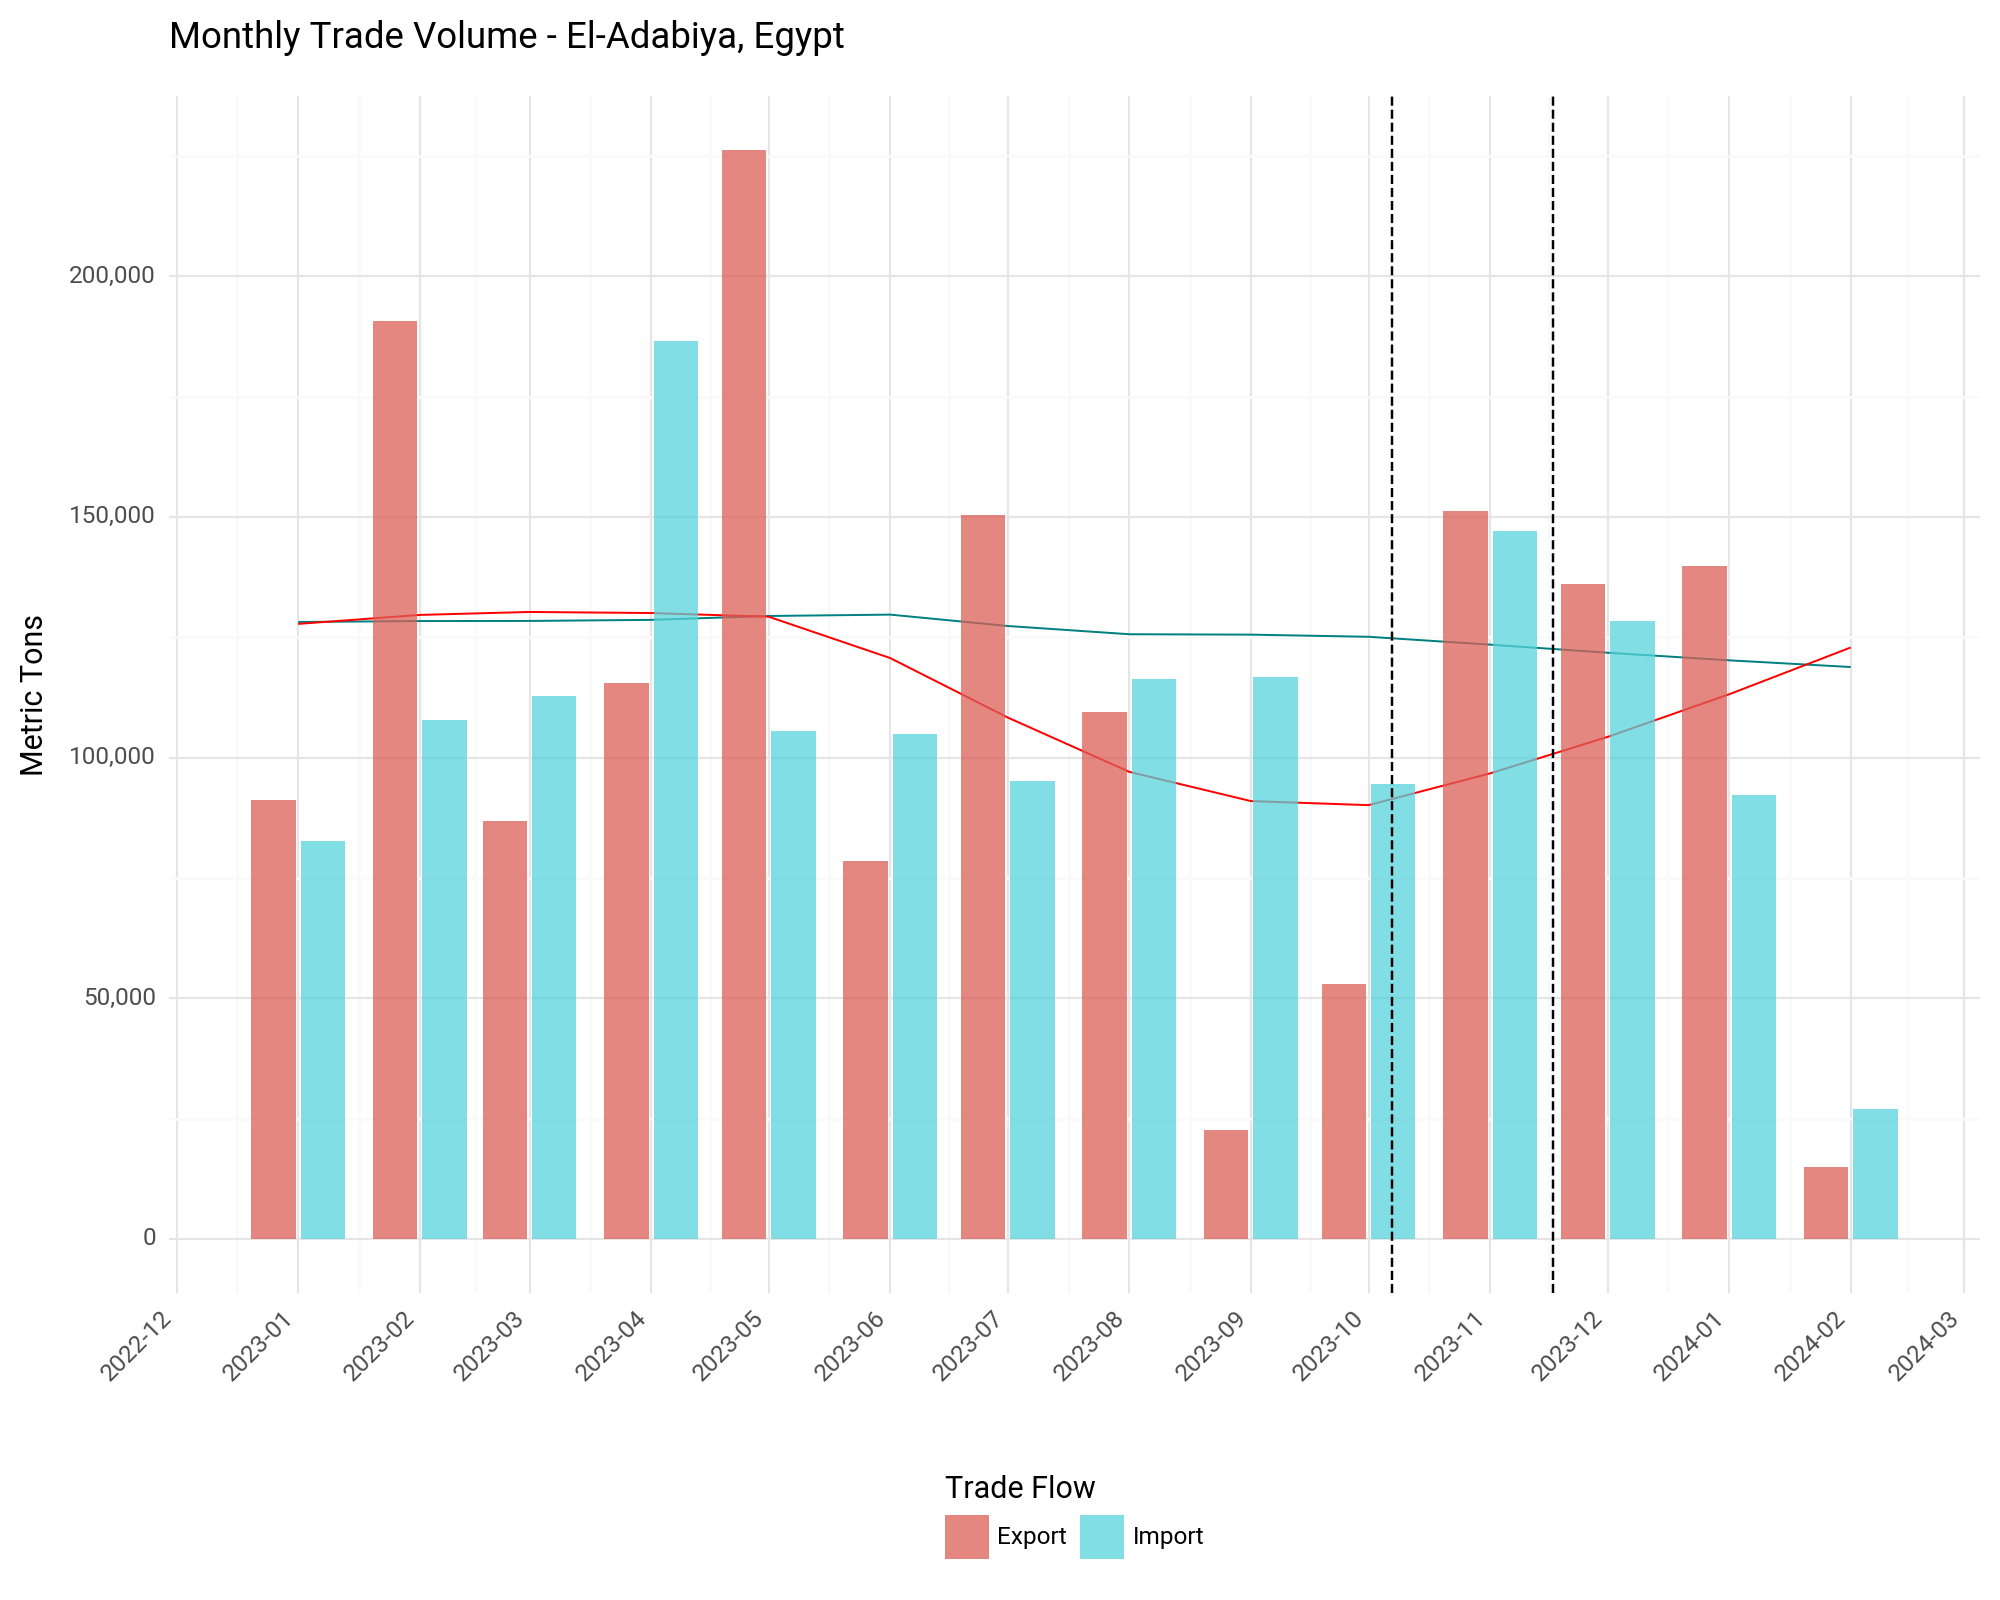

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


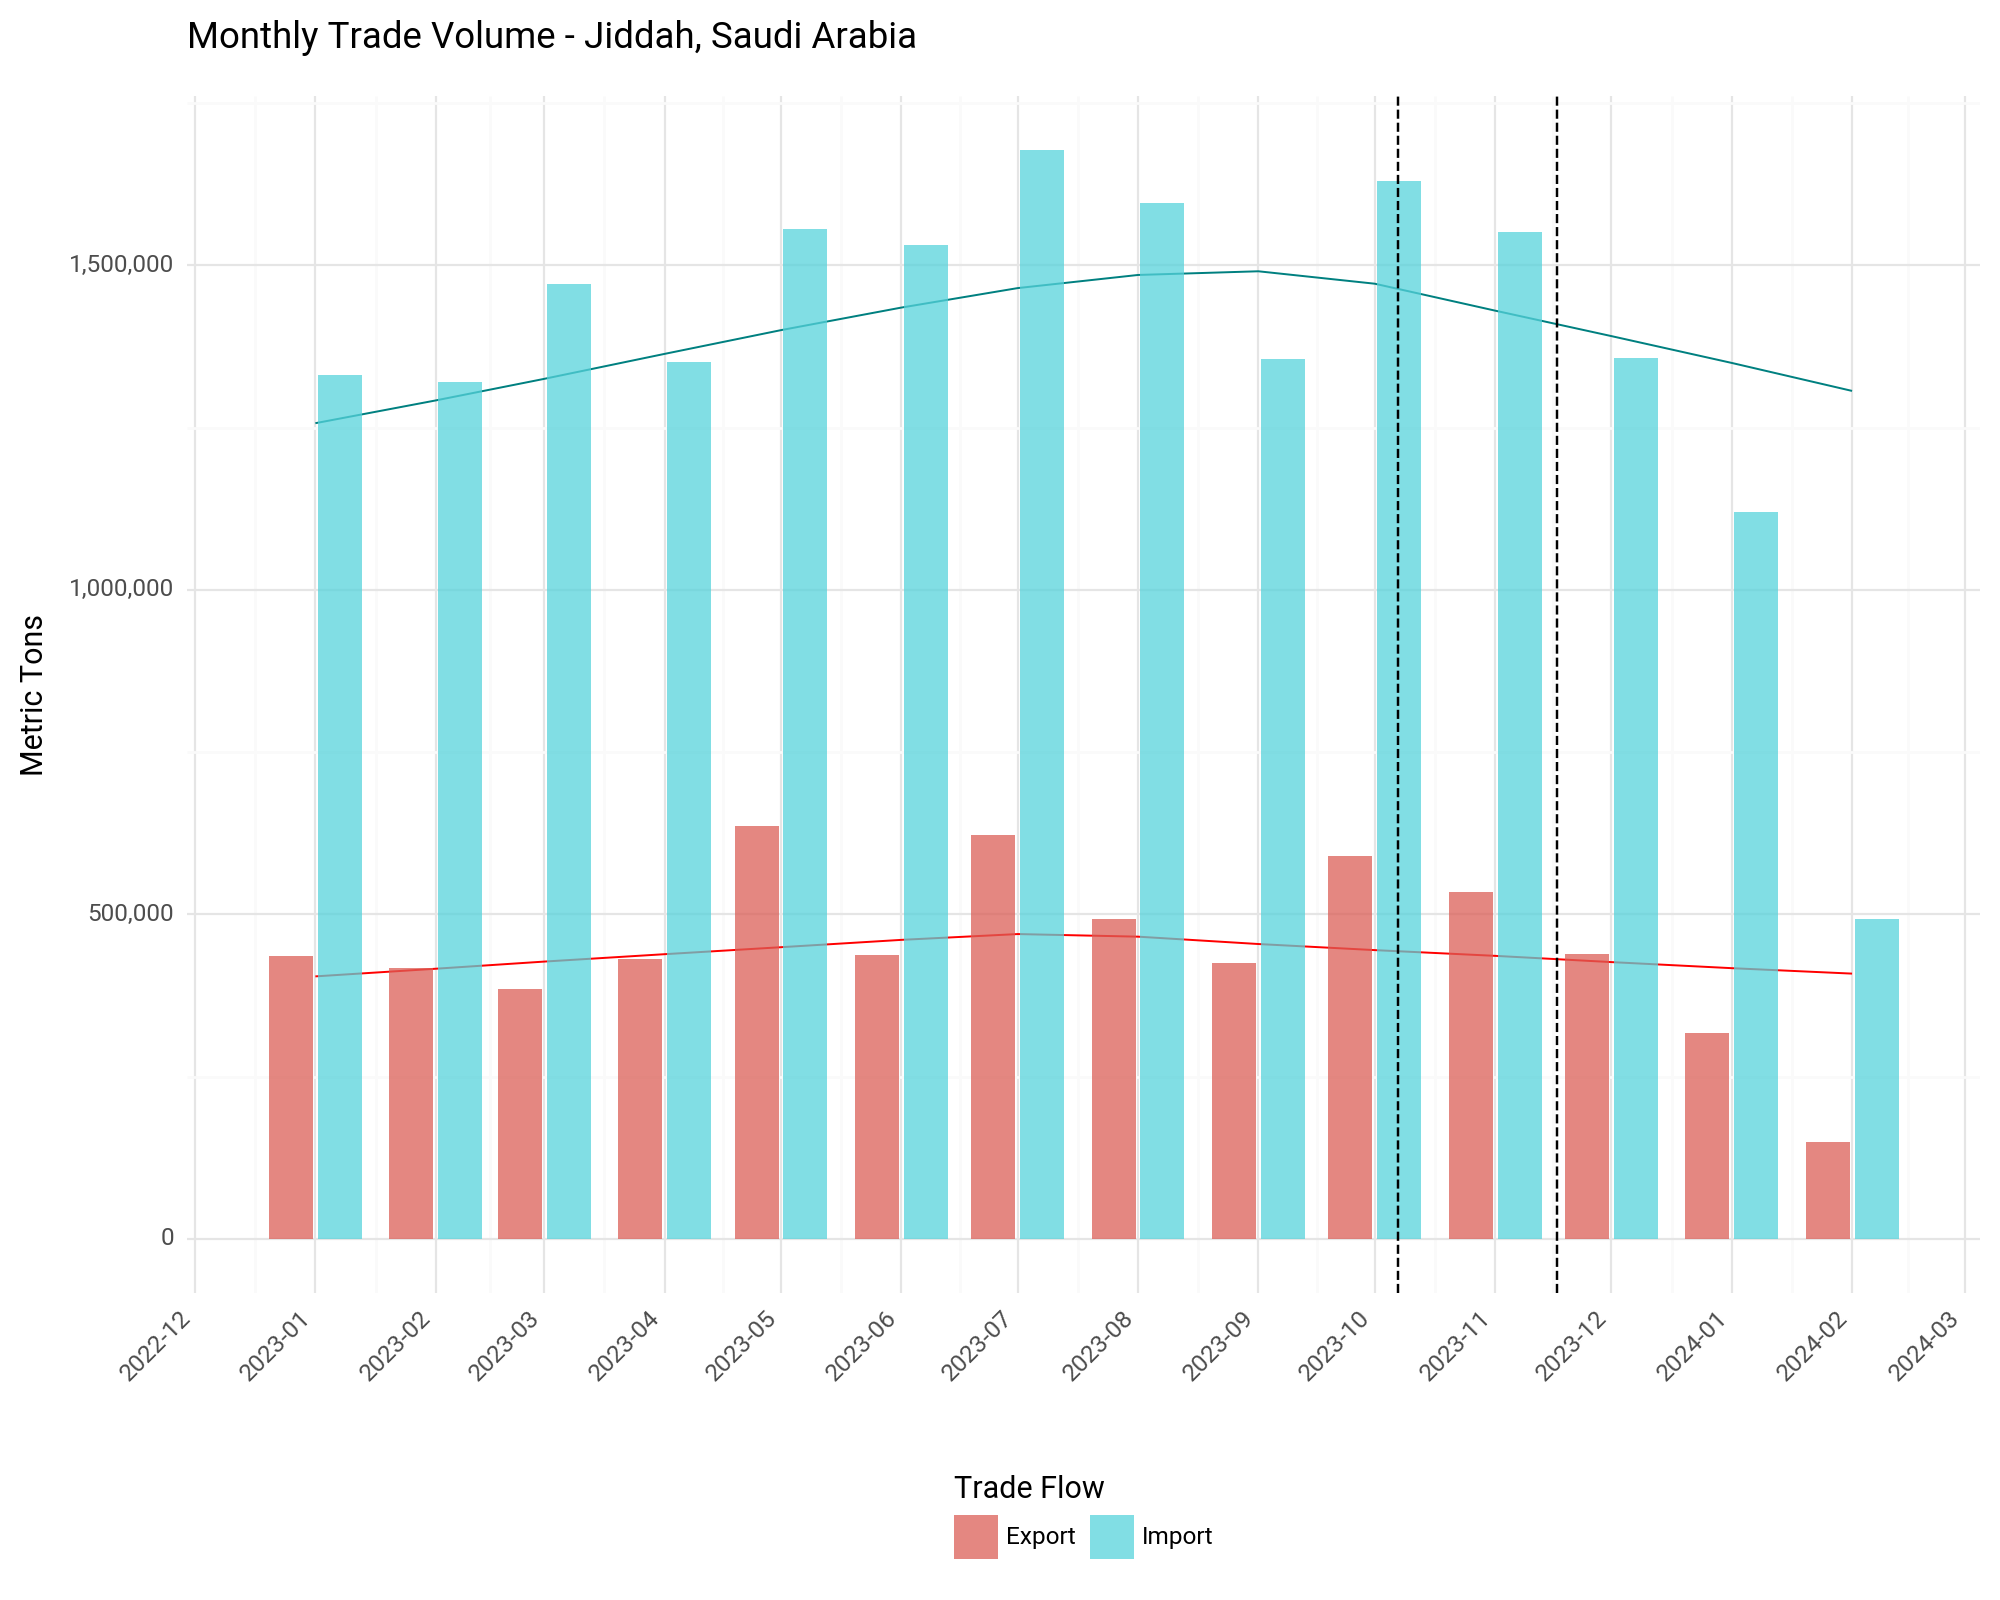

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


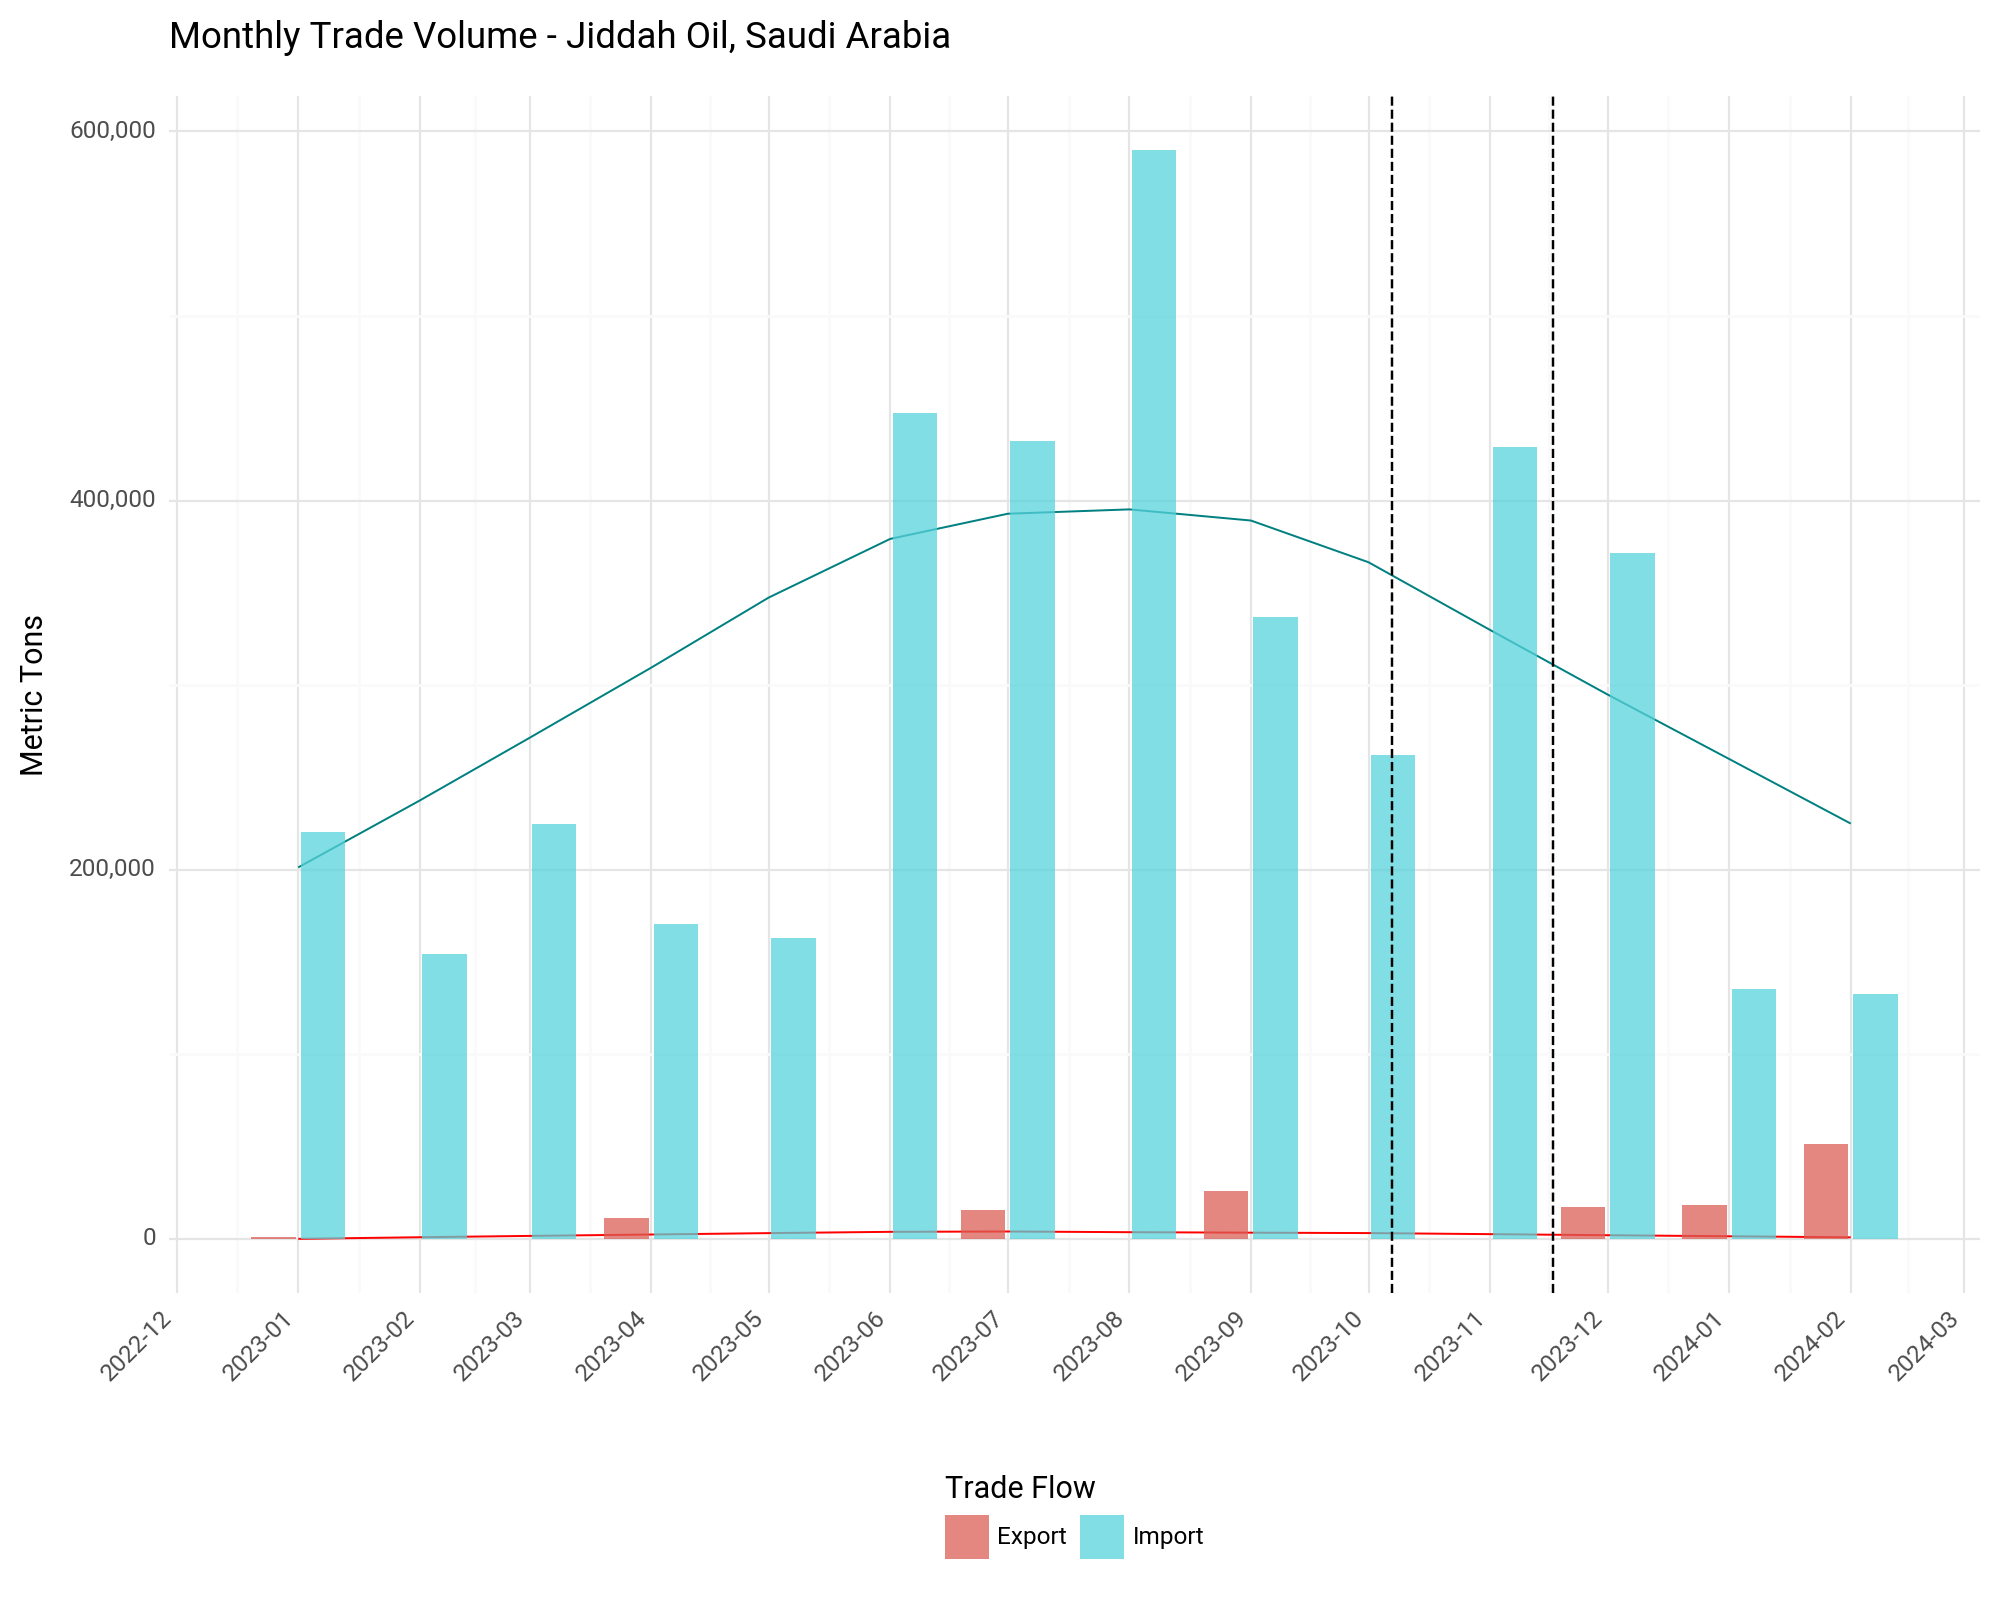

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


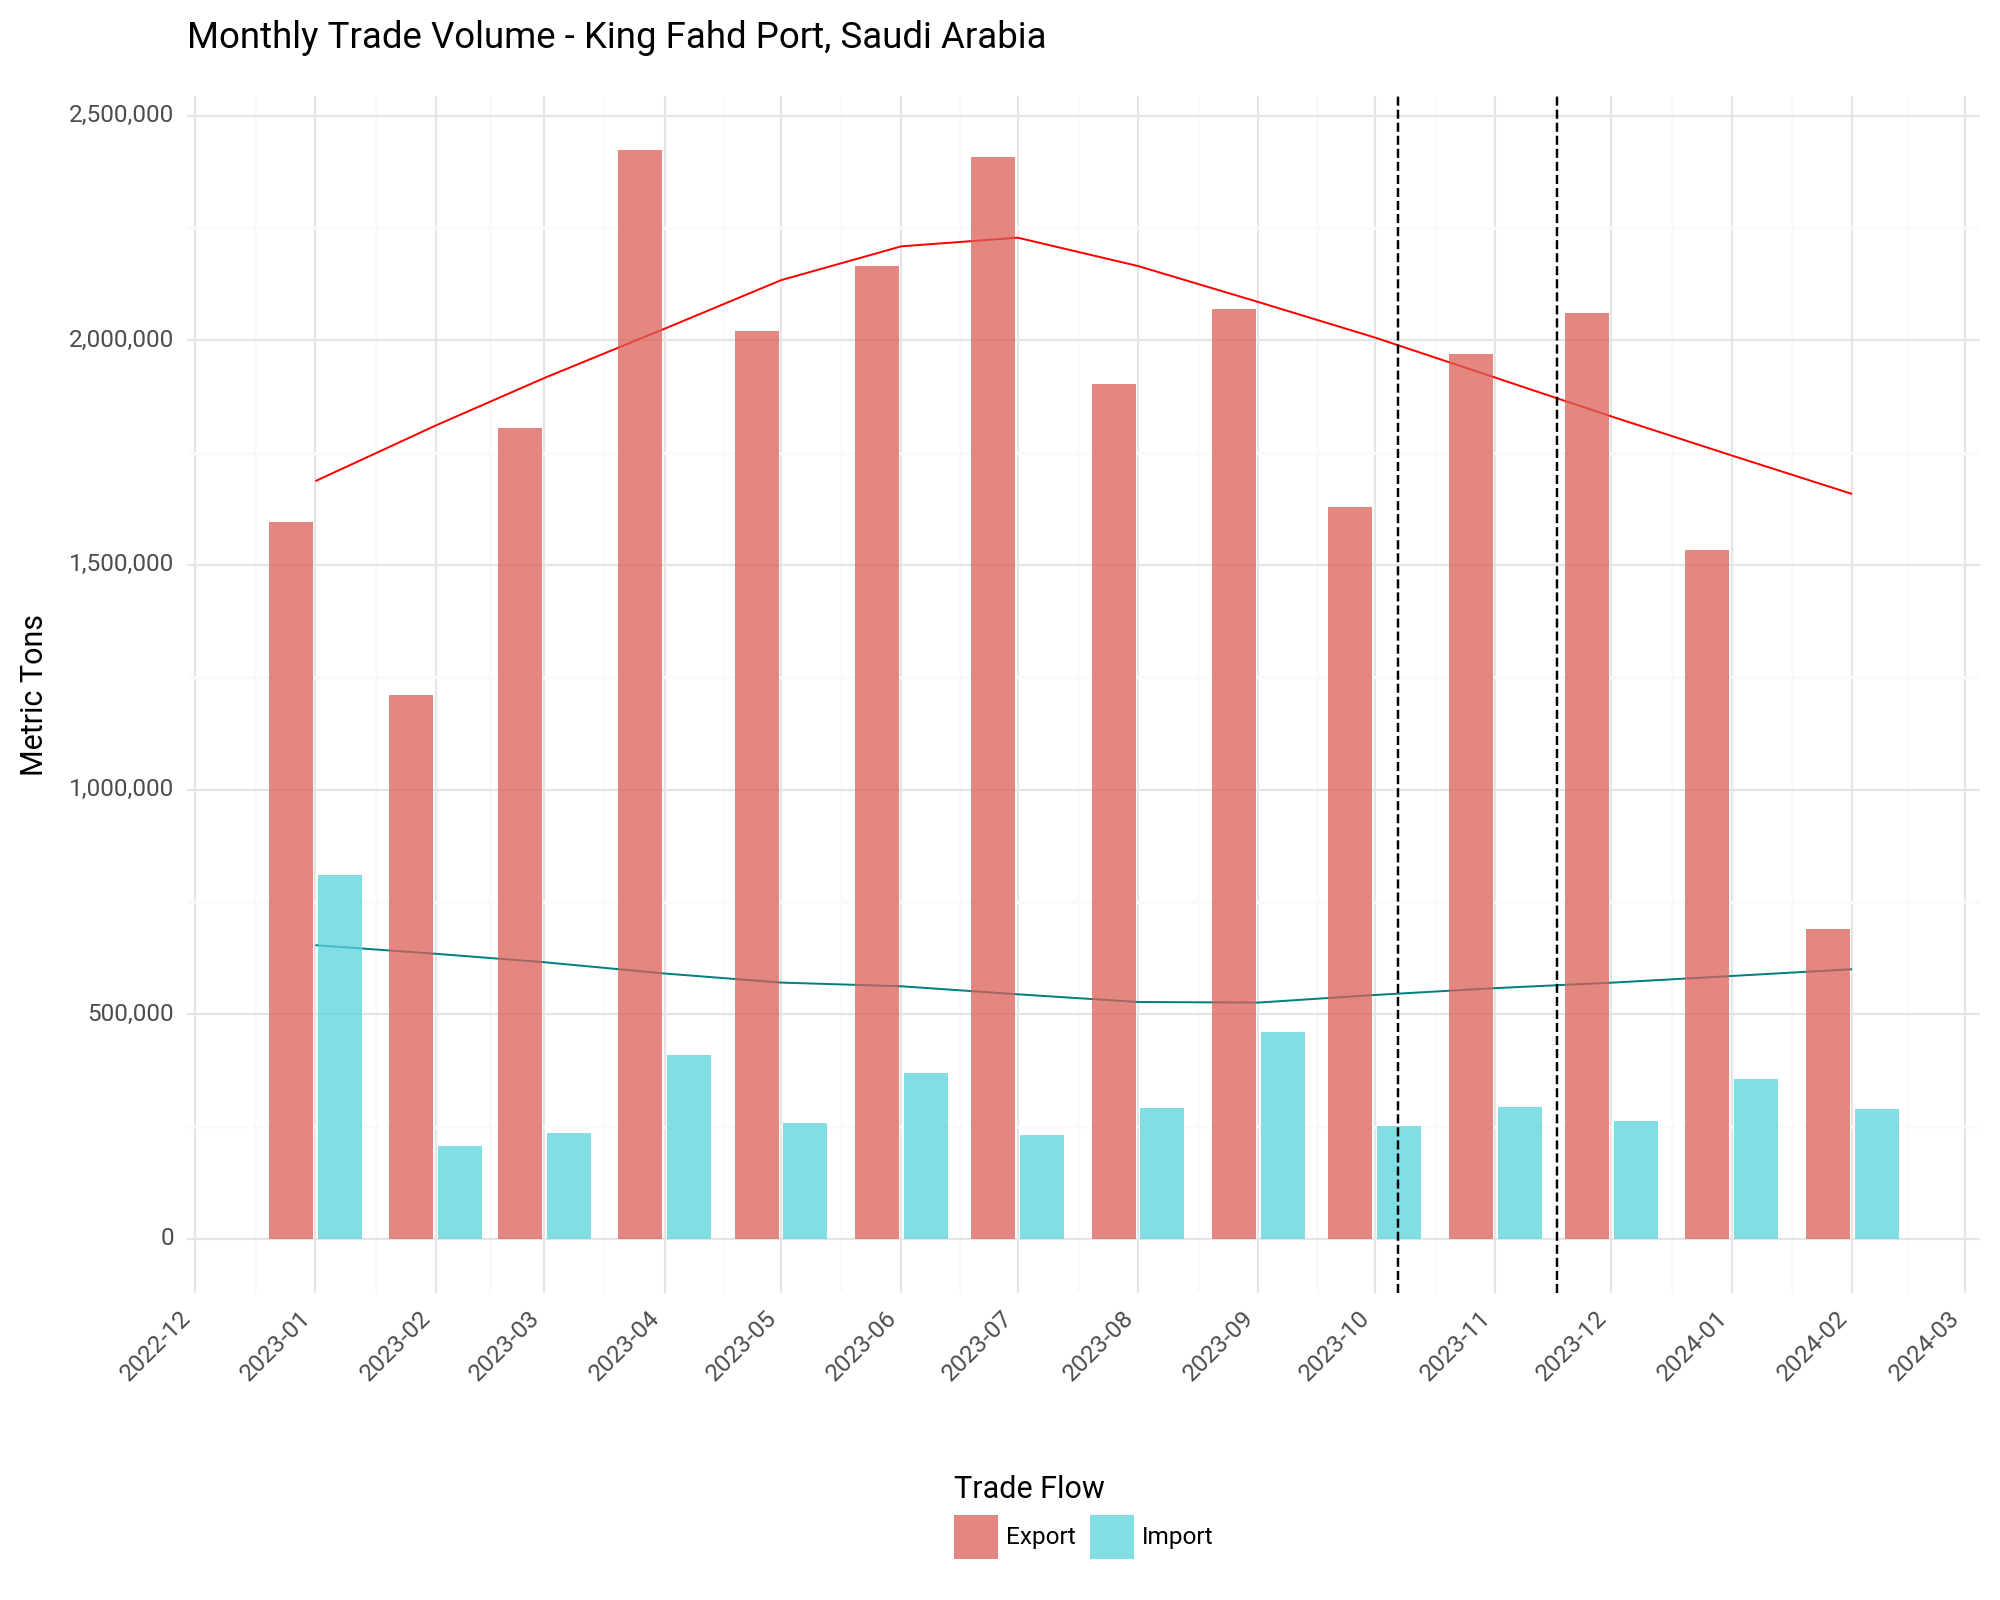

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


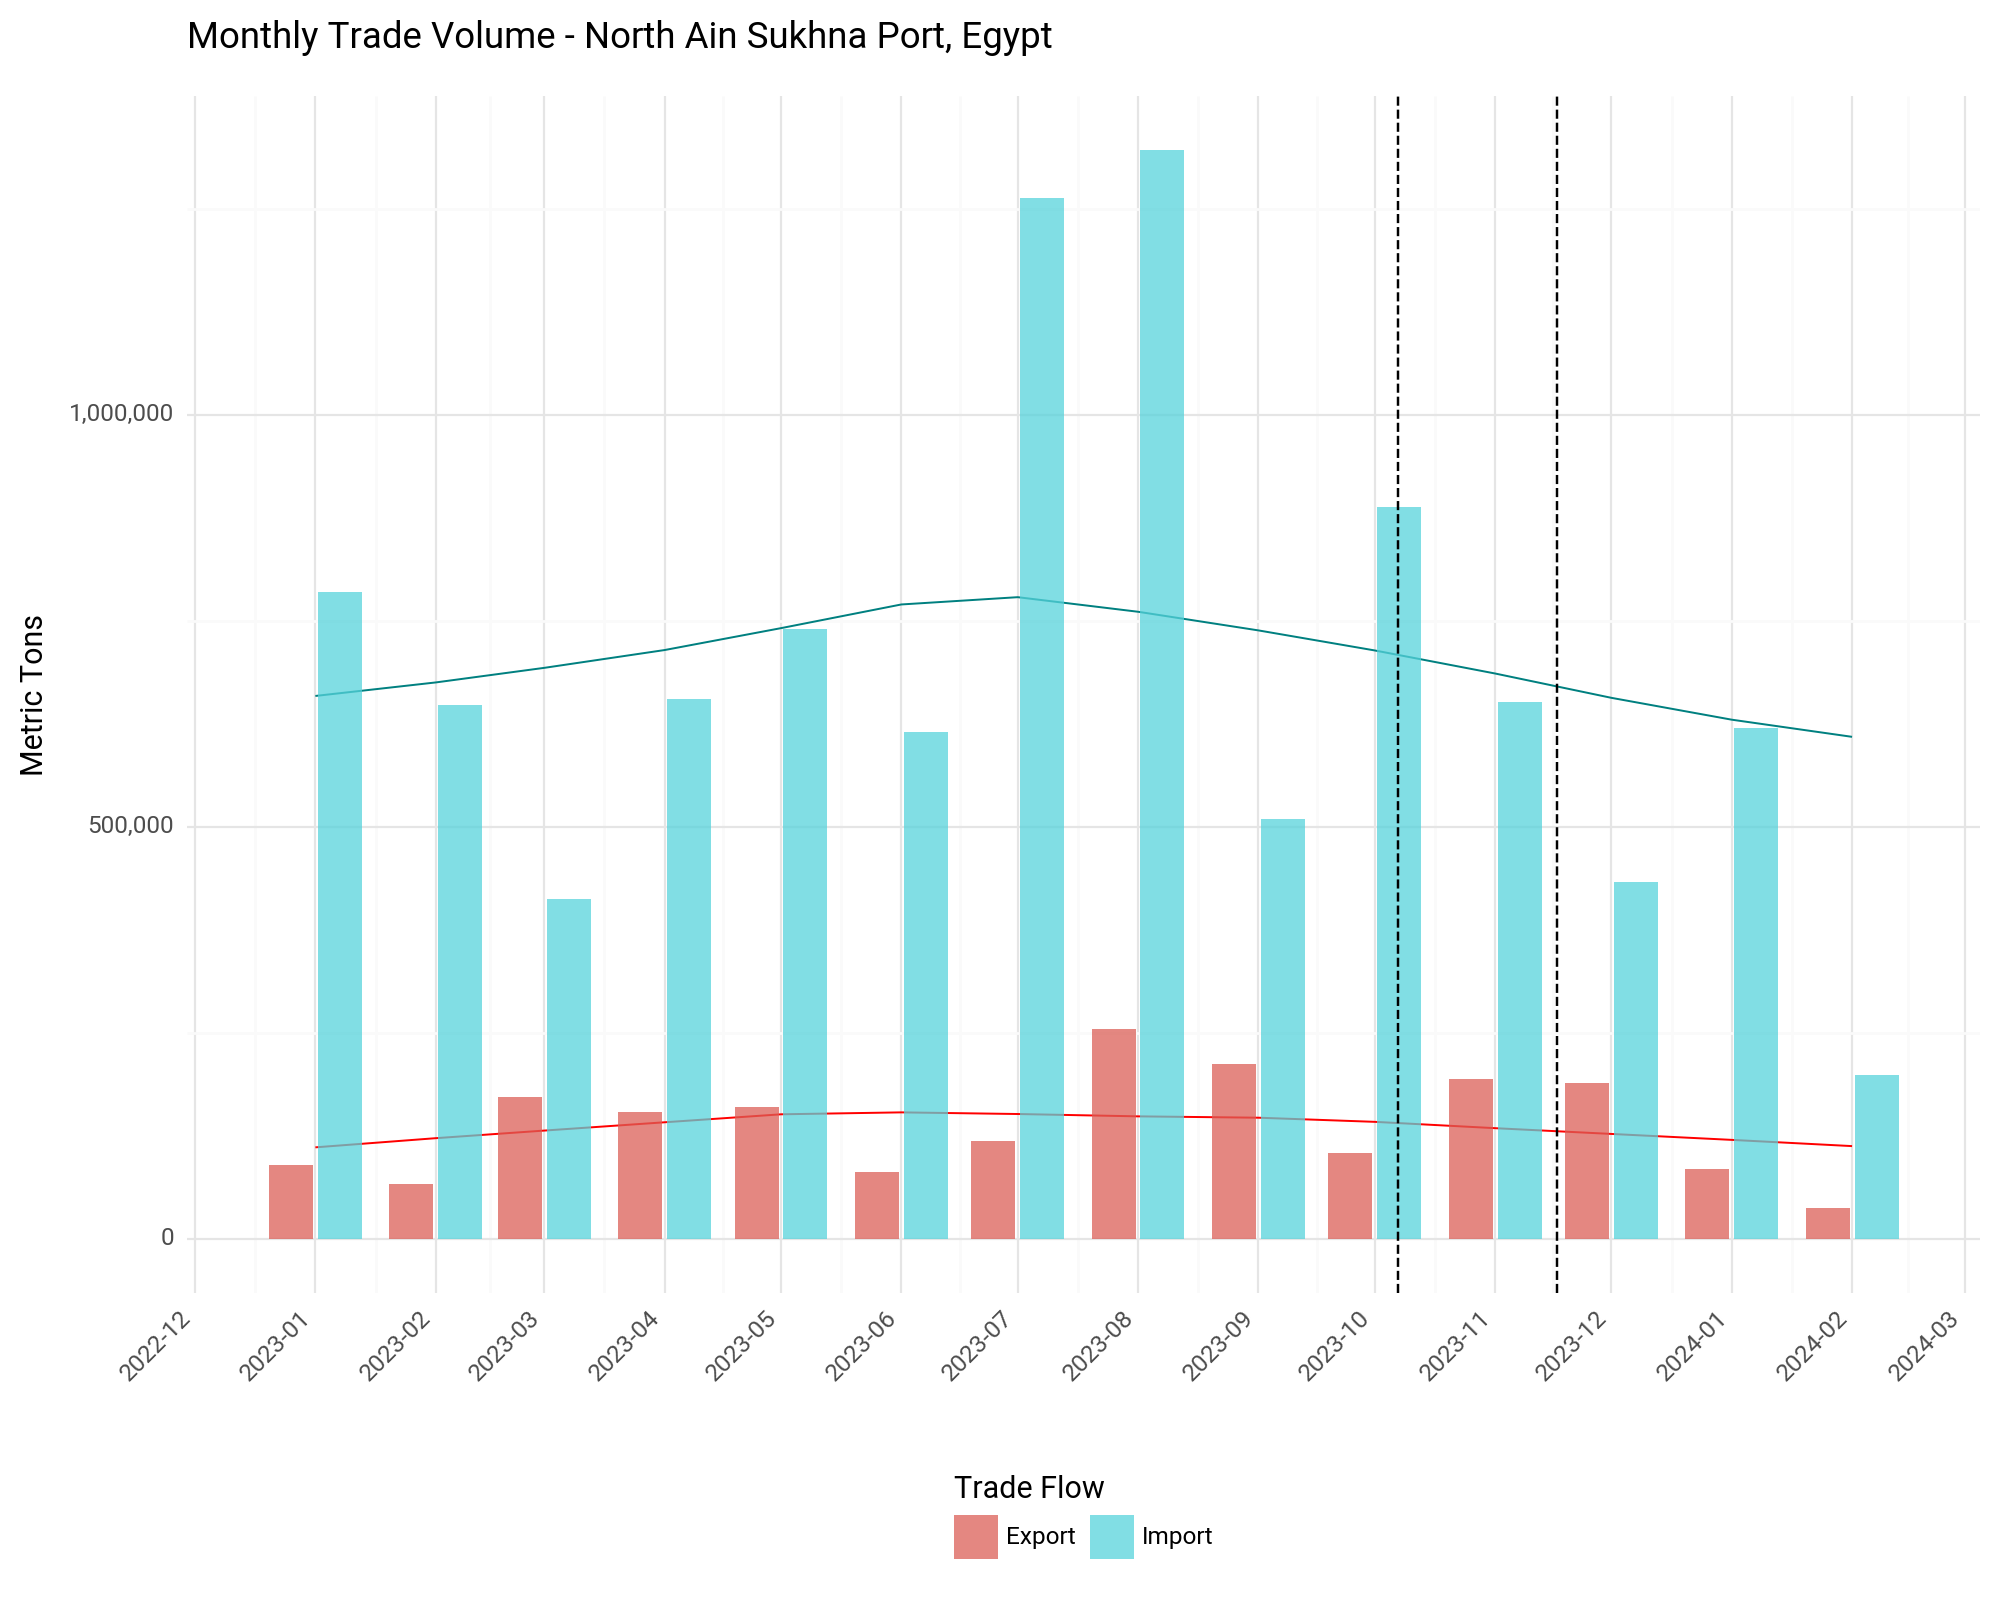

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


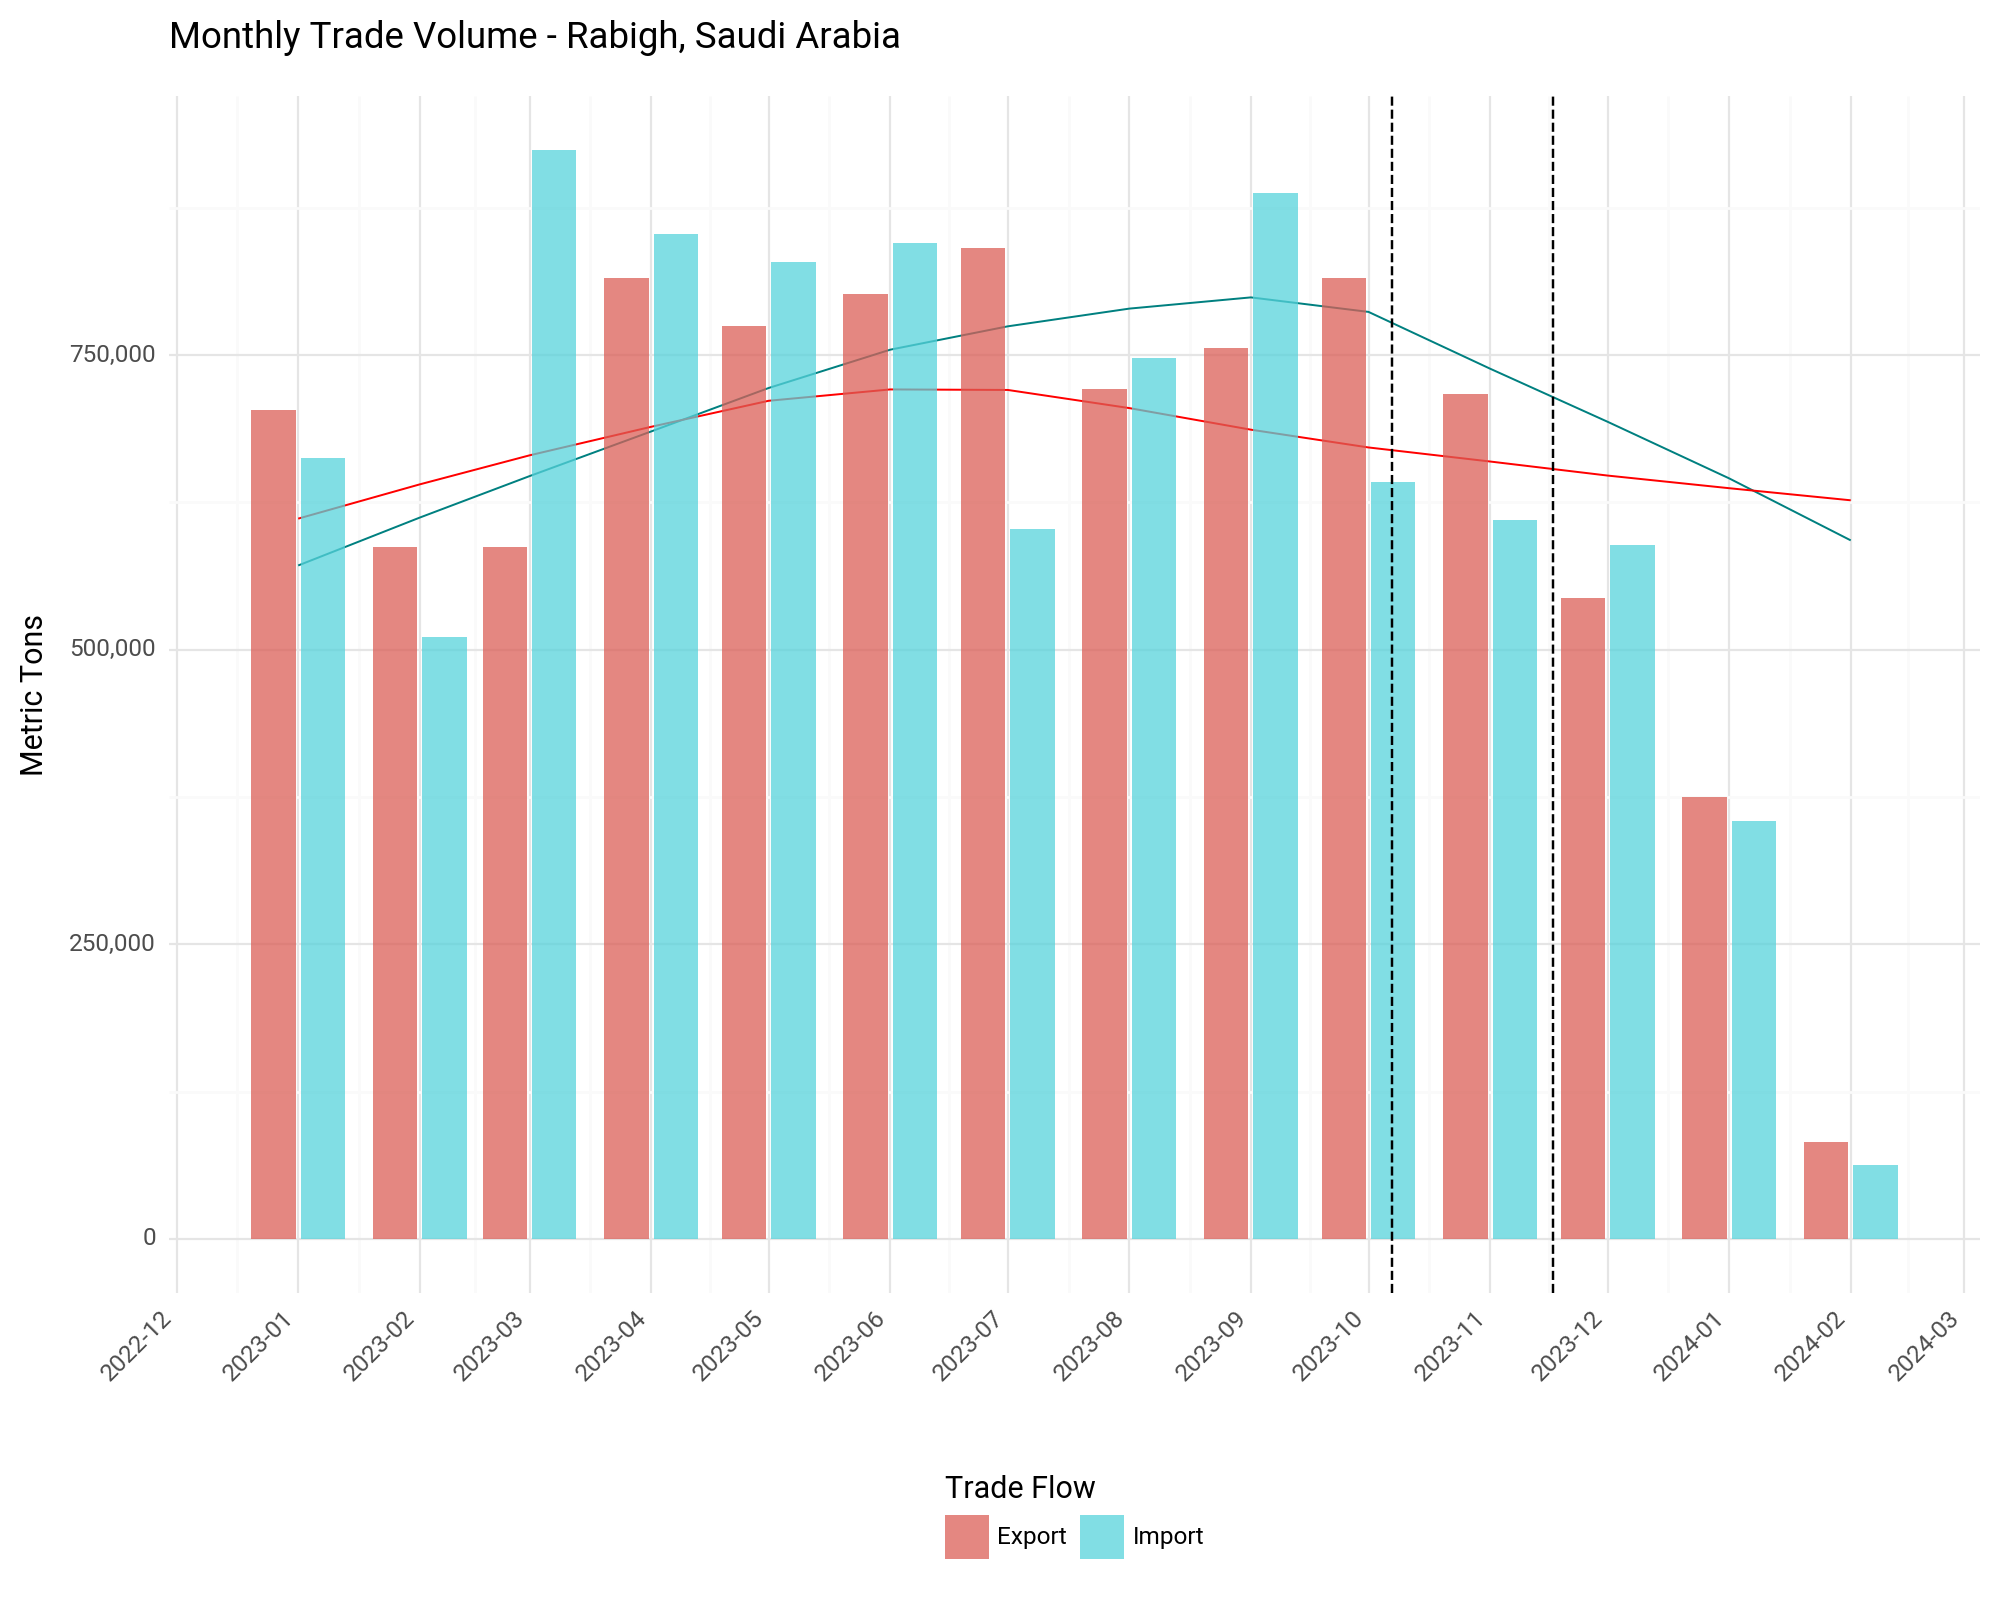

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


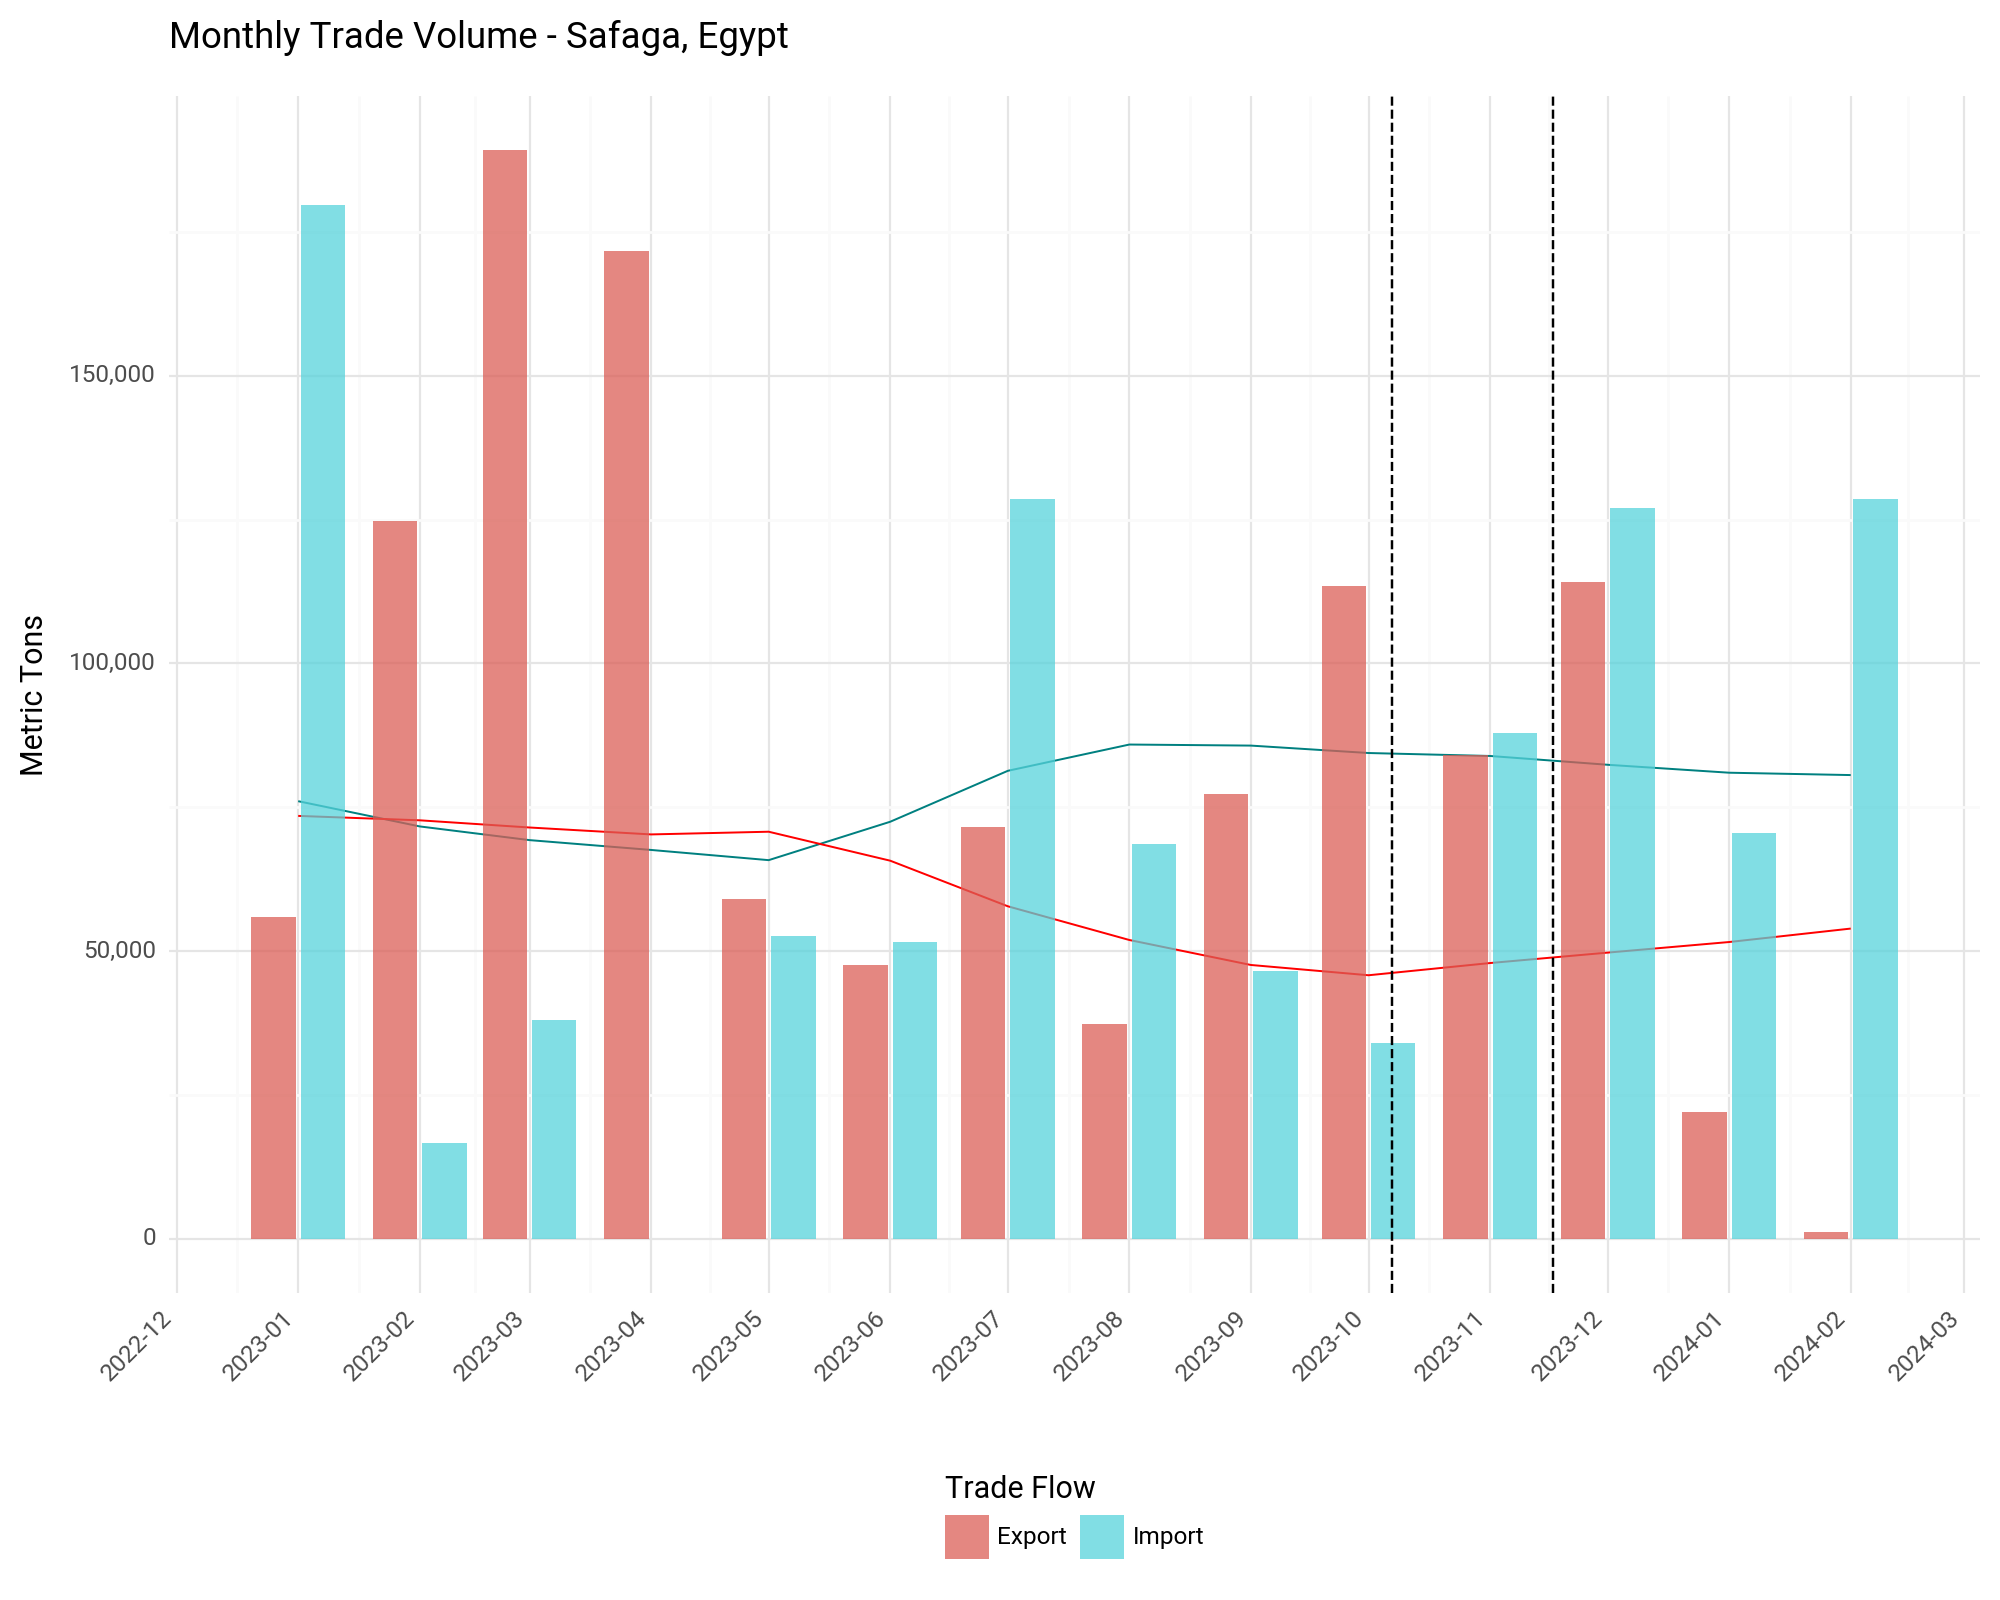

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


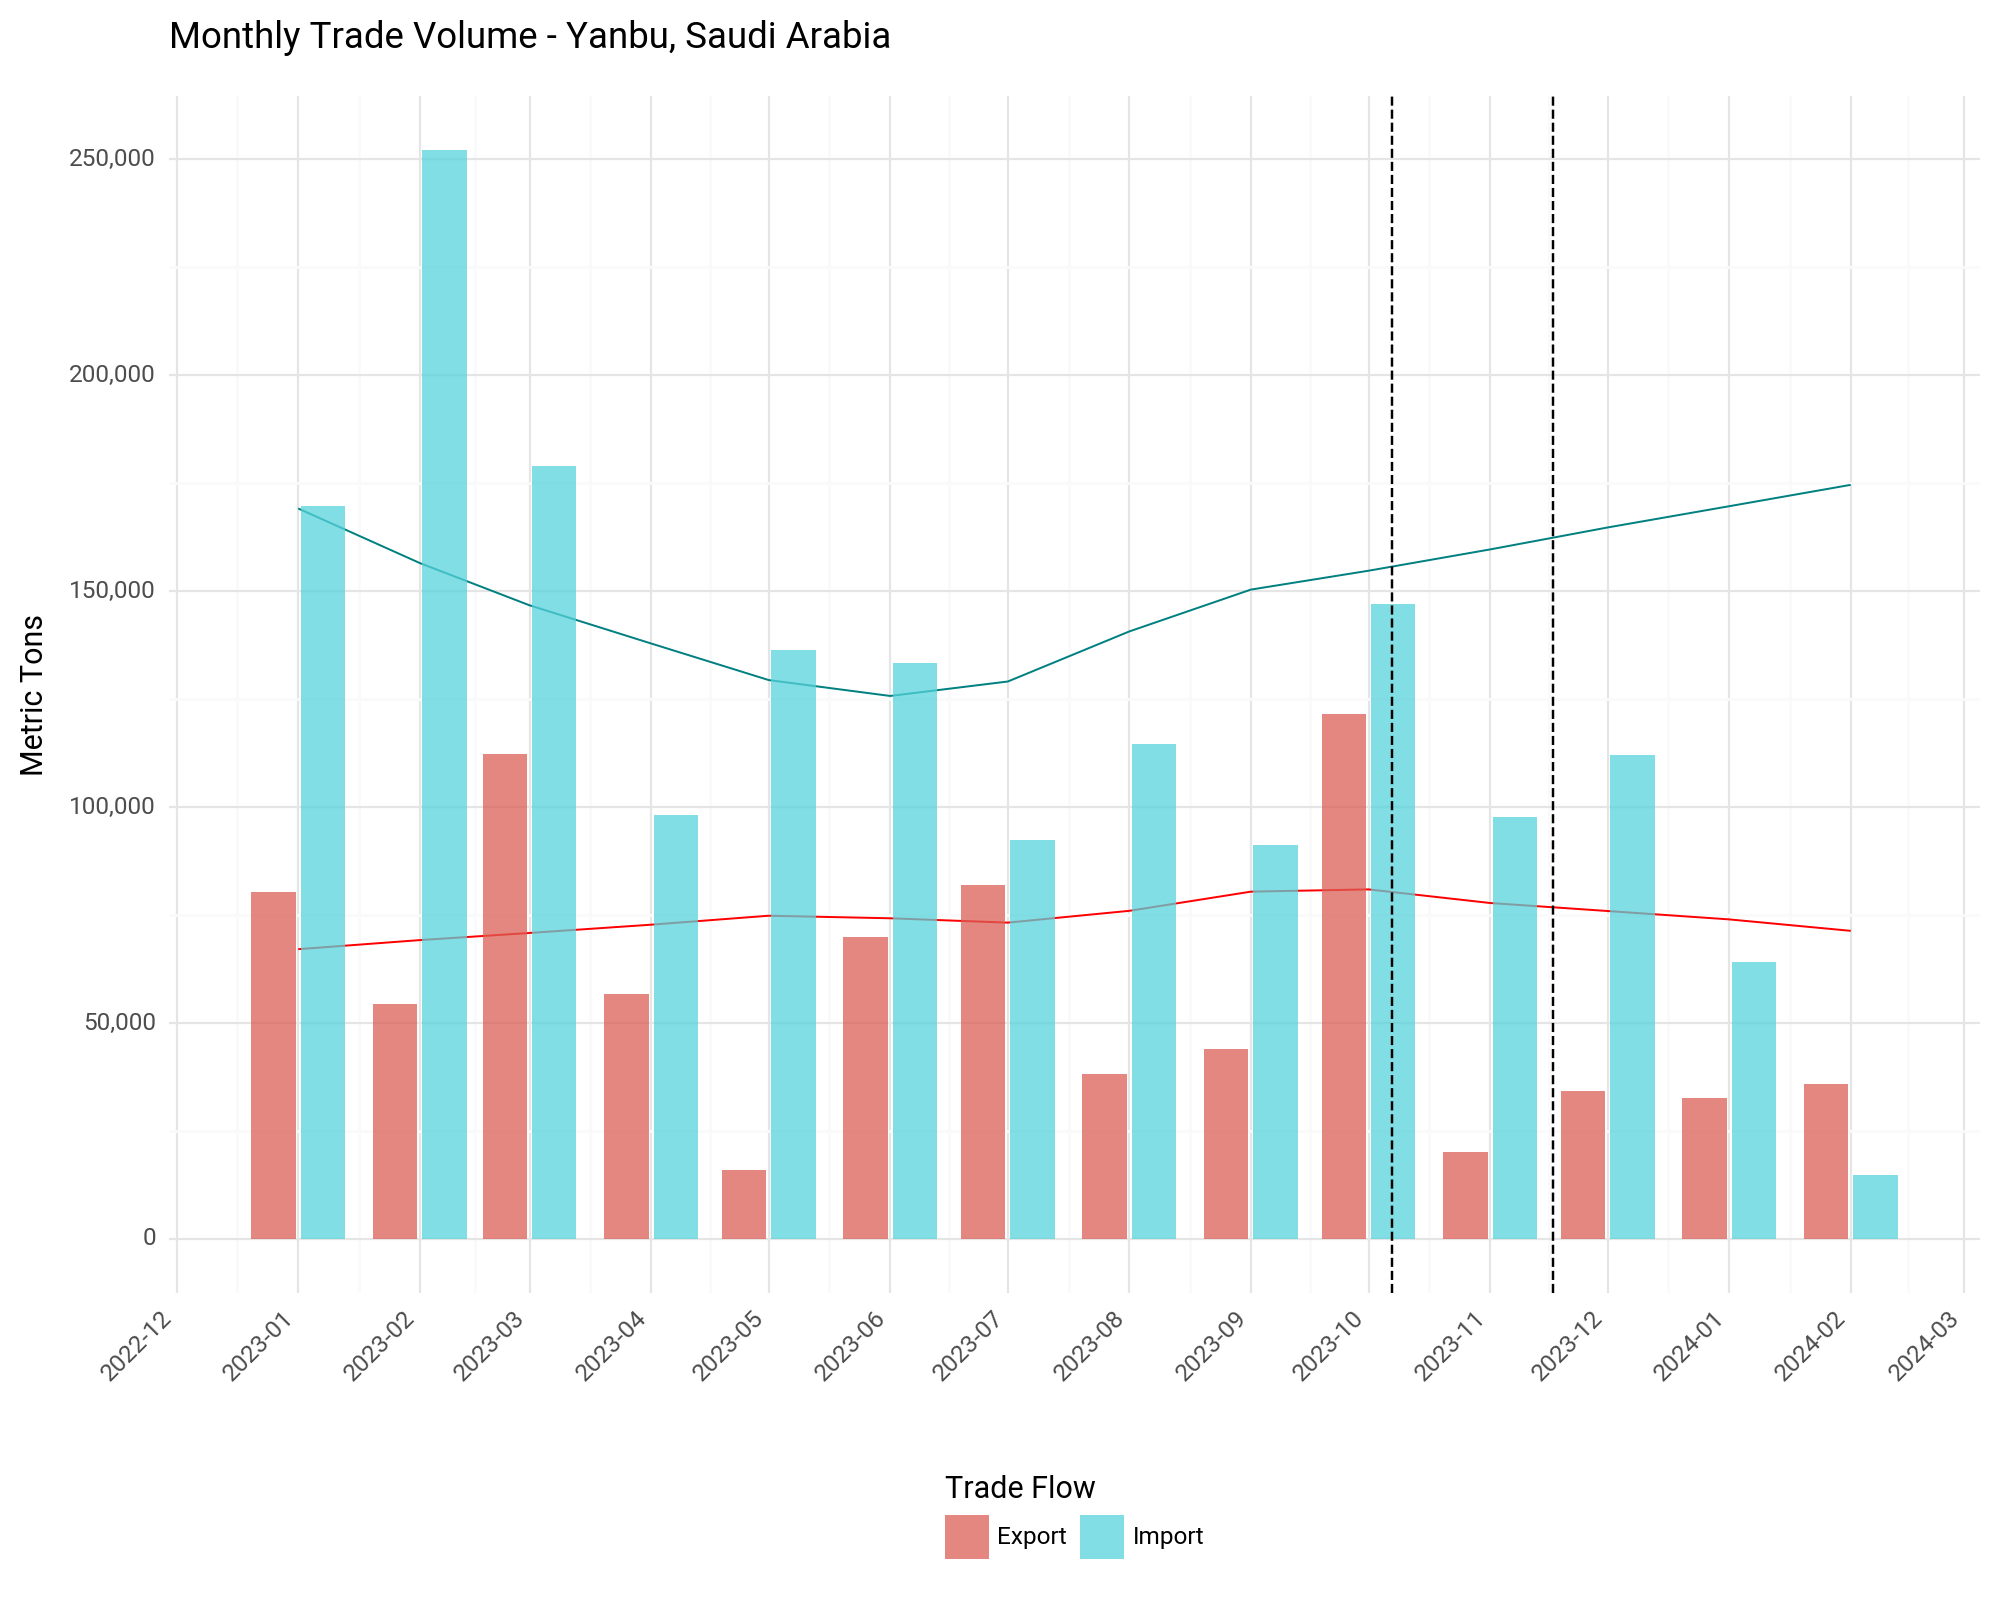

<Figure Size: (1000 x 800)>

In [21]:
for port in df_filt.portname.unique():
    port_info = ports_red_sea.loc[ports_red_sea.portname == port].iloc[0]
    country = port_info.country
    port_id = port_info.portid
    country = ports_red_sea.loc[ports_red_sea.portname == port, "country"].values[0]
    df_port = df_filt.loc[df_filt.portname == port].copy()
    df_port_copy = df_port.copy()
    df_port = df_port.melt(
        id_vars="date",
        value_vars=["import", "export"],
        var_name="direction",
        value_name="trade",
    )
    df_port.loc[:, "direction"] = df_port.direction.str.capitalize()
    p0 = (
        ggplot(df_port_copy, aes(x="date", y="import_ref"))  #
        + geom_smooth(
            mapping=aes(x="date", y="import_ref"), color="teal", size=0.4, alpha=3 / 4
        )
        + geom_smooth(
            mapping=aes(x="date", y="export_ref"), color="red", size=0.4, alpha=3 / 4
        )
        + geom_bar(
            mapping=aes(x="date", y="trade", fill="direction"),
            data=df_port,
            alpha=3 / 4,
            stat="identity",
            position="dodge2",
        )  #  fill="lightblue"
        # + geom_line(aes(x="date", y="export"), alpha=1, color="darkred")
        + geom_vline(xintercept=conflict_date, linetype="dashed", color="black")
        + geom_vline(xintercept=crisis_date, linetype="dashed", color="black")
        + labs(
            x="",
            y="Metric Tons",
            title=f"Monthly Trade Volume - {port}, {country}",
            fill="Trade Flow",
        )
        + theme_minimal()
        + theme(text=element_text(family="Roboto"))
        + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
        + scale_y_continuous(labels=comma_format())
        # + scale_fill_brewer(type='qual', palette=1)
        + theme(axis_text_x=element_text(rotation=45, hjust=1))
        + theme(legend_position="bottom")
    )
    display(p0)
    # p0.save(
    #     filename=join(charts_by_port_dir, f"estimated-trade-{port_id}.jpeg"), dpi=300
    # )

## Summary Statistics

Calculate average values by port and time period.

In [22]:
conflict_date, crisis_date

('2023-10-07', '2023-11-17')

In [23]:
df.loc[:, "period"] = ""
df.loc[
    (df.date >= start_reference_date) & (df.date < crisis_date), "period"
] = "Reference"
df.loc[
    (df.date >= conflict_date) & (df.date < crisis_date), "period"
] = "Middle East Conflict"
df.loc[(df.date >= crisis_date), "period"] = "Red Sea Crisis"
df = df.merge(ports_red_sea[["portname", "country"]], on="portname")

In [24]:
df_agg = (
    df.loc[df.period != ""]
    .groupby(["country", "portname", "period"])[
        [
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
        ]
    ]
    .mean()
)

# change order of rows
df_agg = df_agg.reindex(
    ["Reference", "Middle East Conflict", "Red Sea Crisis"], level=2
)

In [25]:
df_agg.head()

import_cargo  export_cargo  \
country  portname  period                                              
Djibouti Djibouti  Reference             496247.680293  36377.760091   
                   Middle East Conflict  506080.778169  49467.517026   
                   Red Sea Crisis        401003.352096  77485.393260   
Egypt    As Suways Reference               4647.839993   5132.097389   
                   Middle East Conflict    5706.168006      0.000000   

                                         import_tanker  export_tanker  \
country  portname  period                                               
Djibouti Djibouti  Reference             158453.719309   12919.346749   
                   Middle East Conflict  120204.648986    4082.797276   
                   Red Sea Crisis        139391.934181   17144.853873   
Egypt    As Suways Reference                782.534881    1126.581524   
                   Middle East Conflict       0.000000       0.000000   

                                                import        export  
country  portname  period                                             
Djibouti Djibouti  Reference             654701.399602  49297.106841  
                   Middle East Conflict  626285.427155  53550.314301  
                   Red Sea Crisis        540395.286277  94630.247133  
Egypt    As Suways Reference               5430.374874   6258.678912  
                   Middle East Conflict    5706.168006      0.000000

In [26]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

### Table: Monthly Average Values by Time Period

In [27]:
table = df_agg.copy()
table = table.applymap(lambda x: "{:,.0f}".format(x))
table.rename(
    columns={
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
table.index.names = ["Country", "Port", "Period"]
table
# table.transpose()

C:\Users\WB514197\AppData\Local\Temp\ipykernel_15560\2029759337.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Cargo Import  \
Country      Port                            Period                              
Djibouti     Djibouti                        Reference                 496,248   
                                             Middle East Conflict      506,081   
                                             Red Sea Crisis            401,003   
Egypt        As Suways                       Reference                   4,648   
                                             Middle East Conflict        5,706   
                                             Red Sea Crisis              7,646   
             El-Adabiya                      Reference                  56,300   
                                             Middle East Conflict       63,403   
                                             Red Sea Crisis             28,988   
             North Ain Sukhna Port           Reference                 417,506   
                                             Middle East Conflict      478,392   
                                             Red Sea Crisis            244,003   
             Safaga                          Reference                  73,386   
                                             Middle East Conflict       87,906   
                                             Red Sea Crisis            108,730   
Jordan       Al Aqabah                       Reference                 505,767   
                                             Middle East Conflict      323,566   
                                             Red Sea Crisis            211,418   
Saudi Arabia Duba                            Reference                  11,470   
                                             Middle East Conflict        9,502   
                                             Red Sea Crisis             17,484   
             Duba Bulk Plant Tanker Terminal Reference                       0   
                                             Middle East Conflict            0   
                                             Red Sea Crisis                  0   
             Jiddah                          Reference               1,116,323   
                                             Middle East Conflict    1,241,235   
                                             Red Sea Crisis            672,842   
             Jiddah Oil                      Reference                       0   
                                             Middle East Conflict            0   
                                             Red Sea Crisis                  0   
             King Fahd Port                  Reference                  72,768   
                                             Middle East Conflict       44,789   
                                             Red Sea Crisis             71,688   
             Rabigh                          Reference                 515,971   
                                             Middle East Conflict      443,722   
                                             Red Sea Crisis            163,975   
             Yanbu                           Reference                 127,704   
                                             Middle East Conflict       89,140   
                                             Red Sea Crisis             53,960   
Yemen        Aden                            Reference                 216,989   
                                             Middle East Conflict      163,033   
                                             Red Sea Crisis            126,452   
             Al Ahmadi                       Reference                 135,216   
                                             Middle East Conflict      231,323   
                                             Red Sea Crisis            204,161   
             Al Mukalla                      Reference                  18,541   
                                             Middle East Conflict       17,786   
                                             Red

In [28]:
countries = list(df.country.unique())
df_agg_copy = df_agg.copy()
res = []
for country in countries:
    df_country = df_agg_copy.loc[(country), :].copy()
    aois = df_country.index.get_level_values(0).unique()
    for aoi in aois:
        df_sub = df_country.loc[(aoi), :].transpose().copy()
        df_sub.loc[:, "Middle East Conflict"] = (
            df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
        ) / df_sub.loc[:, "Reference"]
        df_sub.loc[:, "Red Sea Crisis"] = (
            df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
        ) / df_sub.loc[:, "Reference"]
        df_sub2 = df_sub.transpose()
        df_sub2.drop("Reference", inplace=True)
        df_sub2.loc[:, "portname"] = aoi
        df_sub2.loc[:, "country"] = country
        res.append(df_sub2)

In [29]:
df_agg_pct = pd.concat(res)

### Table: Monthly Average Values by Time Period, % Change from Baseline

In [30]:
df_agg_pct.reset_index(inplace=True)
df_agg_pct.set_index(["country", "portname", "period"], inplace=True)

# format columns as pct
df_agg_pct = df_agg_pct.applymap(lambda x: "{:.2%}".format(x))
df_agg_pct.rename(
    columns={
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
df_agg_pct.index.names = ["Country", "Port", "Period"]
df_agg_pct

C:\Users\WB514197\AppData\Local\Temp\ipykernel_15560\2739311718.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Cargo Import  \
Country      Port                            Period                              
Yemen        Aden                            Middle East Conflict      -24.87%   
                                             Red Sea Crisis            -41.72%   
             Al Ahmadi                       Middle East Conflict       71.08%   
                                             Red Sea Crisis             50.99%   
             Al Mukalla                      Middle East Conflict       -4.07%   
                                             Red Sea Crisis            -64.38%   
Jordan       Al Aqabah                       Middle East Conflict      -36.02%   
                                             Red Sea Crisis            -58.20%   
Egypt        As Suways                       Middle East Conflict       22.77%   
                                             Red Sea Crisis             64.50%   
             El-Adabiya                      Middle East Conflict       12.62%   
                                             Red Sea Crisis            -48.51%   
             North Ain Sukhna Port           Middle East Conflict       14.58%   
                                             Red Sea Crisis            -41.56%   
             Safaga                          Middle East Conflict       19.79%   
                                             Red Sea Crisis             48.16%   
Djibouti     Djibouti                        Middle East Conflict        1.98%   
                                             Red Sea Crisis            -19.19%   
Saudi Arabia Duba                            Middle East Conflict      -17.15%   
                                             Red Sea Crisis             52.44%   
             Duba Bulk Plant Tanker Terminal Middle East Conflict         nan%   
                                             Red Sea Crisis               nan%   
             Jiddah                          Middle East Conflict       11.19%   
                                             Red Sea Crisis            -39.73%   
             Jiddah Oil                      Middle East Conflict         nan%   
                                             Red Sea Crisis               nan%   
             King Fahd Port                  Middle East Conflict      -38.45%   
                                             Red Sea Crisis             -1.48%   
             Rabigh                          Middle East Conflict      -14.00%   
                                             Red Sea Crisis            -68.22%   
             Yanbu                           Middle East Conflict      -30.20%   
                                             Red Sea Crisis            -57.75%   

                                                                  Cargo Export  \
Country      Port                            Period                              
Yemen        Aden                            Middle East Conflict      -67.76%   
                                             Red Sea Crisis            -69.11%   
             Al Ahmadi                       Middle East Conflict      -23.33%   
                                             Red Sea Crisis            -73.16%   
             Al Mukalla                      Middle East Conflict      -84.15%   
                                             Red Sea Crisis           -100.00%   
Jordan       Al Aqabah                       Middle East Conflict      -51.47%   
                                             Red Sea Crisis            -53.29%   
Egypt        As Suways                       Middle East Conflict     -100.00%   
                                             Red Sea Crisis            -56.36%   
             El-Adabiya                      Middle East Conflict       39.25%   
                                             Red Sea Crisis            -13.37%   
             North Ain Sukhna Port           Middle East Conflict      124.56%   
                                             Re

Save tables to excel

In [31]:
with pd.ExcelWriter(join(output_dir, "tables", "summary-tables-ports.xlsx")) as writer:  
    table.to_excel(writer, sheet_name='Ports Summary')
    df_agg_pct.to_excel(writer, sheet_name='Ports % Change')